In [4]:
import pandas as pd

In [2]:
# використовувати, якщо дані записані в базі даних
import pymongo

DBURL = "mongodb://localhost:27017/realty"
DBNAME = "realty"

client = pymongo.MongoClient(DBURL)
db = client[DBNAME]

data = list(db.apartments.find({}))
for document in data:
    document |= {
        "city": document["location"]["city"], 
        "street": document["location"]["street"],
        # "longitude": document["location"]["longitude"],
        # "latitude": document["location"]["latitude"]
    }
df = pd.DataFrame(data)

In [8]:
# використовувати, якщо є дані в csv файлі
df = pd.read_csv("data.csv")

In [9]:
df = df.drop(columns=["location", "cluster_id"])
print(df.head())
print(df.describe())

   Unnamed: 0                       _id  \
0           0  6609ce8ccb3921f5c65ac84b   
1           1  6609ce8ccb3921f5c65ac84c   
2           2  6609ce8ccb3921f5c65ac84d   
3           3  6609ce8ccb3921f5c65ac84e   
4           4  6609ce8ccb3921f5c65ac84f   

                                                link  boosted  \
0  https://www.olx.ua/d/uk/obyavlenie/prodam-2-km...     True   
1  https://www.olx.ua/d/uk/obyavlenie/1-kmnatna-k...     True   
2  https://www.olx.ua/d/uk/obyavlenie/kvartira-v-...     True   
3  https://www.olx.ua/d/uk/obyavlenie/kvartira-dv...    False   
4  https://www.olx.ua/d/uk/obyavlenie/1k-r-n-mitn...    False   

            published                                               navs  \
0  29 березня 2024 р.  ['Головна', 'Нерухомість', 'Квартири', 'Продаж...   
1  28 березня 2024 р.  ['Головна', 'Нерухомість', 'Квартири', 'Продаж...   
2  29 березня 2024 р.  ['Головна', 'Нерухомість', 'Квартири', 'Продаж...   
3            30.03.24  ['Головна', 'Нерухоміст

<Axes: >

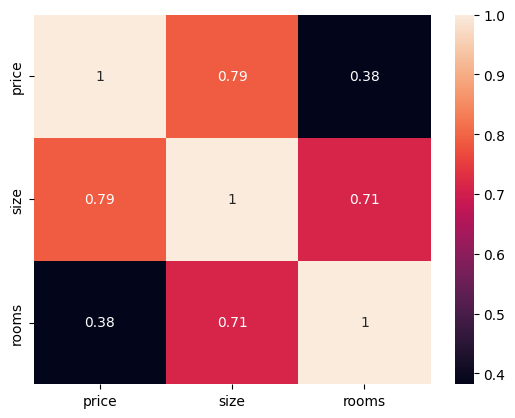

In [14]:
# виведемо кореляційну матрицю, щоб переглянути зв'язки між даними
import seaborn as sns
sns.heatmap(df[["price", "size", "rooms"]].corr(), annot=True)

<Axes: >

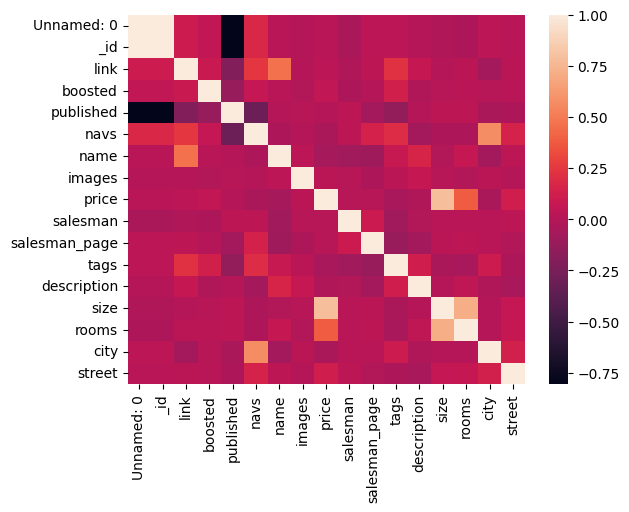

In [16]:
# виведемо кореляційну матрицю всіх даних
temp_df = df.copy()

for column in temp_df.columns:
    try:
        temp_df[column].astype(float)
    except:
        temp_df[column] = temp_df[column].astype("category").cat.codes

sns.heatmap(temp_df.corr())

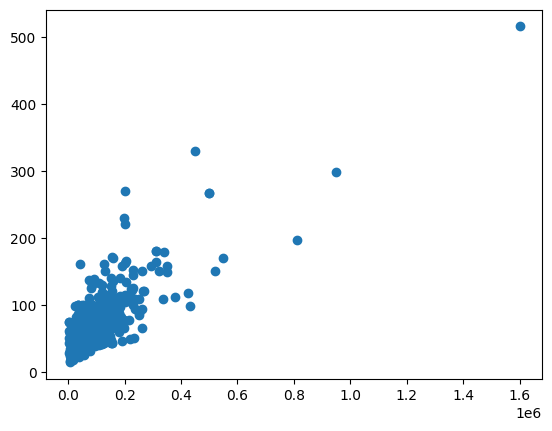

In [17]:
import matplotlib.pyplot as plt

plt.scatter(df["price"], df["size"])

In [18]:
# розіб'ємо дані по кластерах, щоб була можливість 
# натренувати модель лінійної регресії й виокремлювати різні пропозиції
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# видалимо зайві дані
df = df[(df["price"] > 20000) & (df["price"] < 130000) & (df["size"] < 120)]
print(len(df))

nums = df.loc[:, ("size", "price")]
text = df.loc[:, ("city", "_id")]

scaler = StandardScaler()
norm_nums = scaler.fit_transform(nums)
norm = np.column_stack((norm_nums, text))

kmeans = KMeans(48, max_iter=500)
clusters = kmeans.fit_predict(norm_nums)

# додамо айді кластерів
df_res = pd.DataFrame(columns=[
    "size_cluster", "price_cluster", "city", "_id", "cluster_id"
])
i = 0
for cluster_id in np.unique(clusters):
    cluster_mask = (clusters == cluster_id)
    cluster_data = norm[cluster_mask]
    for data in cluster_data:
        df_res.loc[i] = list(data) + [cluster_id]
        i += 1


974


In [19]:
# об'єднажмо таблиці й видалимо дублікати
df_res = pd.merge(df, df_res, on=["_id"])
df_res = df_res.drop(columns=["city_y"])
df_res = df_res.rename(columns={"city_x": "city"})

In [20]:
# виведемо всі дані
with pd.option_context("display.max_rows", None):
    print(df_res[["price", "size", "rooms", "city", "cluster_id"]])

             price    size  rooms                   city  cluster_id
0     74000.000000   60.00    2.0                Житомир          22
1     62500.000000   41.00    1.0                 Ірпінь          11
2     54300.000000   54.10    2.0                Вишневе          16
3     33000.000000   33.00    1.0                Черкаси           7
4     40000.000000   45.00    1.0                  Івано           0
5     36000.000000   54.00    2.0                 Дніпро          43
6     77000.000000   81.30    3.0                  Одеса           1
7     29000.000000   78.00    4.0              Запоріжжя          21
8     35000.000000   44.00    1.0           Хмельницький           0
9     44000.000000   36.00    1.0          Нові Петрівці          41
10    52000.000000   35.00    1.0                  Одеса           8
11    74000.000000   60.00    2.0                 Ірпінь          22
12    45000.000000   86.00    3.0                 Харків          21
13    28500.000000   33.00    1.0 

In [22]:
# згрупуємо дані, щоб знайти середні значення кожної групи
results = df_res.groupby("cluster_id")[["price", "size", "rooms"]].mean()
results = pd.DataFrame({
    "cluster_id": list(results["price"].axes[0]),
    "price": results["price"].values,
    "size": results["size"].values,
    "rooms": results["rooms"].values
})

results

,cluster_id,price,size,rooms
0,0,39061.908438,44.281400,1.480000
1,1,71085.666667,78.476190,2.571429
2,2,88026.458333,43.970000,1.100000
3,3,119348.958333,98.250000,3.250000
4,4,70430.965517,54.063103,2.000000
5,5,38300.000000,63.234783,2.739130
6,6,112038.384615,72.067692,2.153846
7,7,30741.847619,32.471143,1.028571
8,8,53462.933333,35.770000,1.066667
9,9,90061.380952,81.654762,2.571429


/tmp/ipykernel_175302/1891786093.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = plt.scatter(cluster_df["size"], cluster_df["price"], cmap="viridis", edgecolors="black")


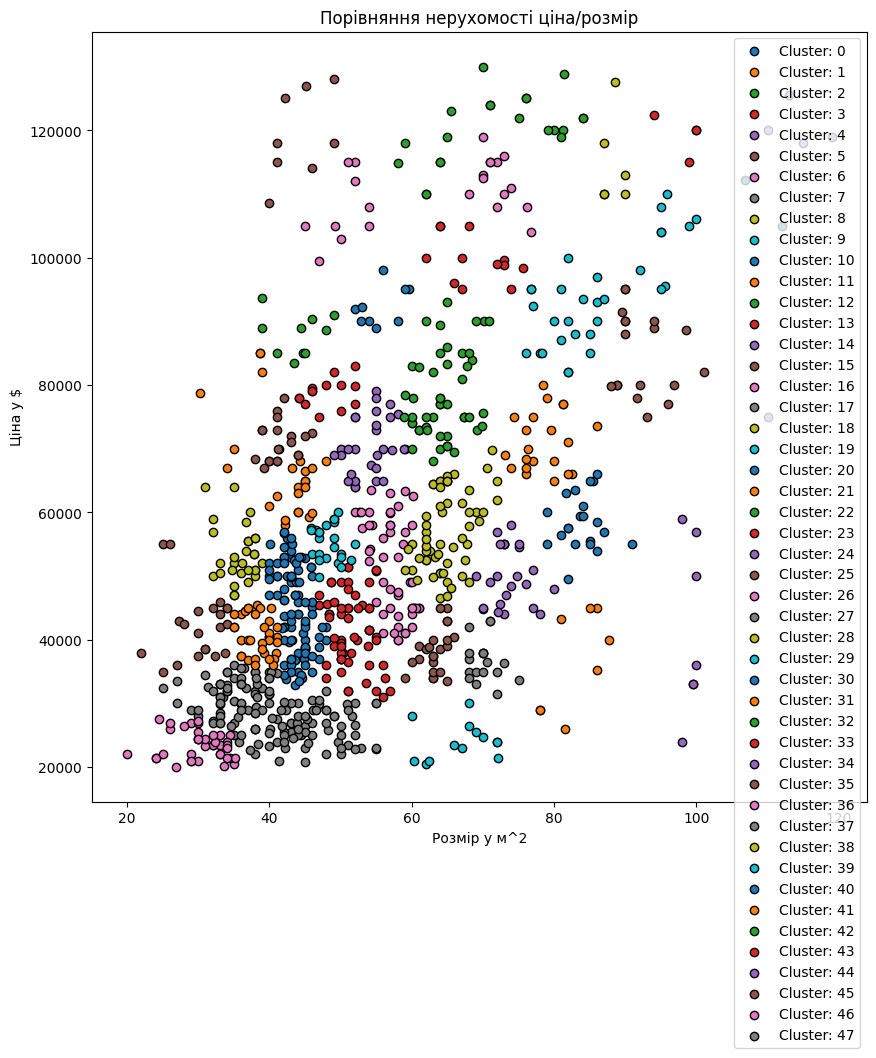

In [23]:
# виведемо всі дані, роблячи помітки на різних кластерах
plt.subplots(figsize=(10, 10))

for cluster_id in results["cluster_id"].unique():
    cluster_df = df_res[df_res["cluster_id"] == cluster_id]
    sct = plt.scatter(cluster_df["size"], cluster_df["price"], cmap="viridis", edgecolors="black")
    sct.set_label(f"Cluster: {cluster_id}")

plt.xlabel("Розмір у м^2")
plt.ylabel("Ціна у $")
plt.title("Порівняння нерухомості ціна/розмір")
plt.set_cmap('coolwarm')
plt.legend()
plt.show()

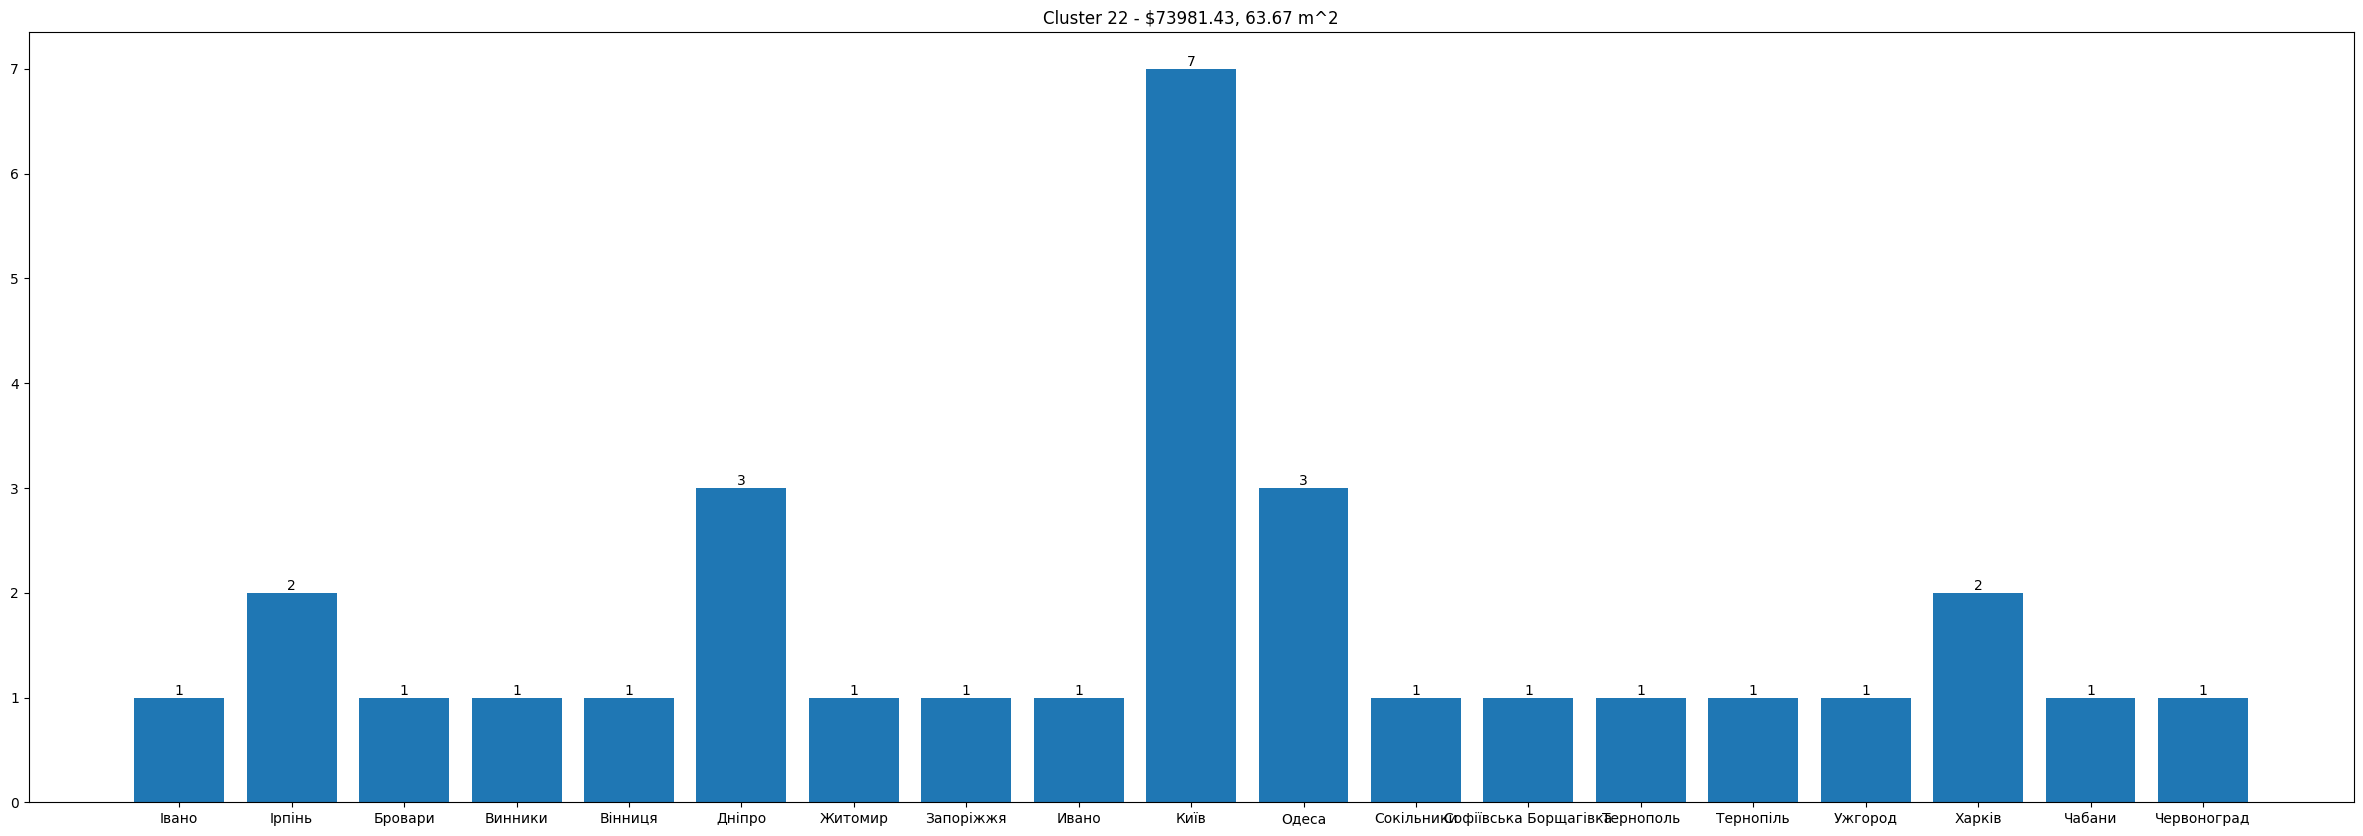

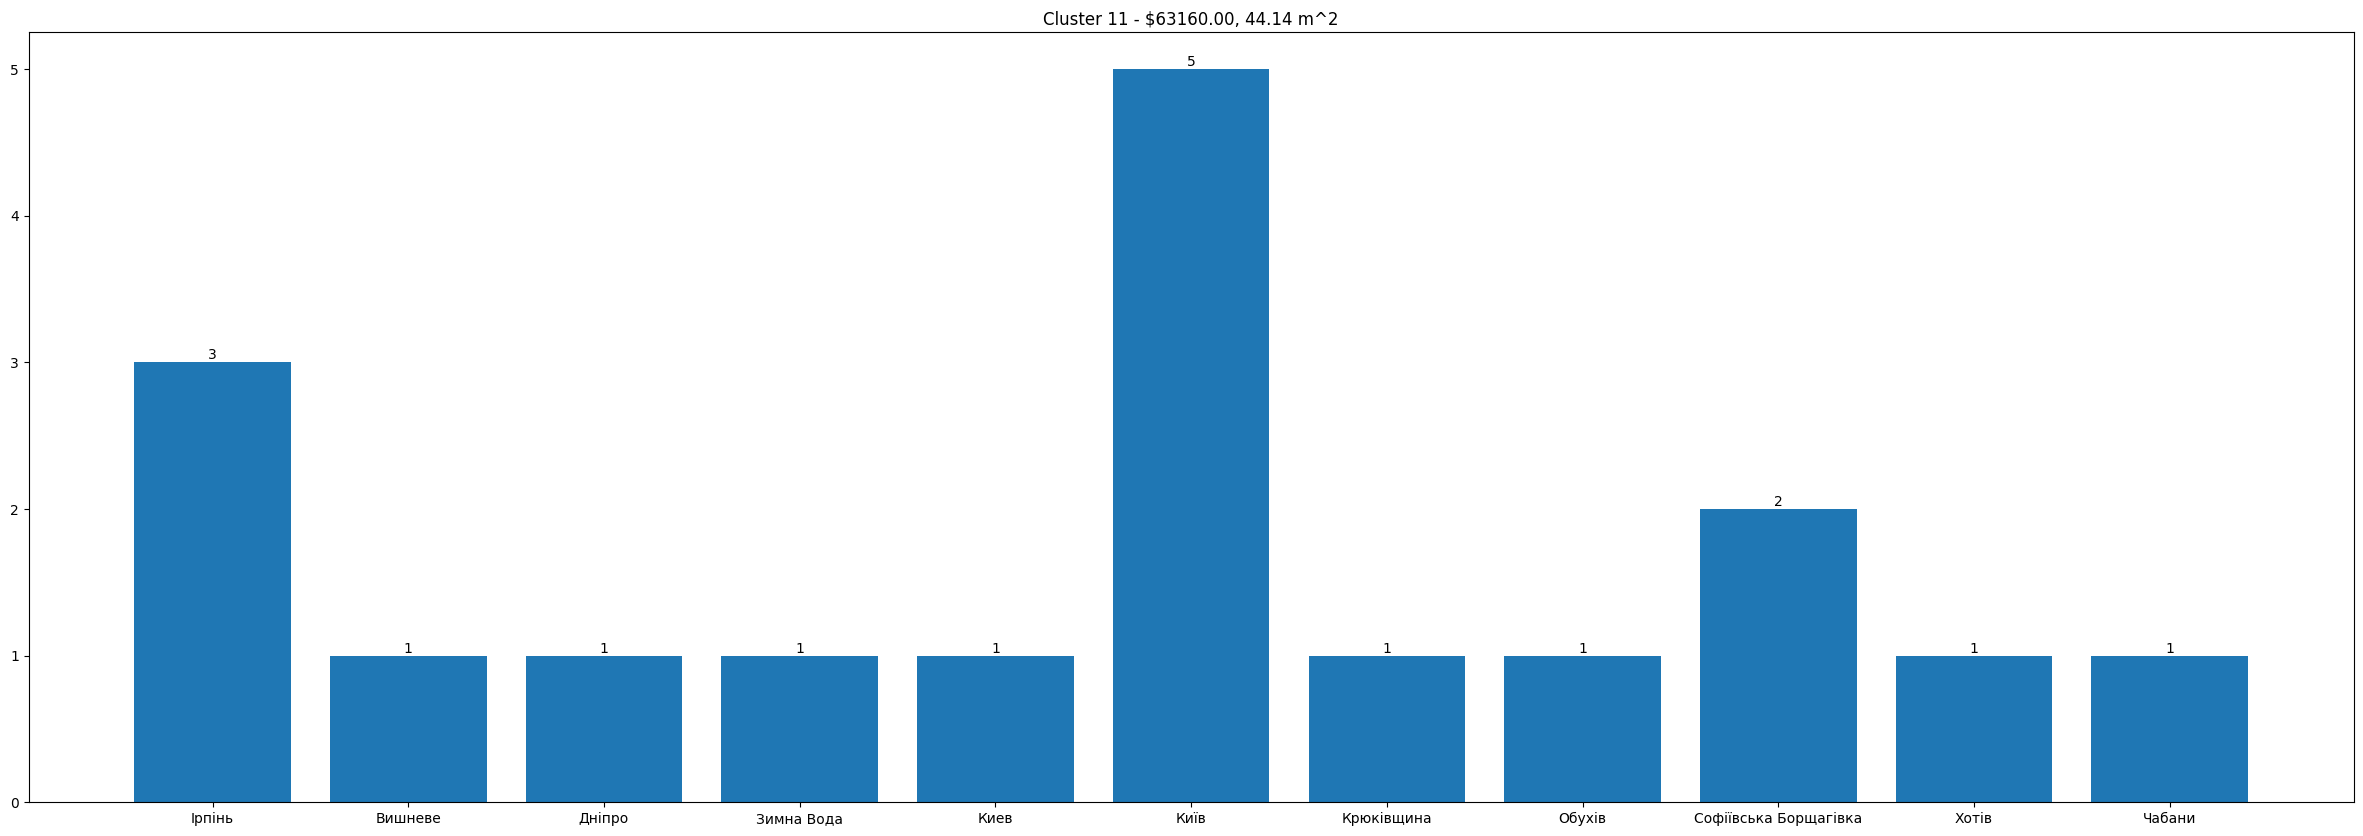

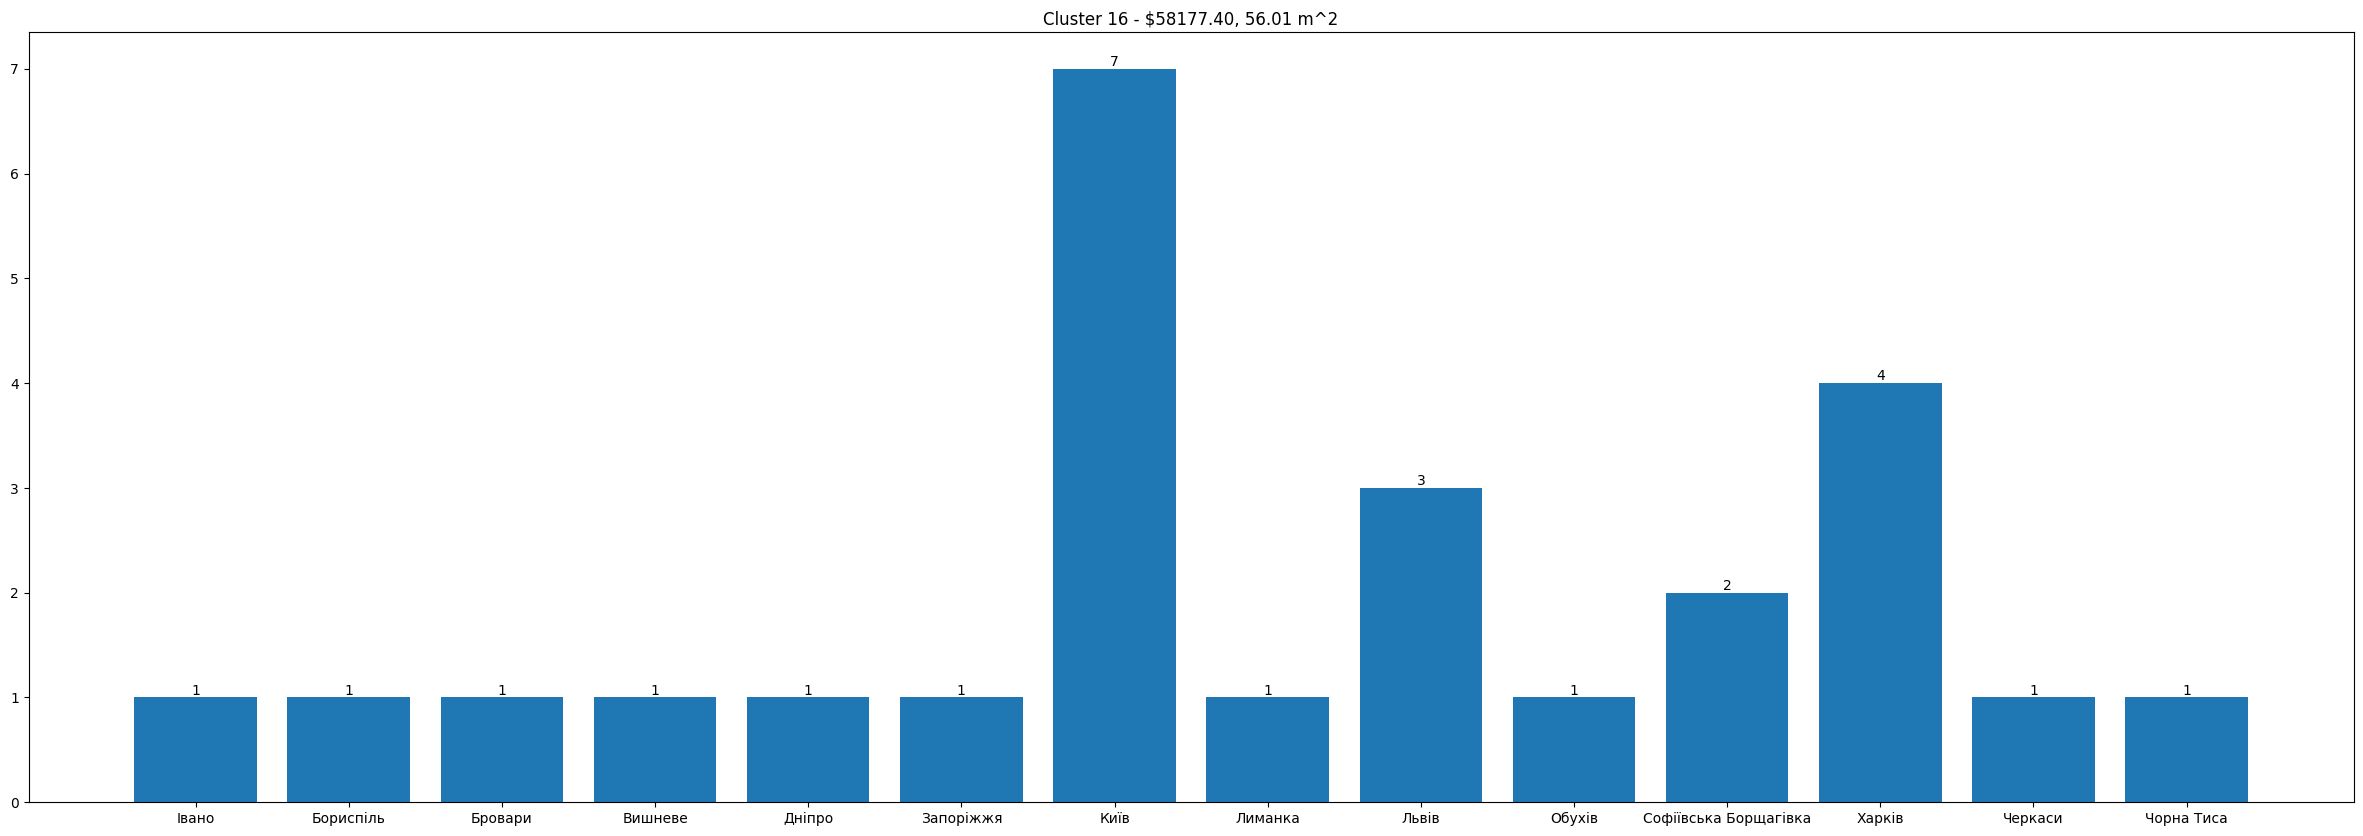

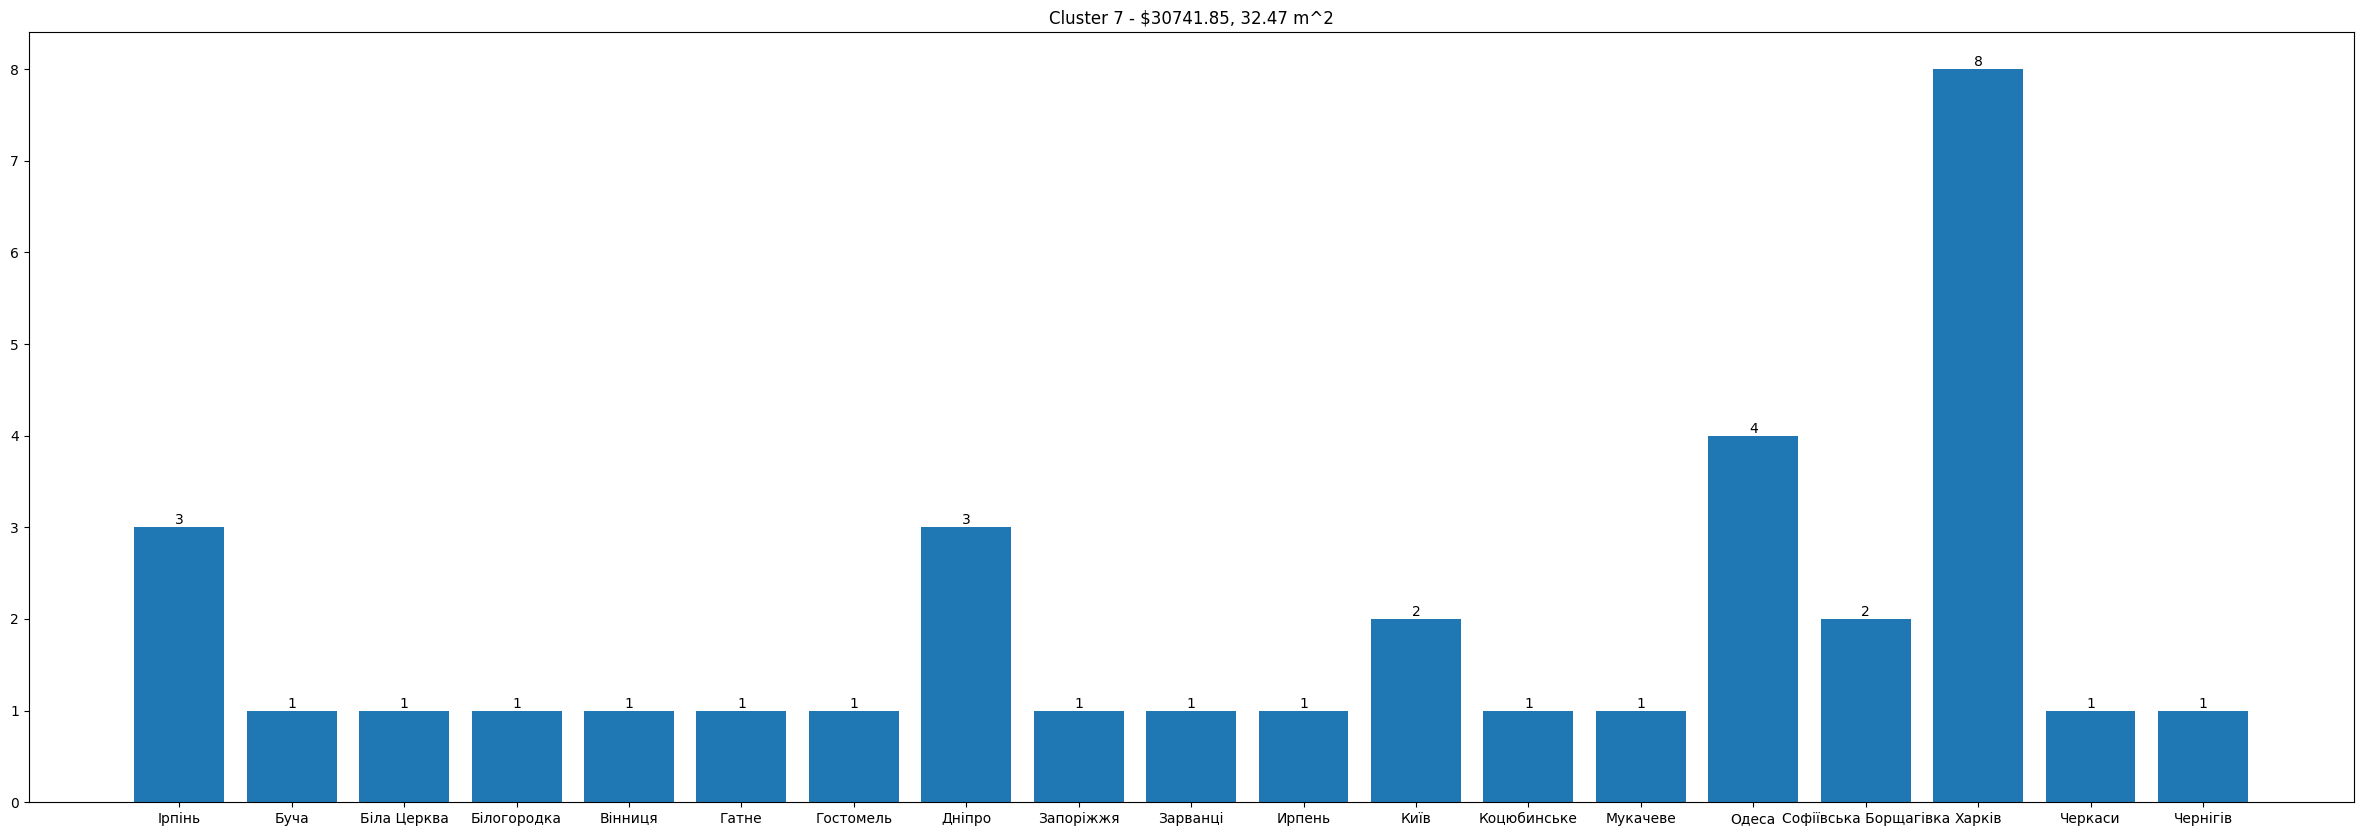

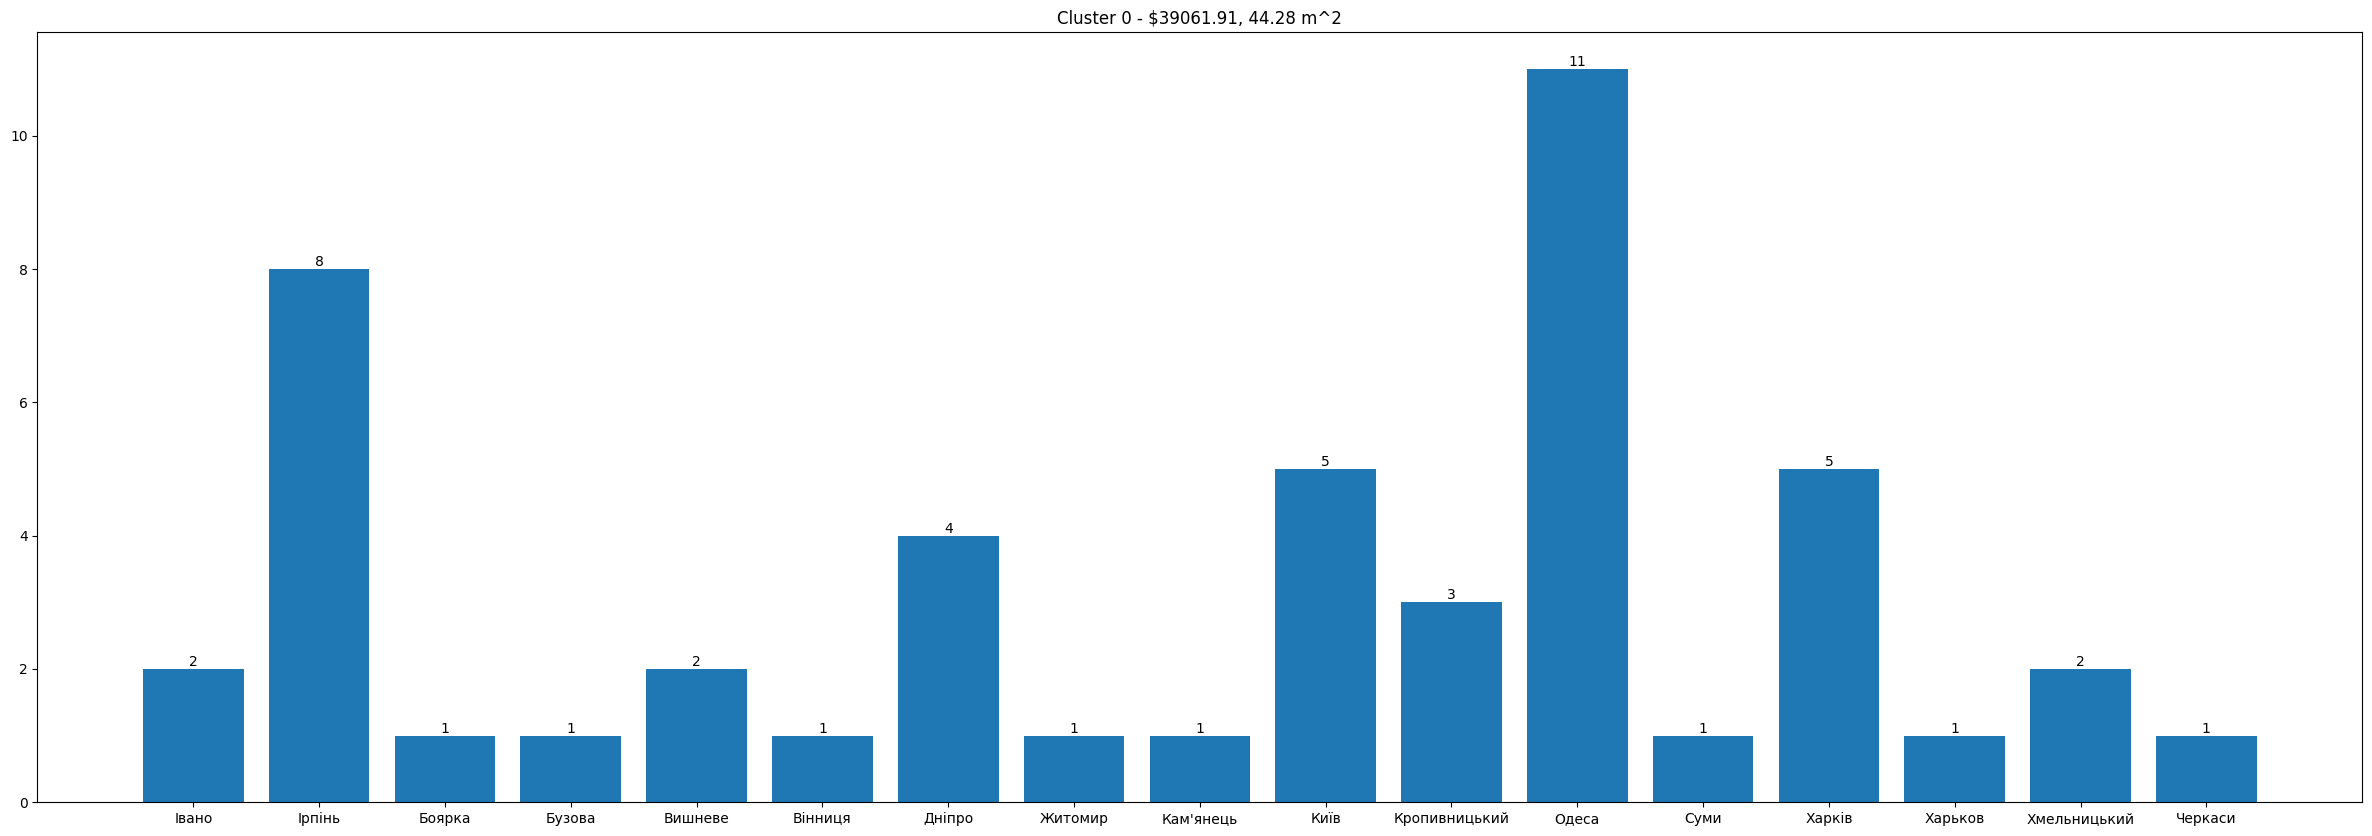

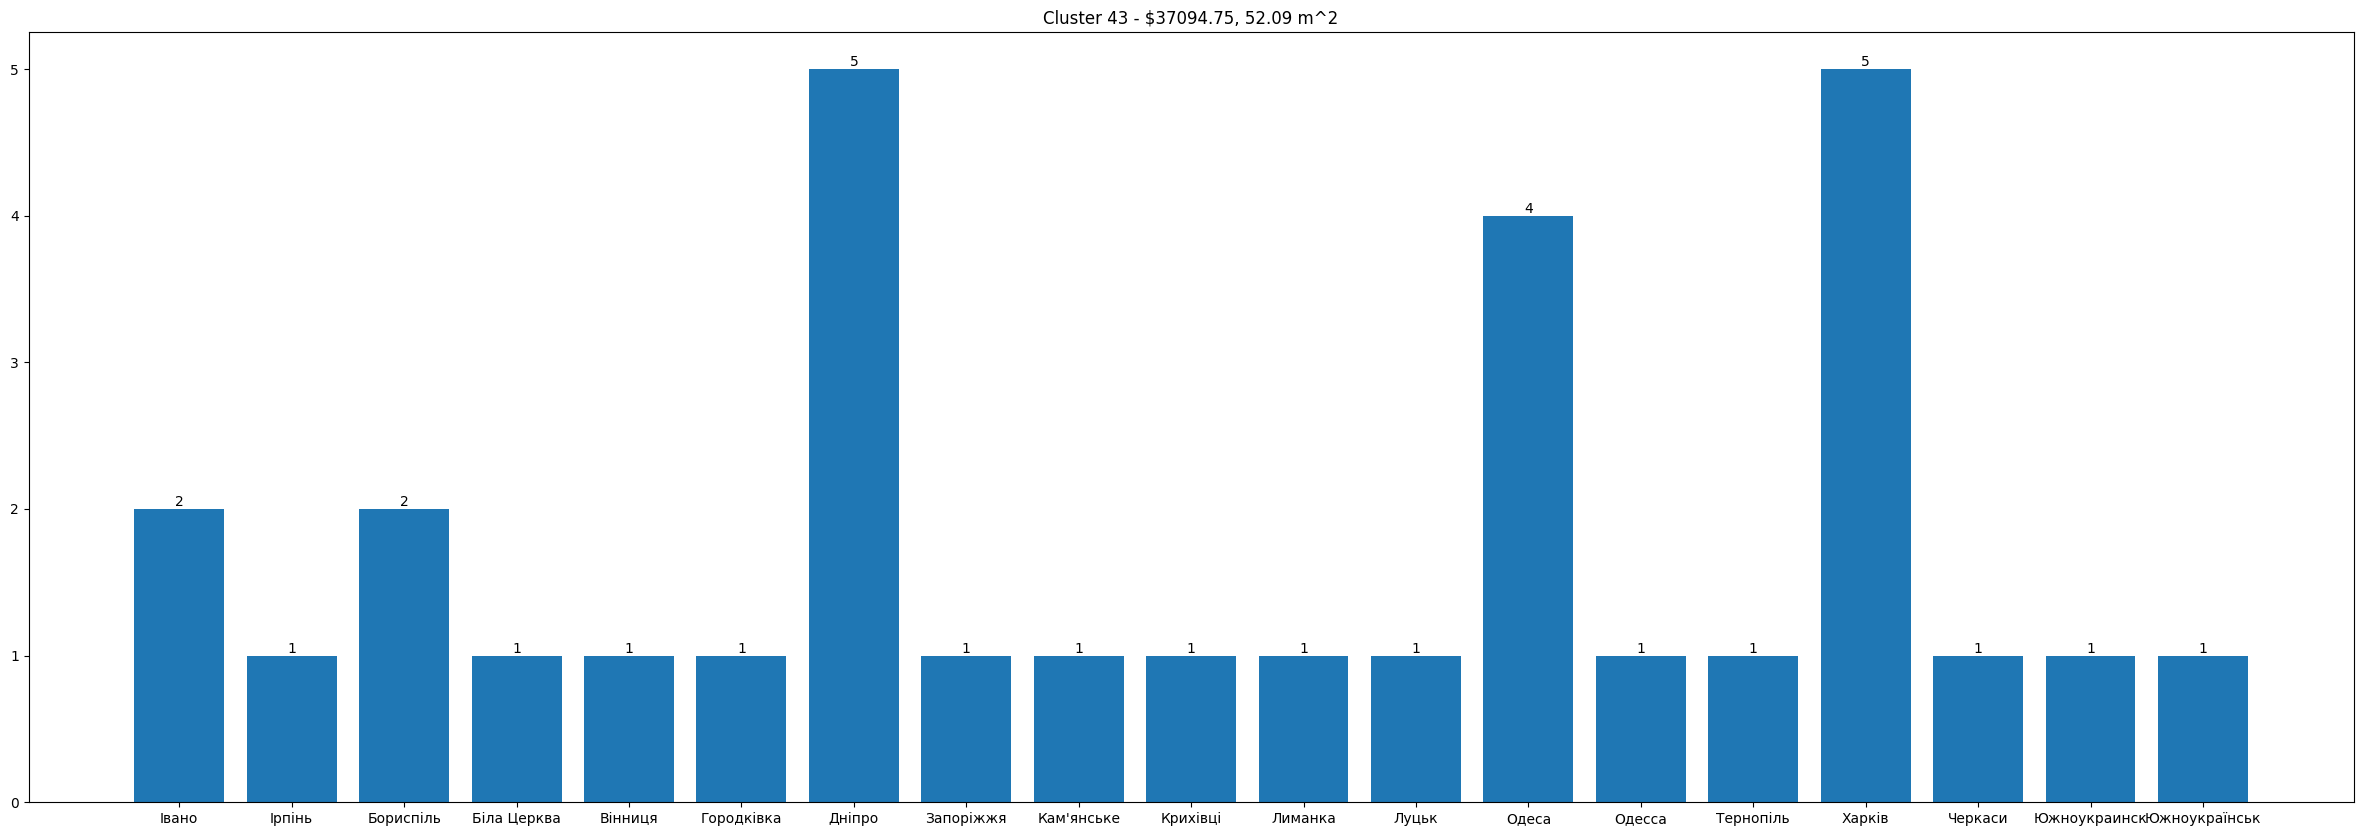

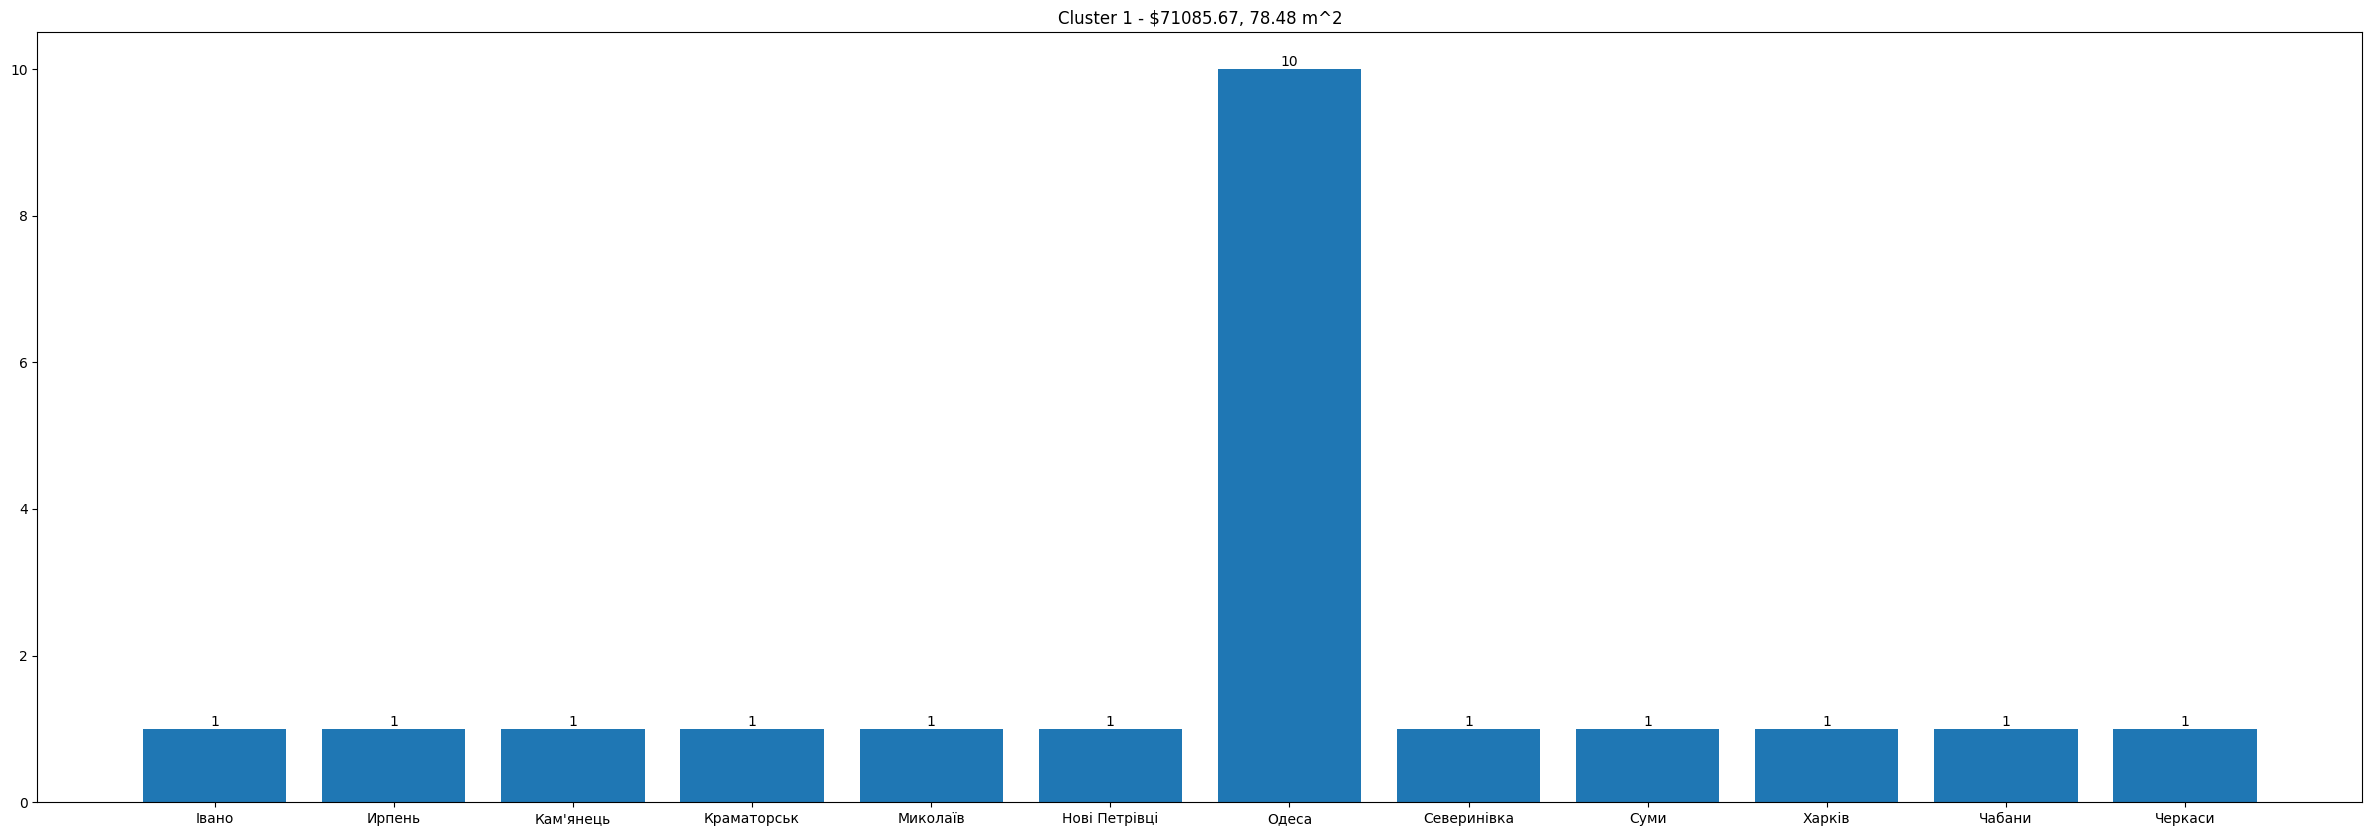

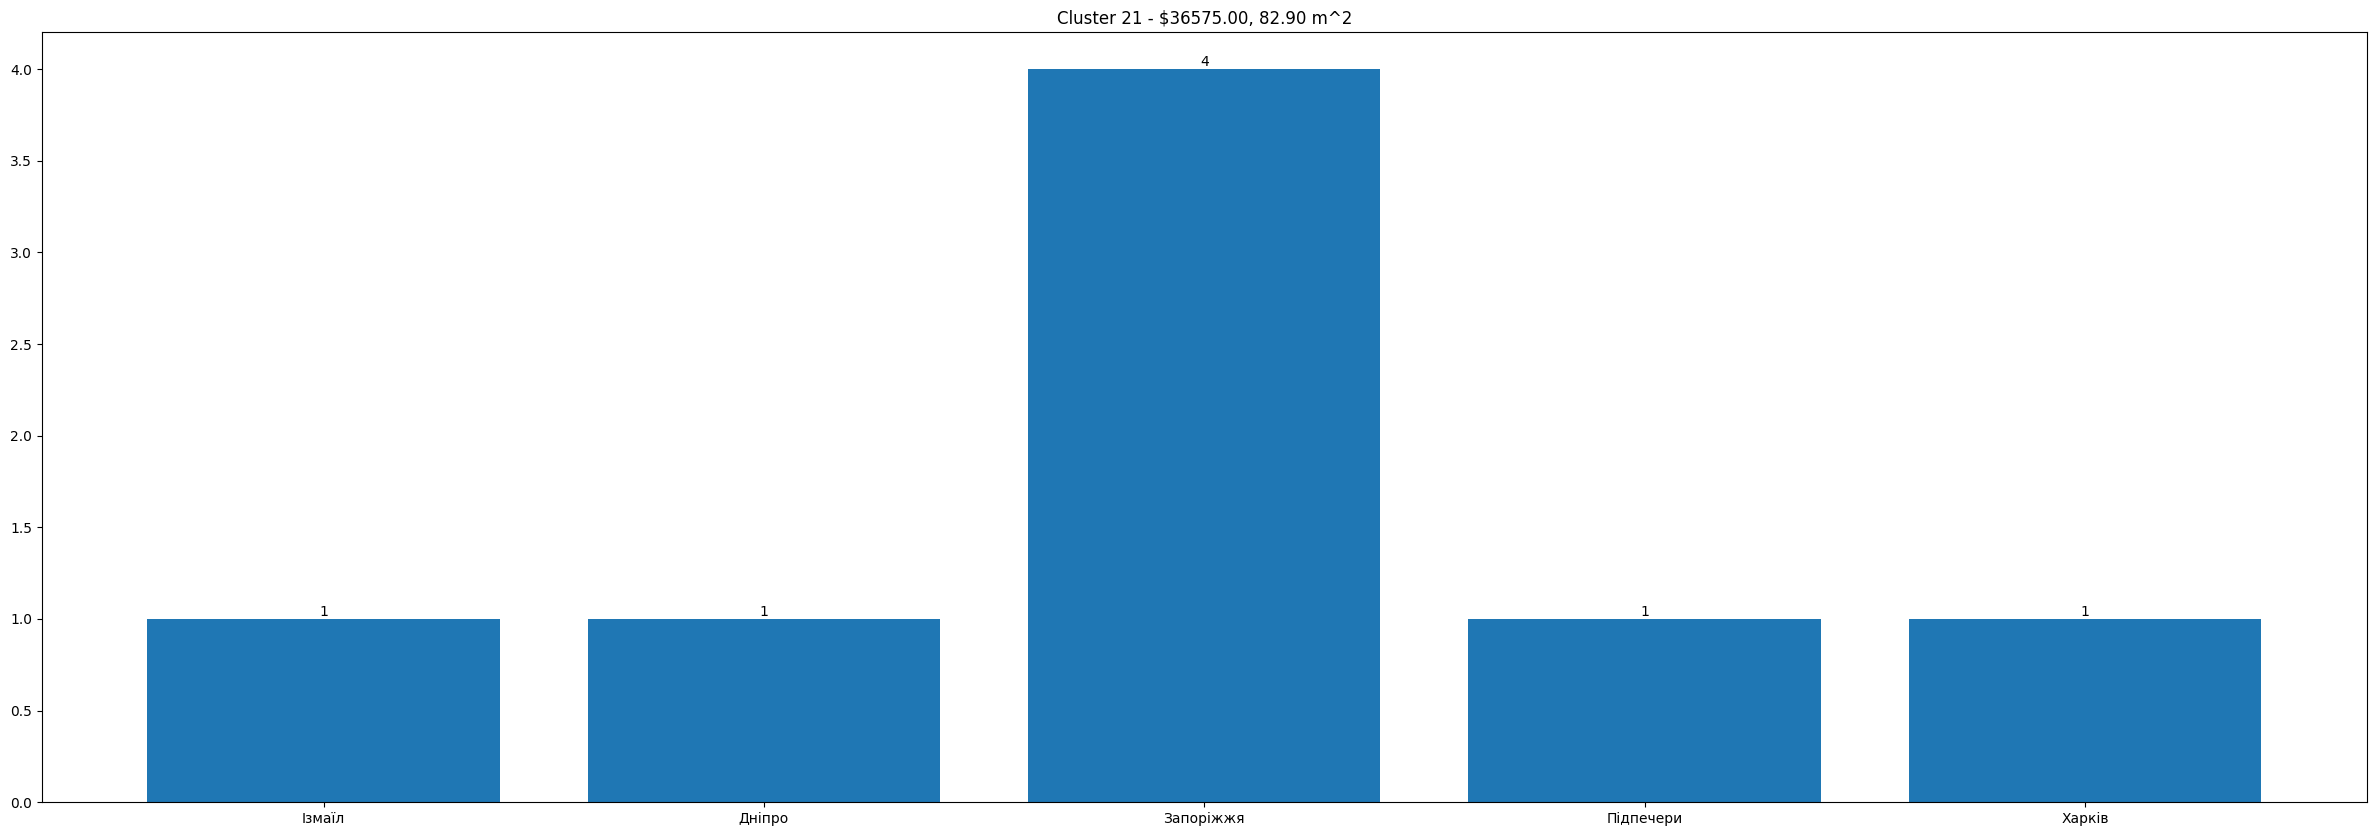

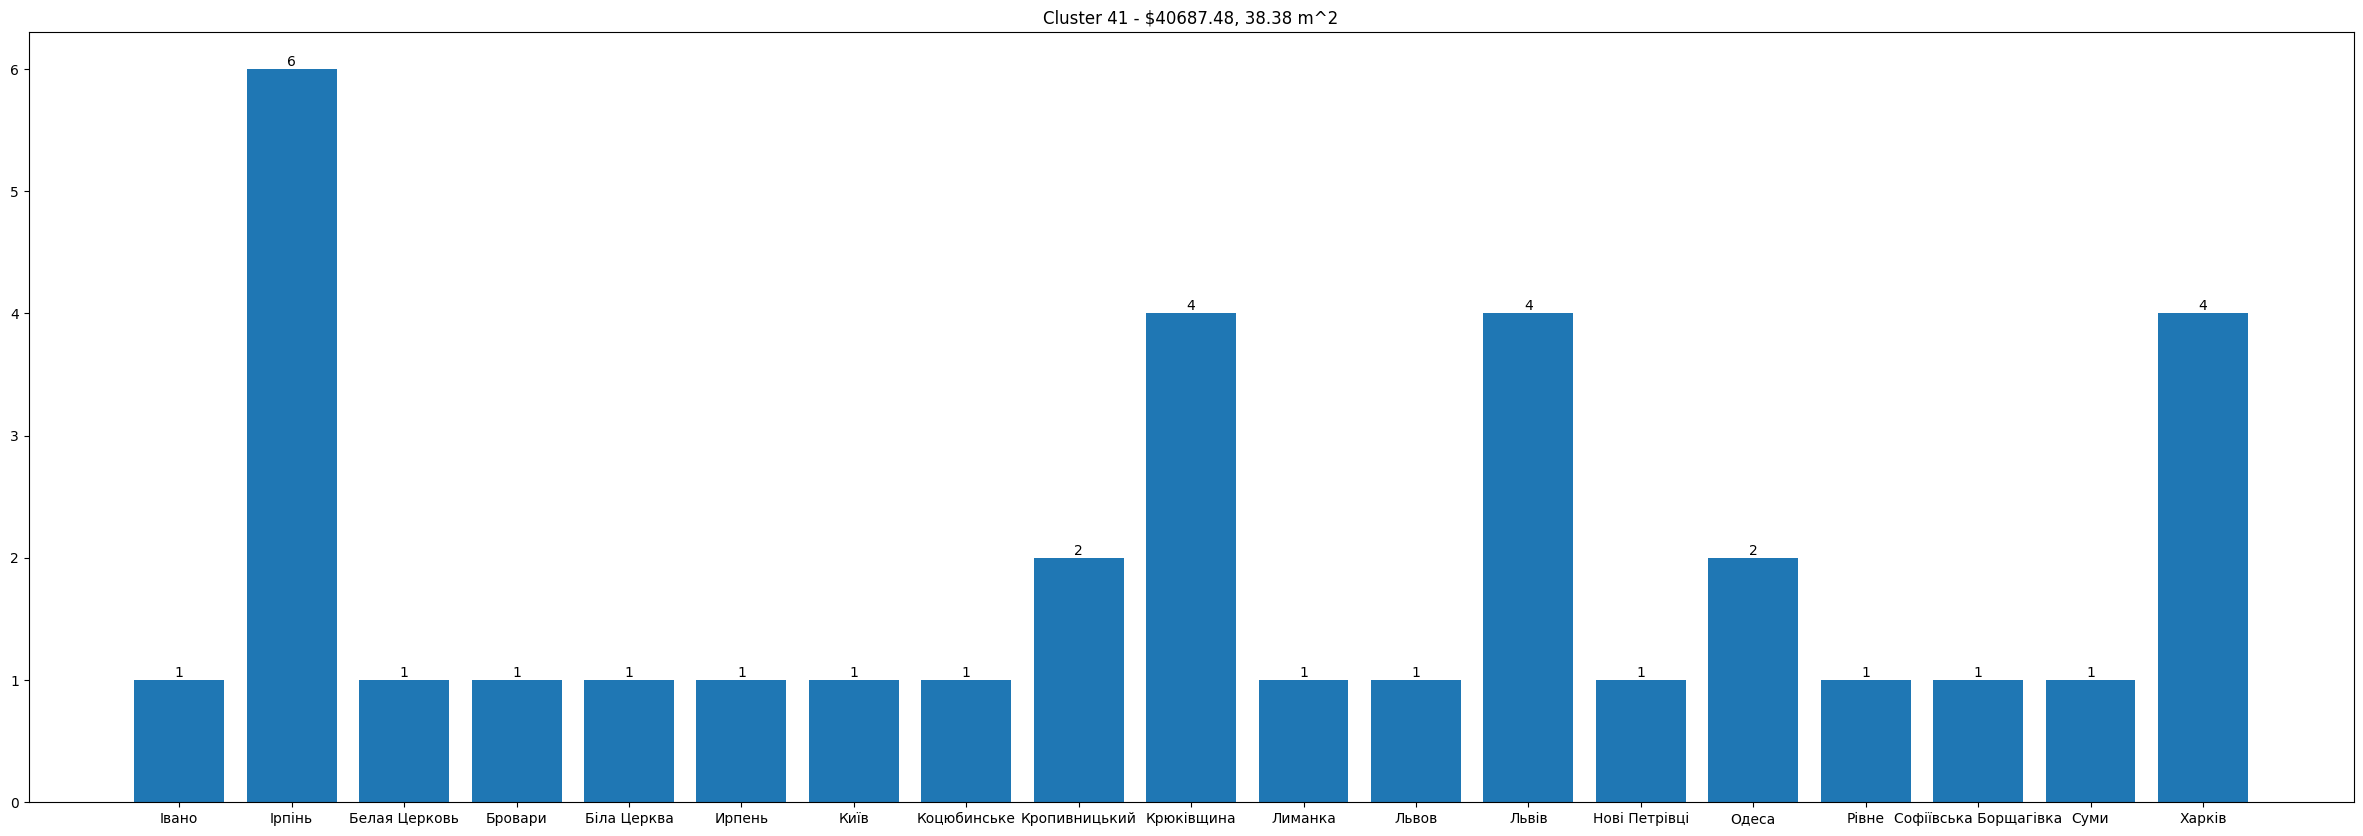

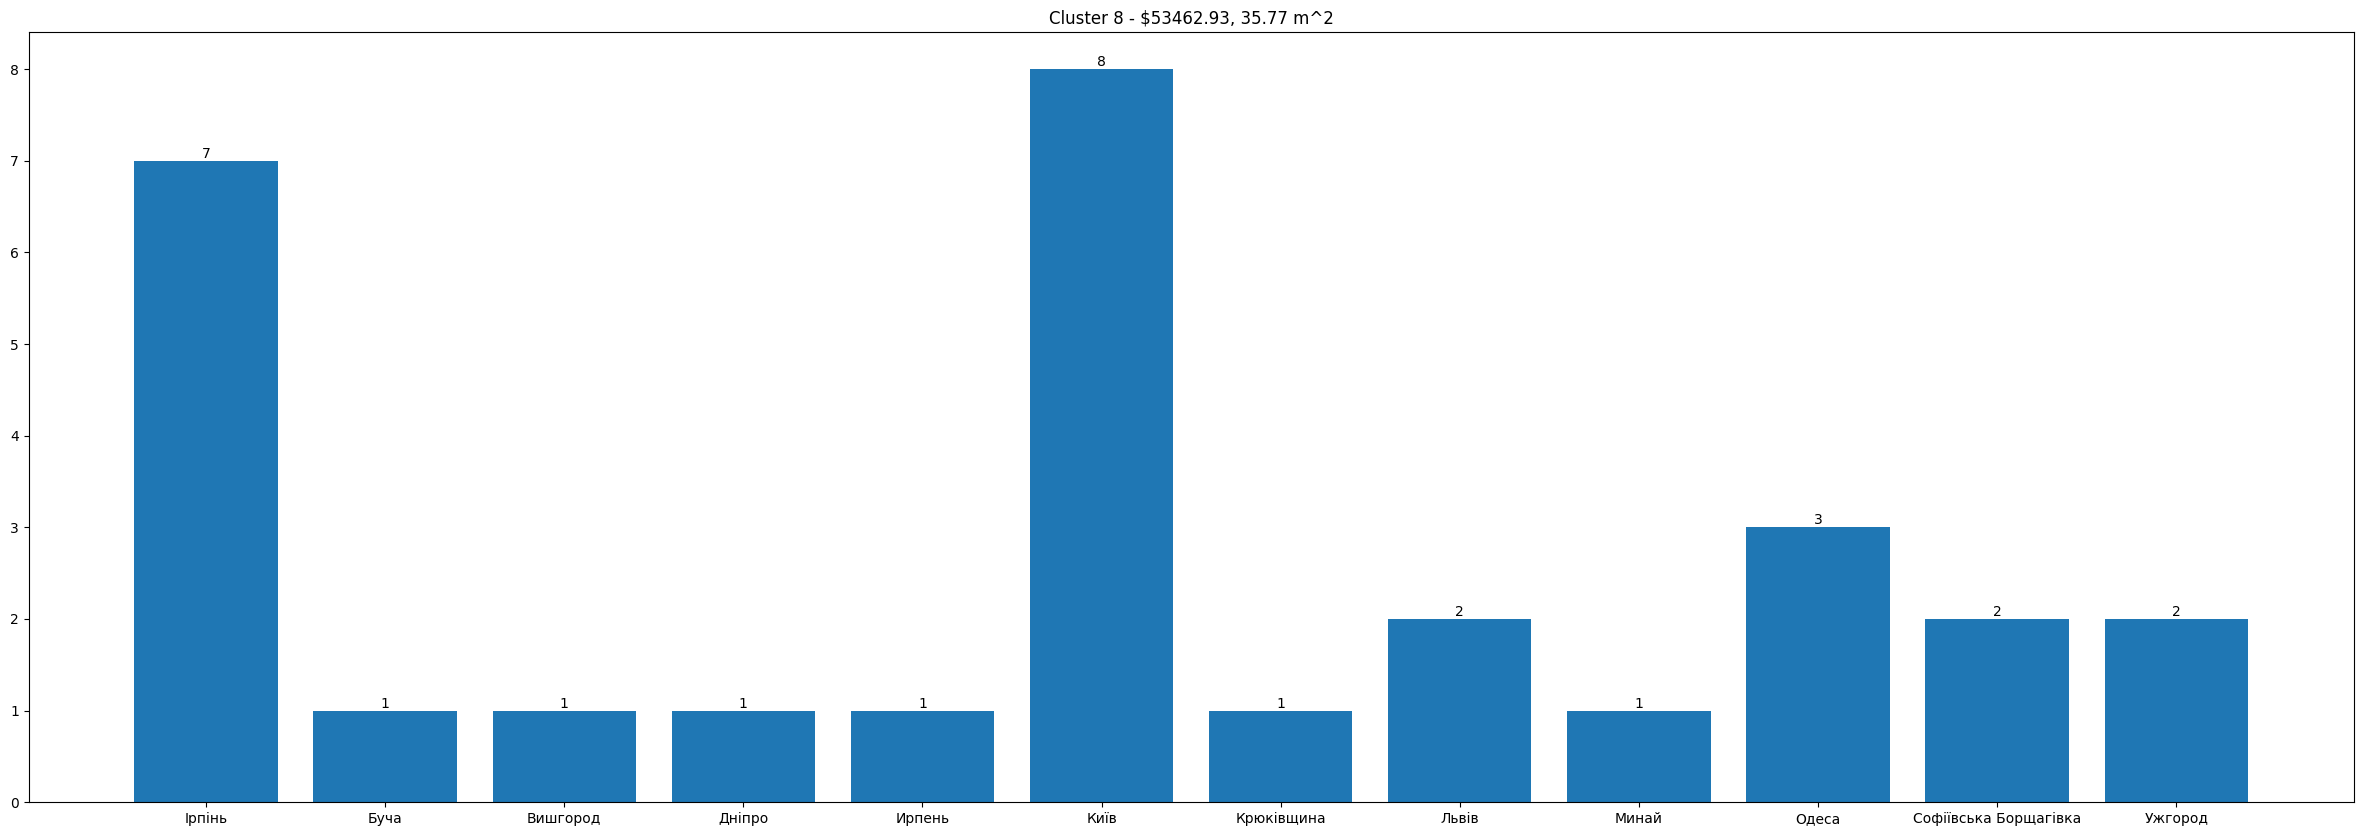

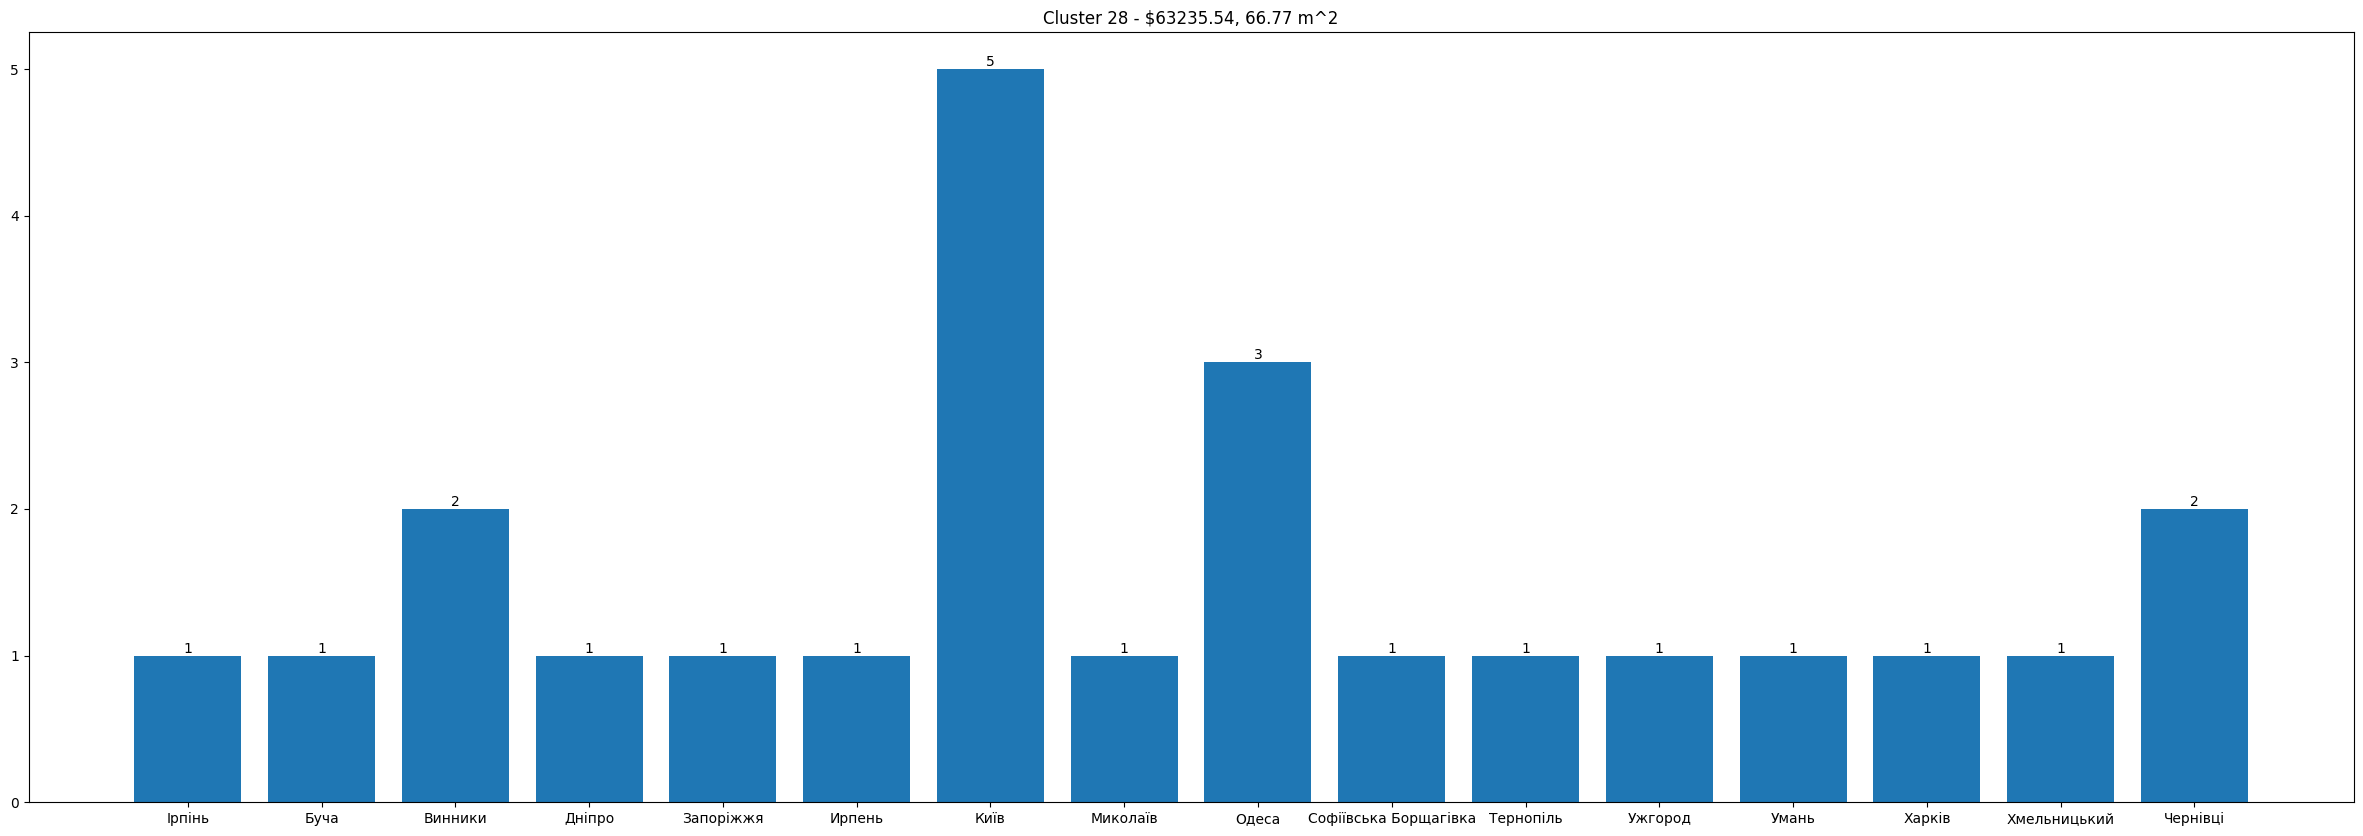

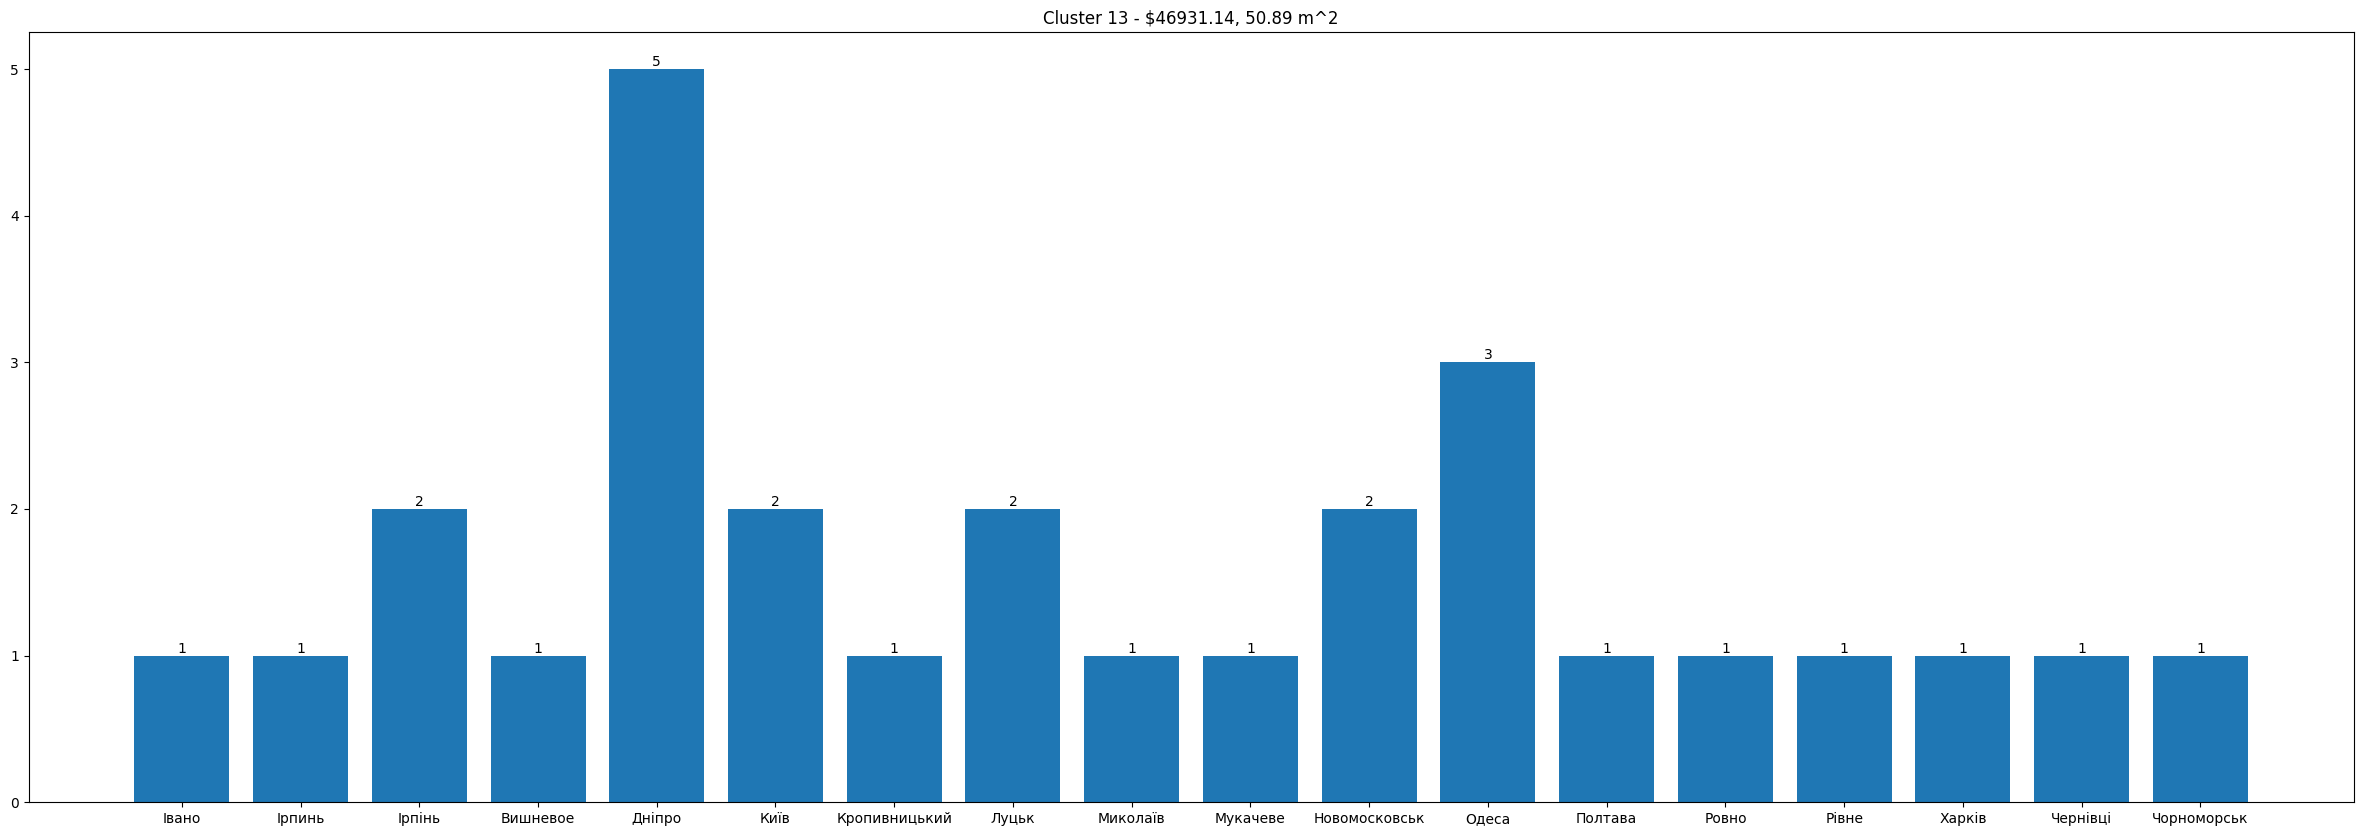

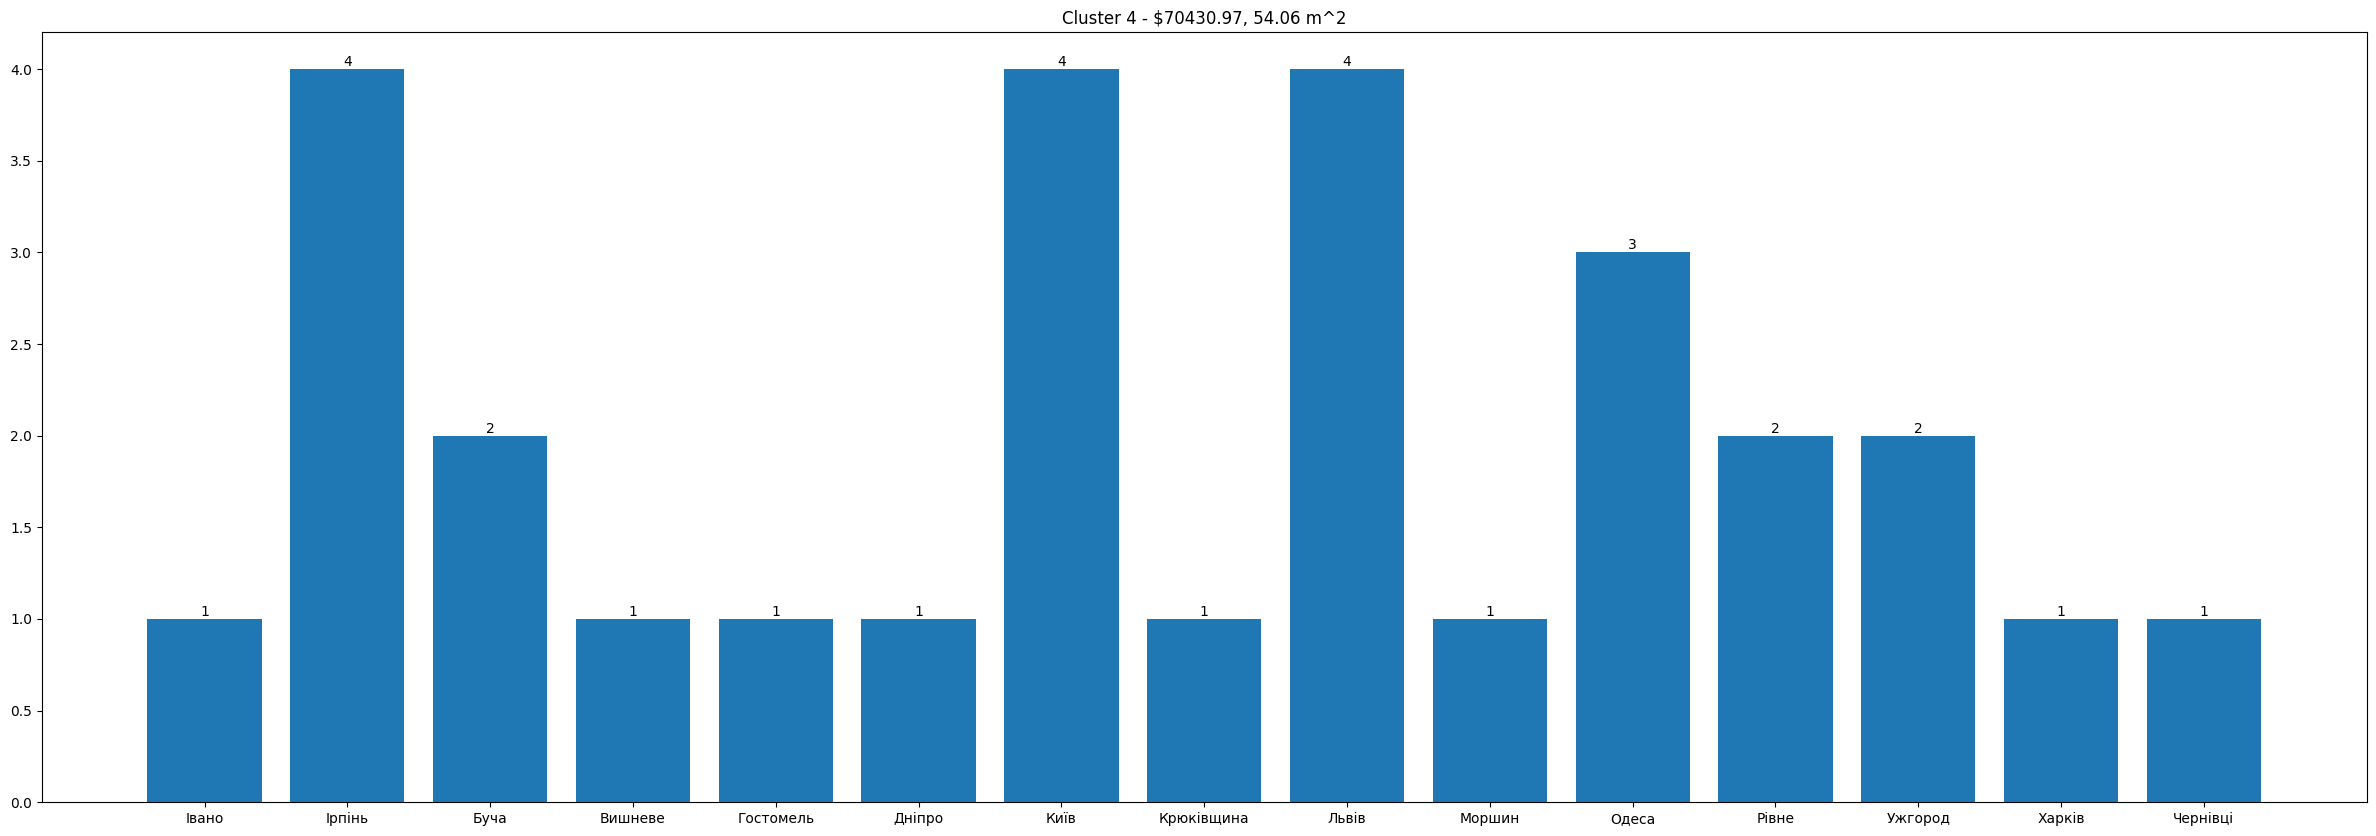

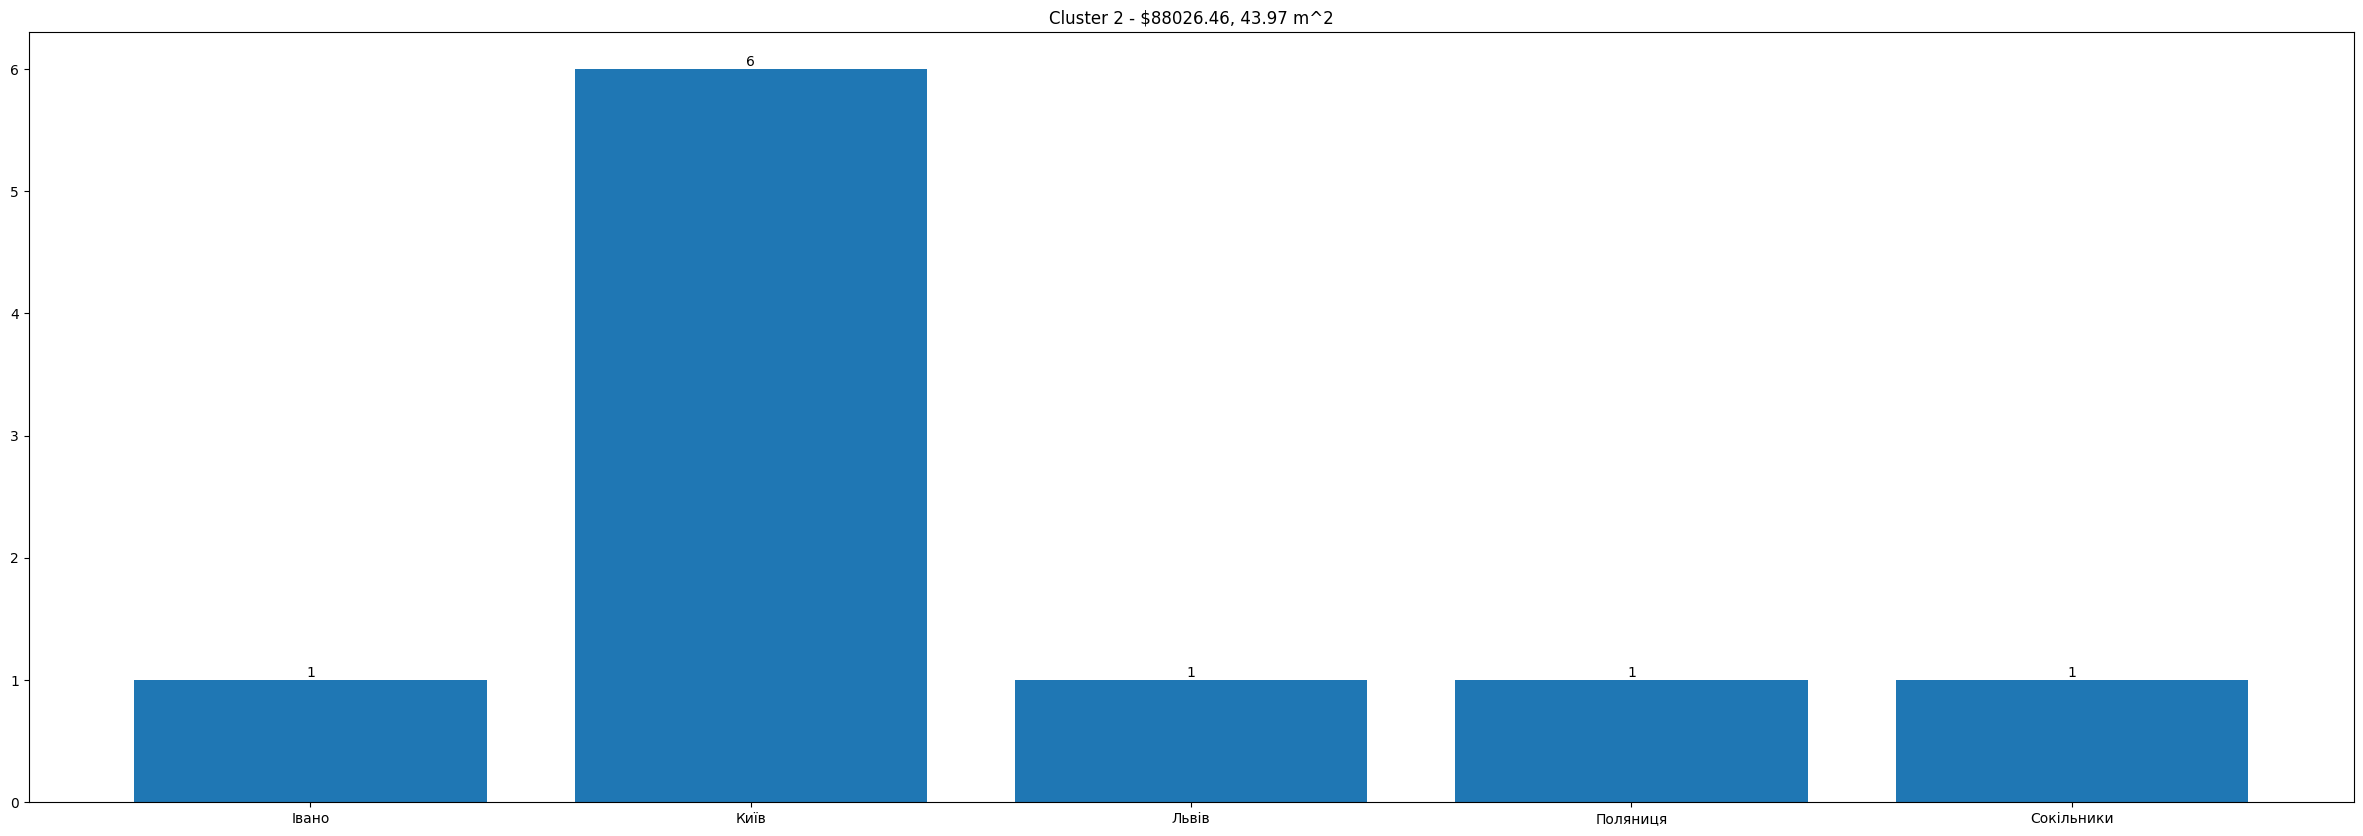

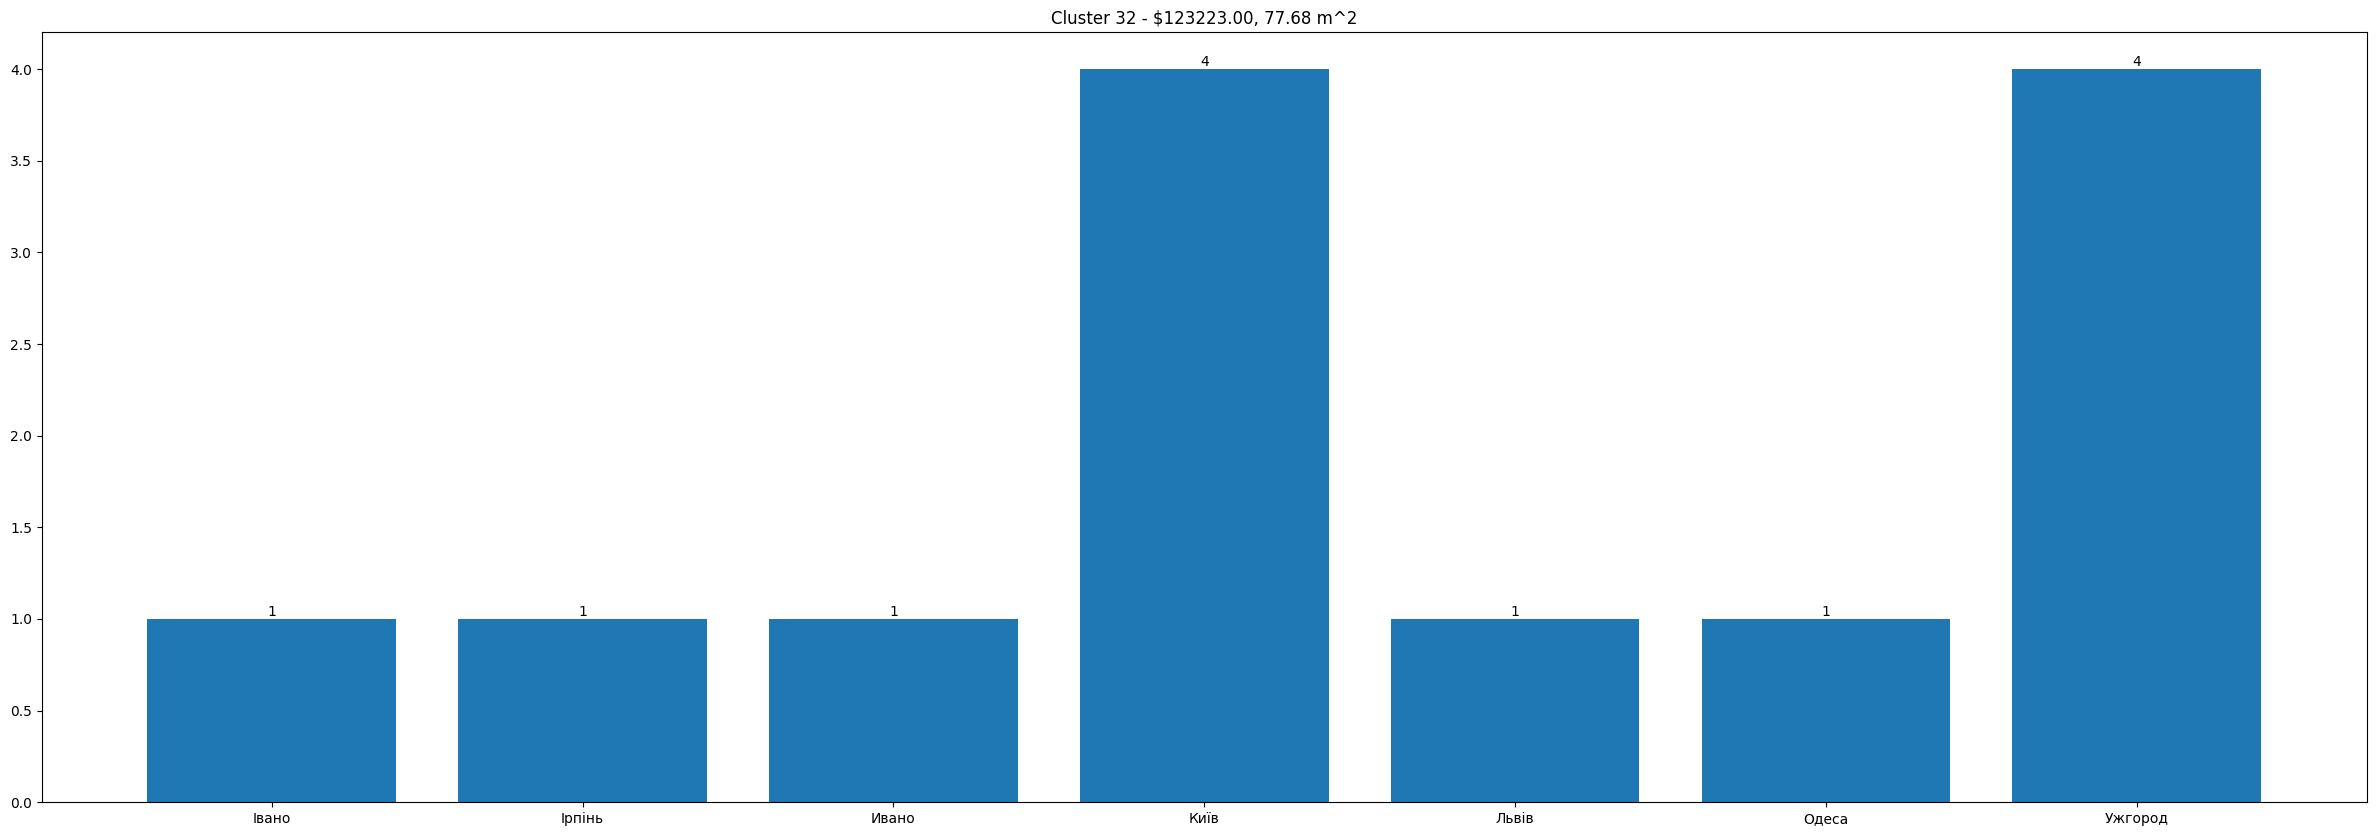

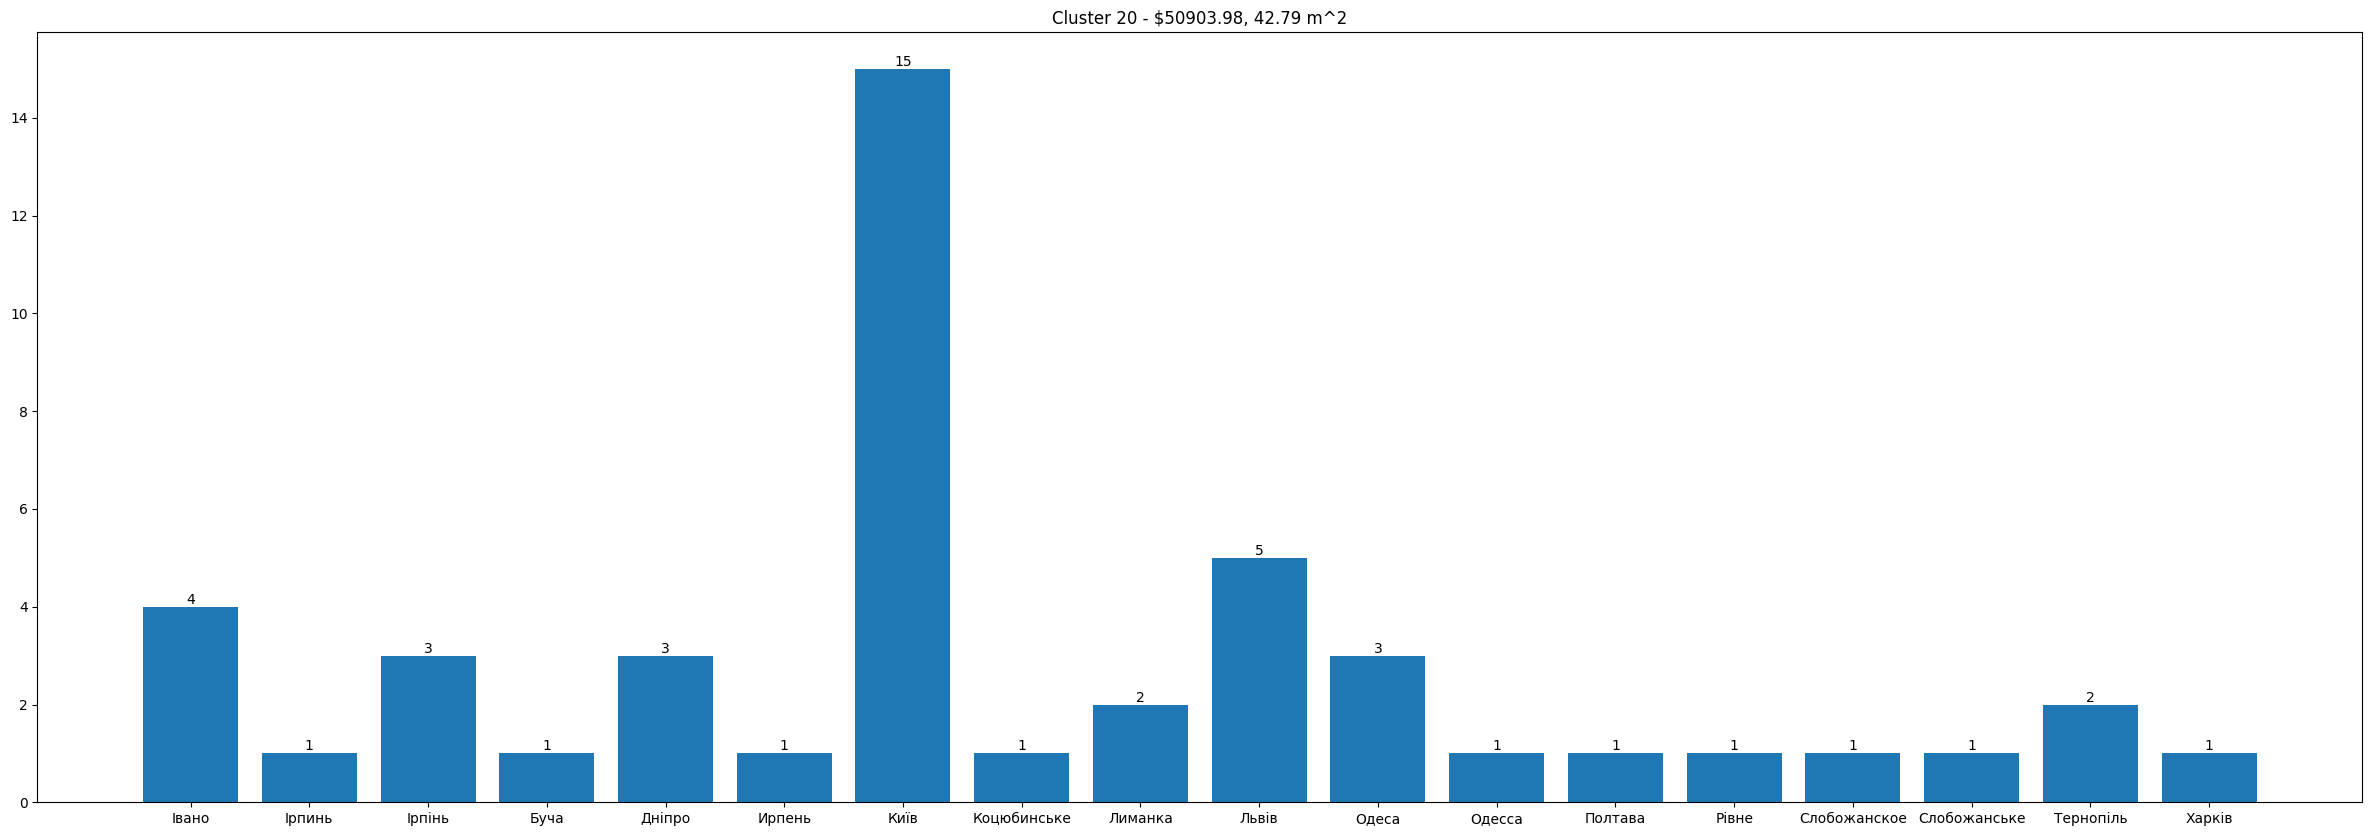

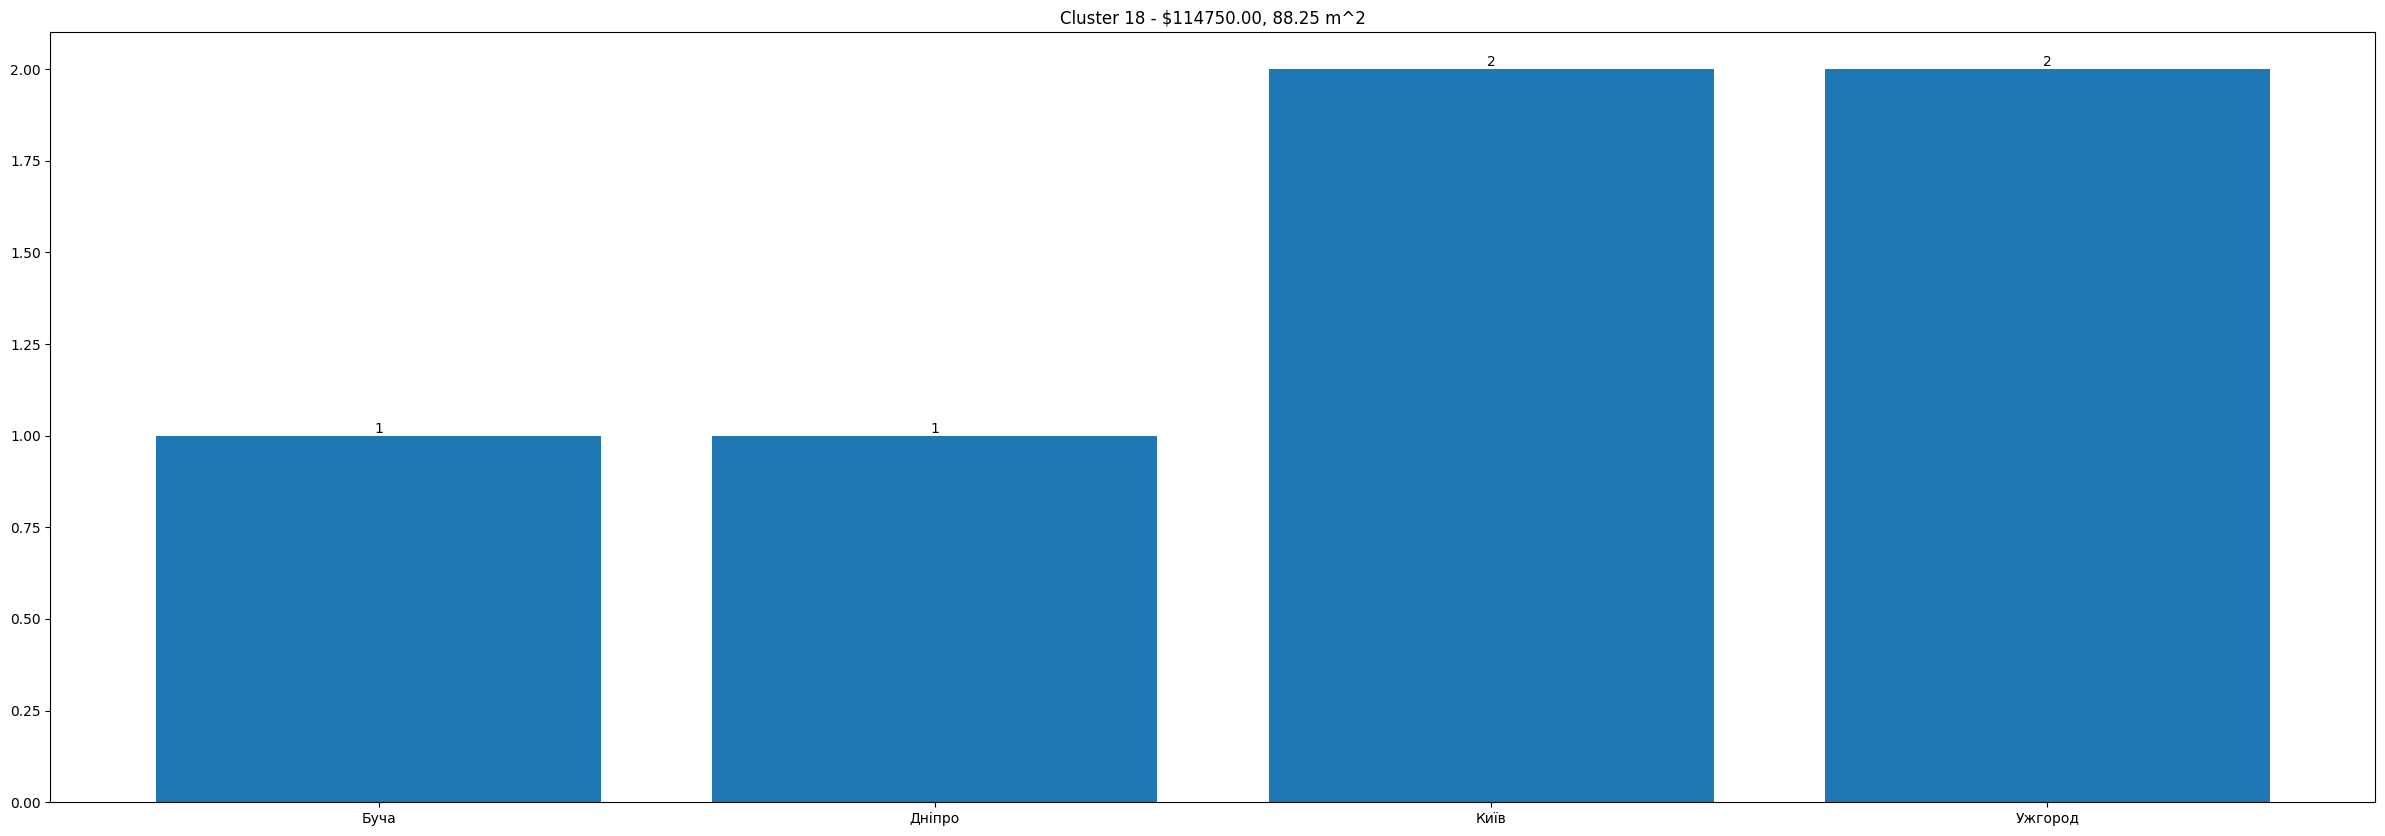

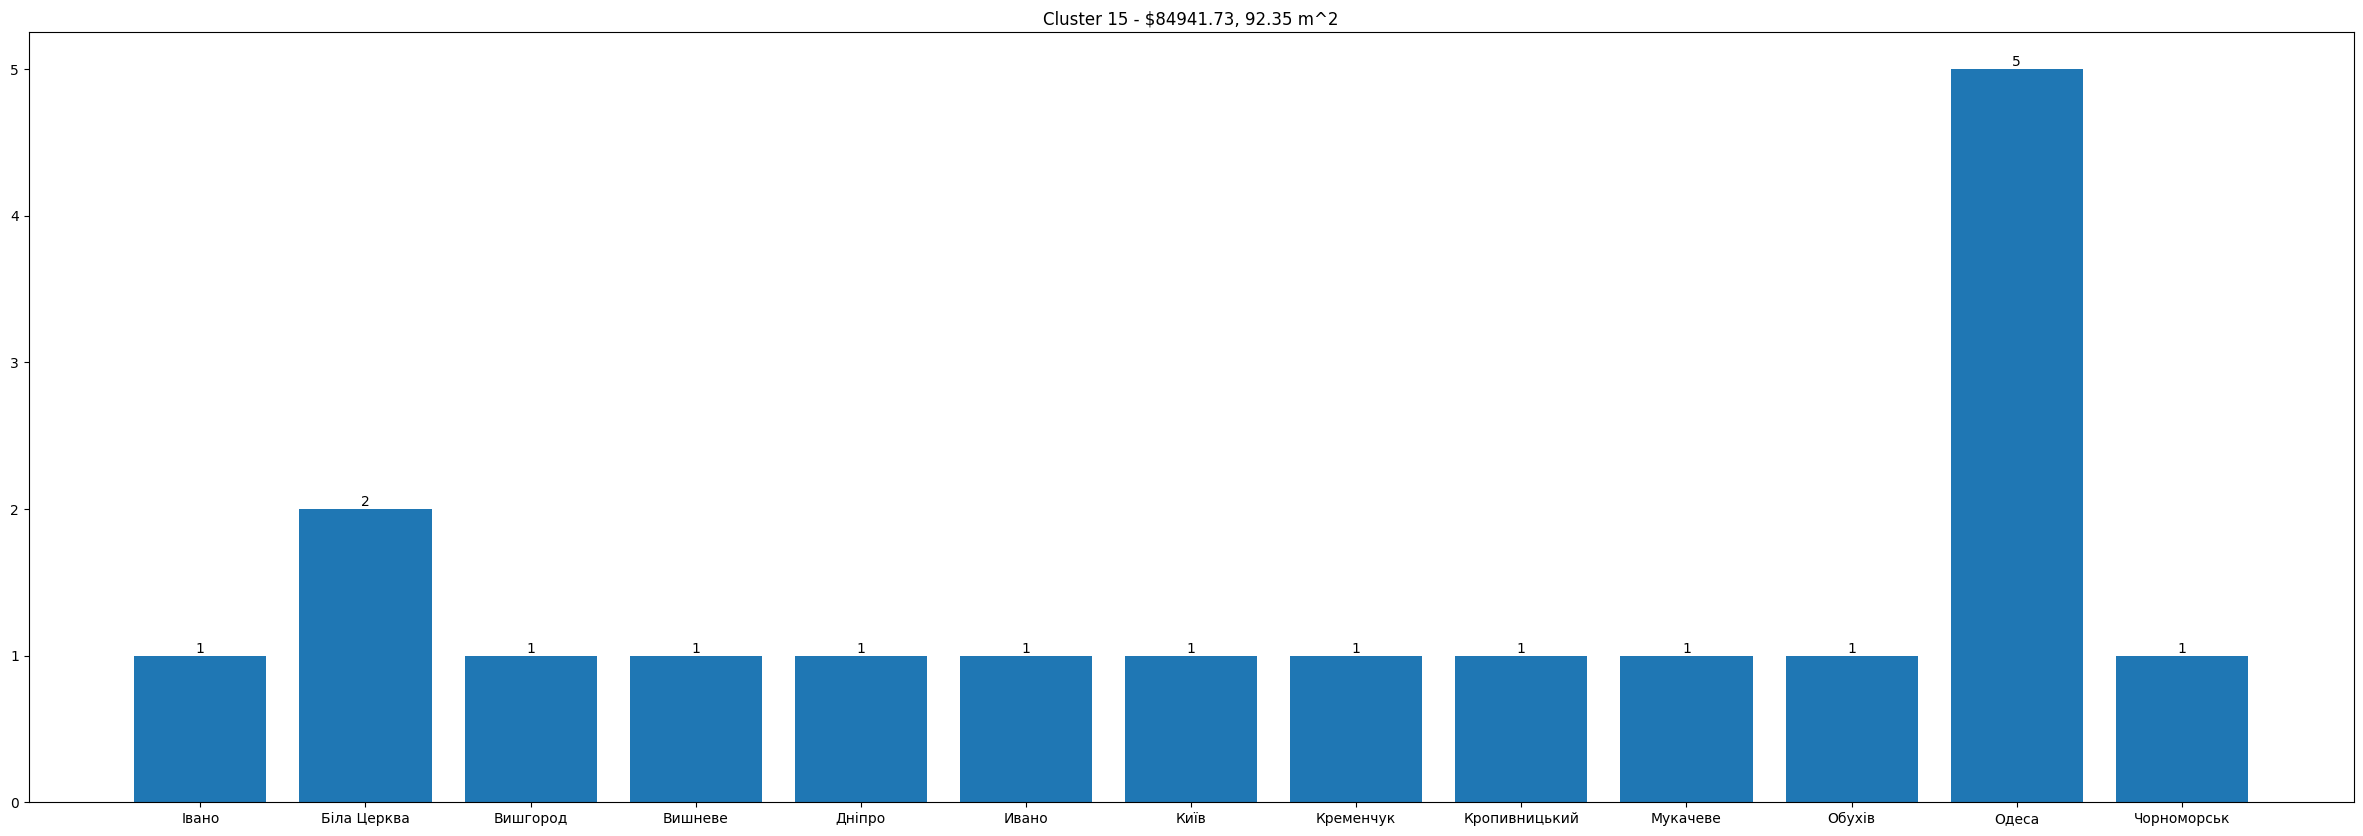

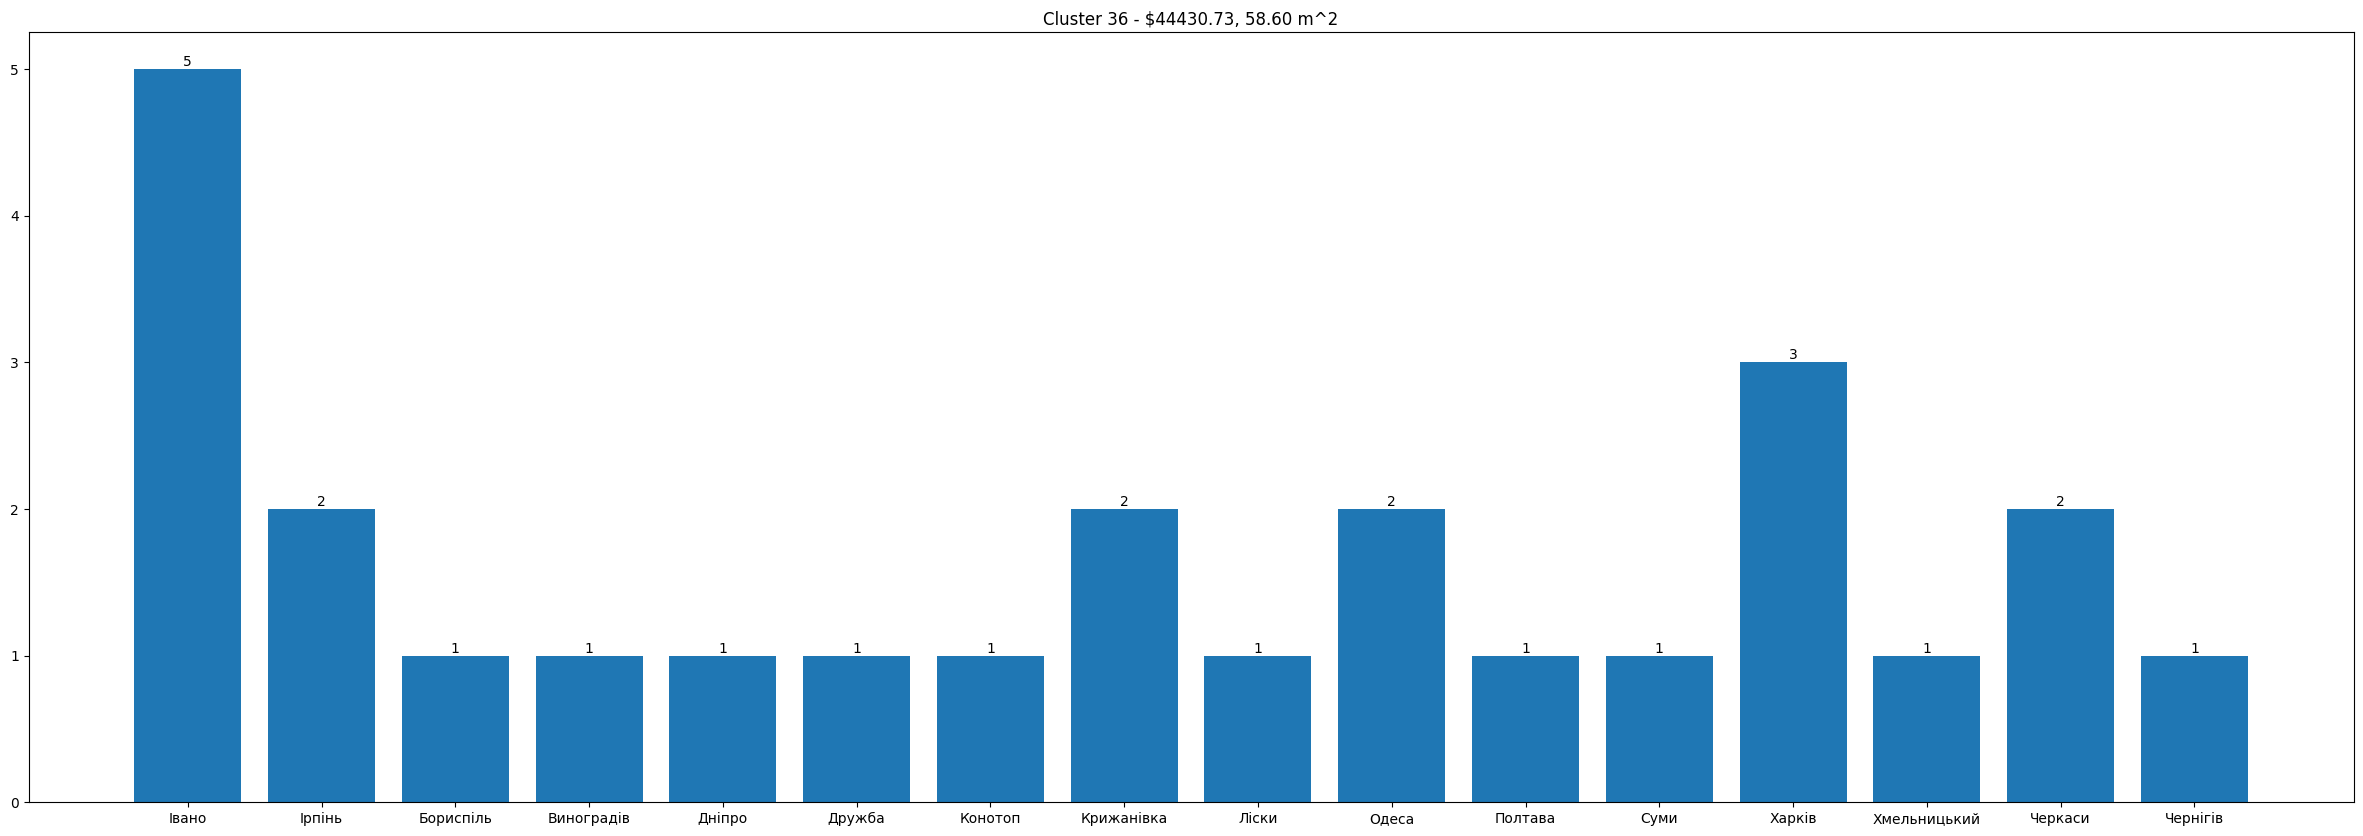

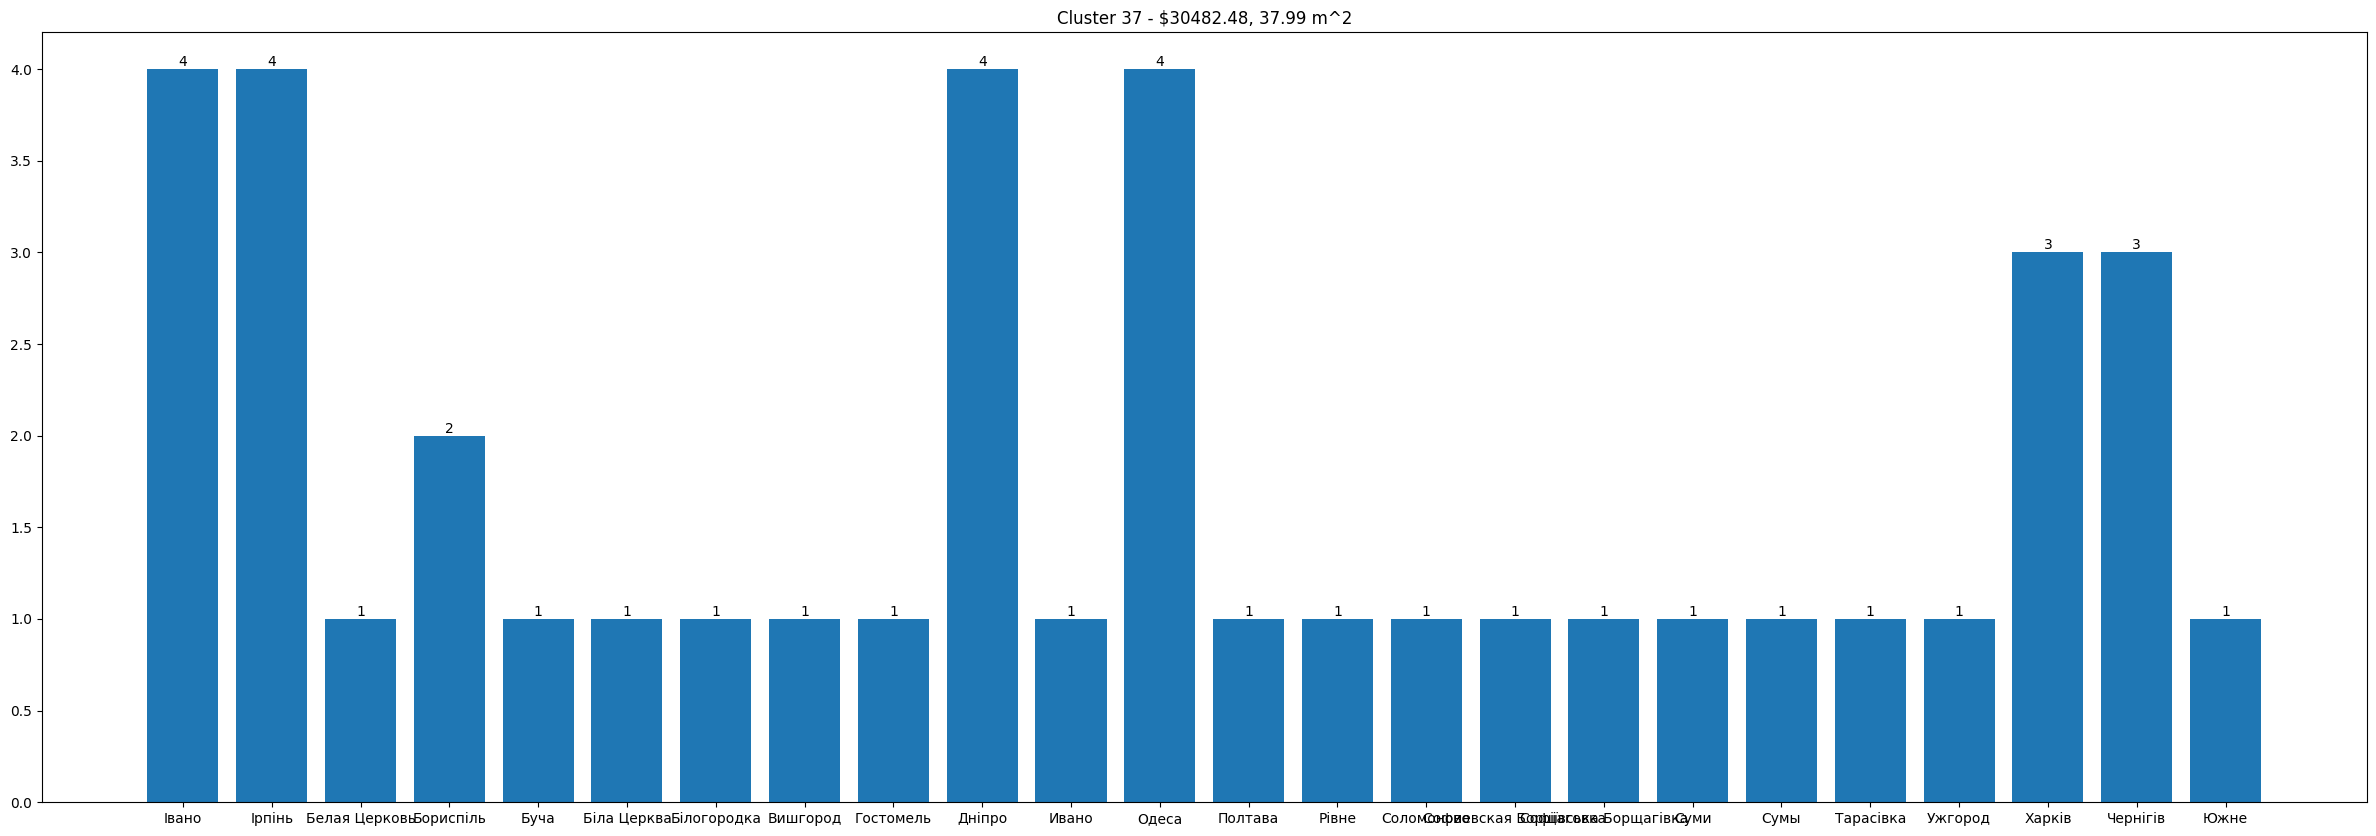

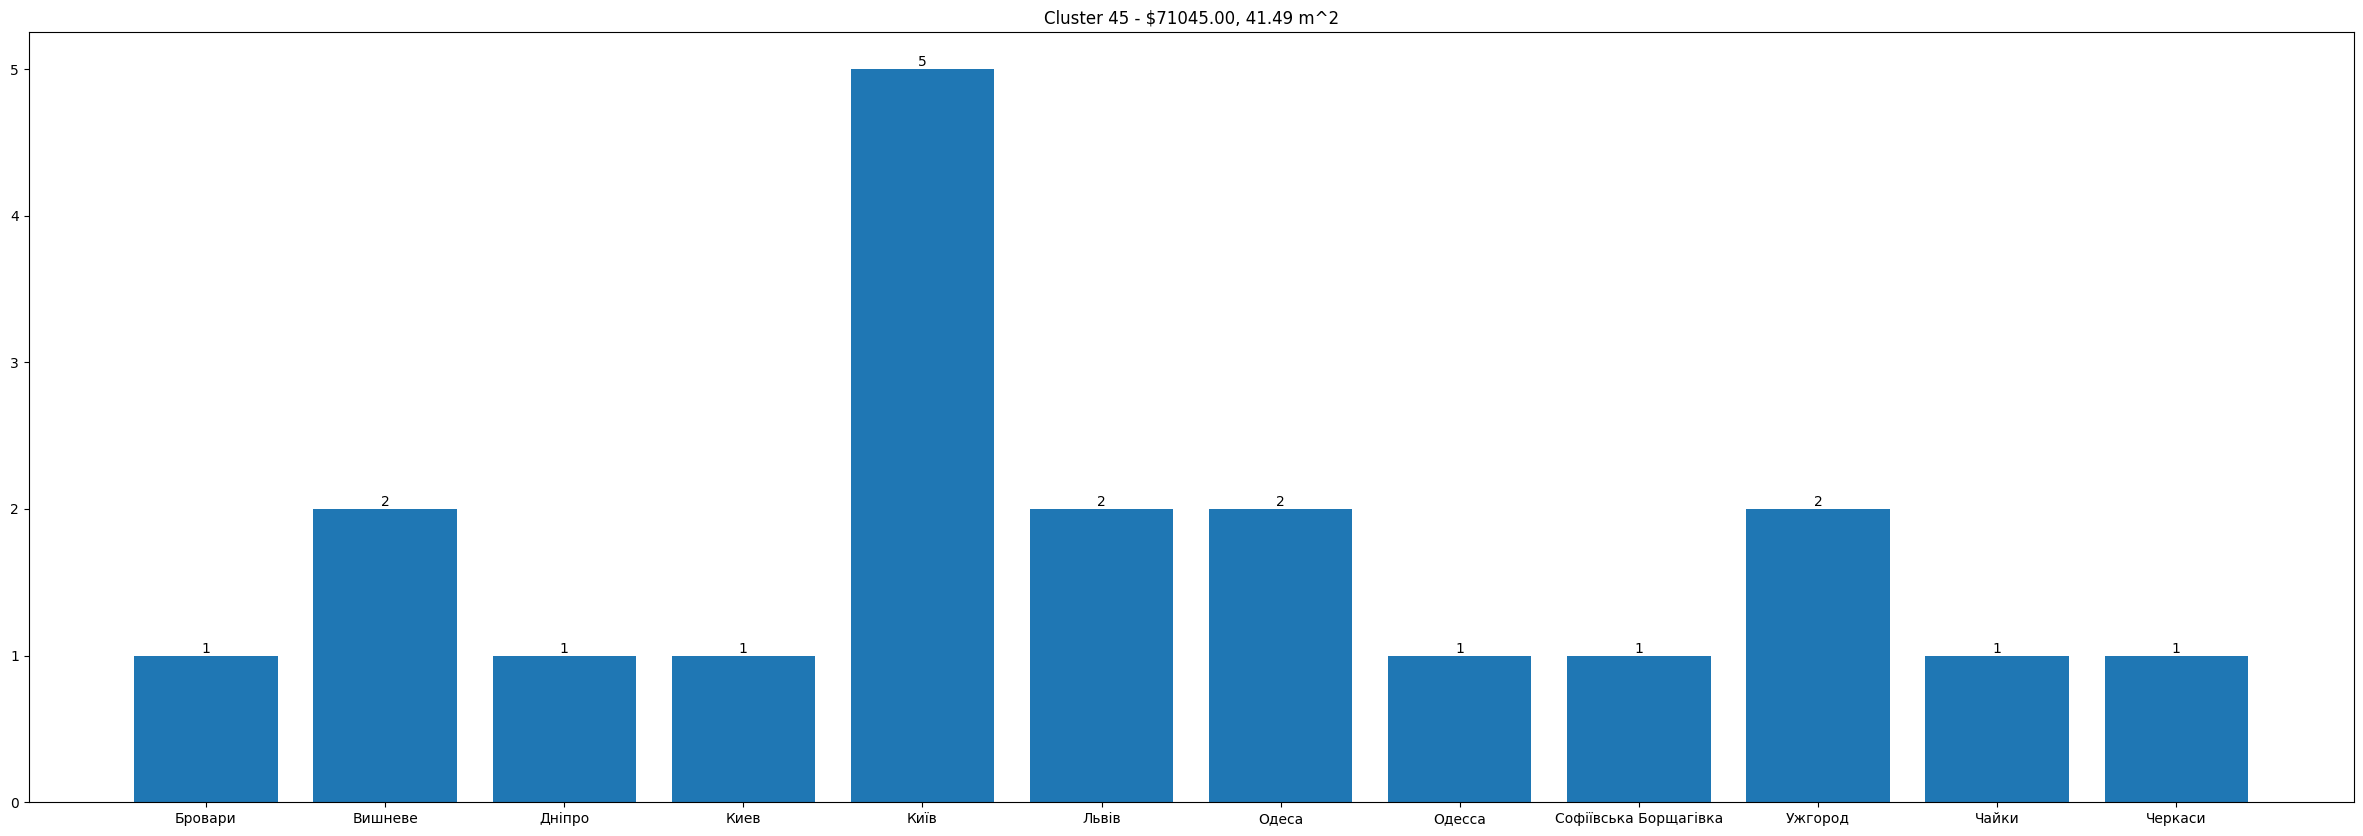

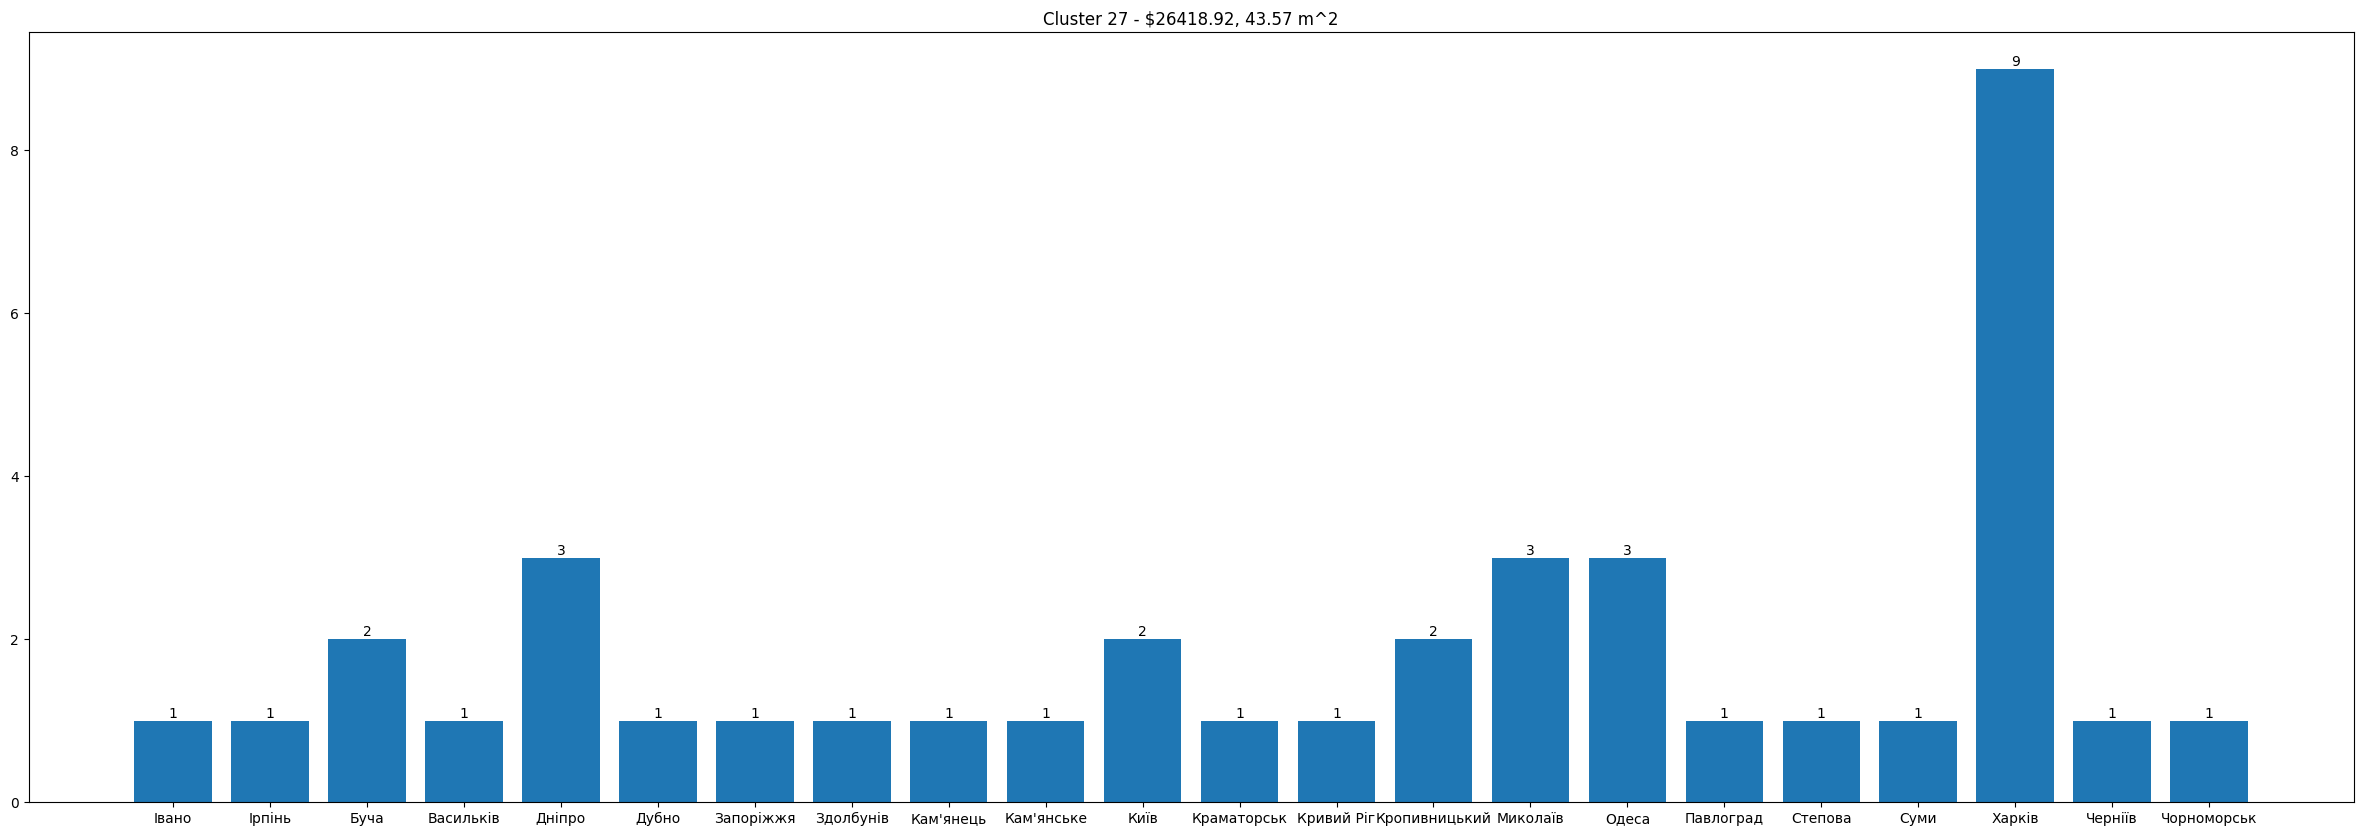

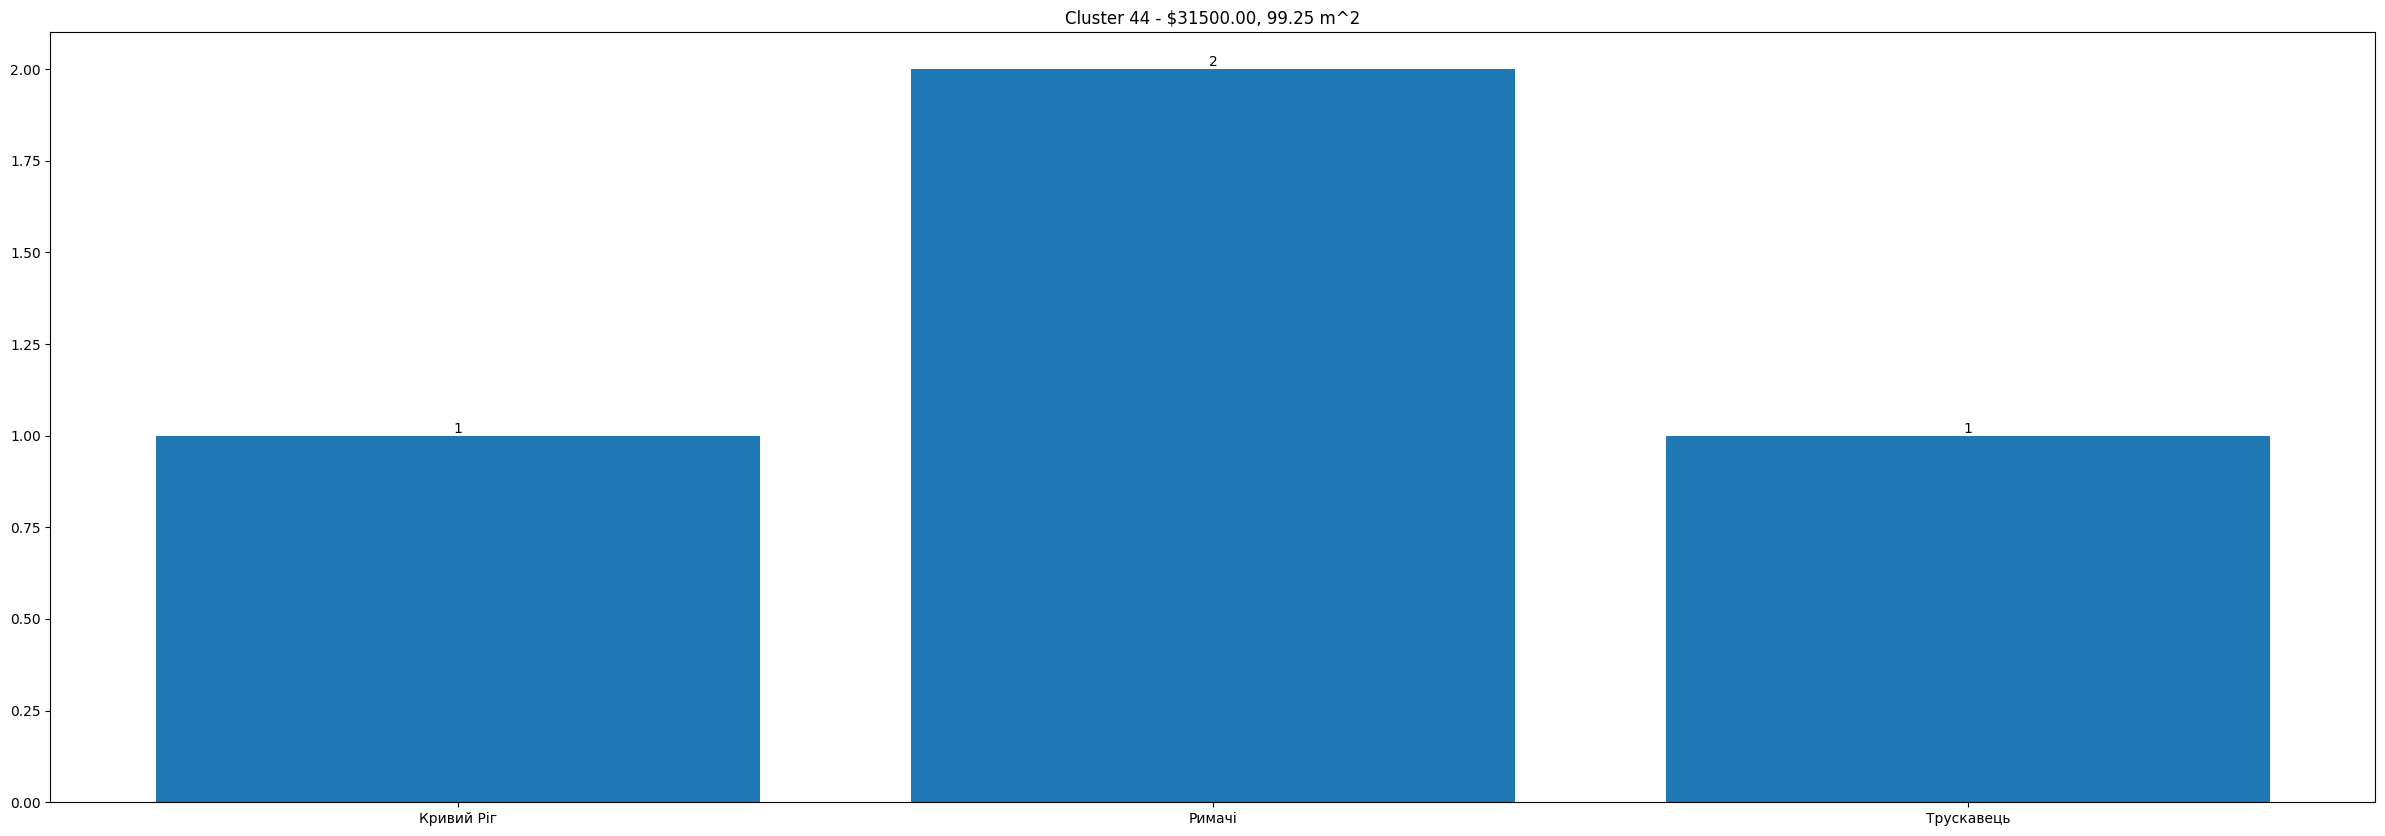

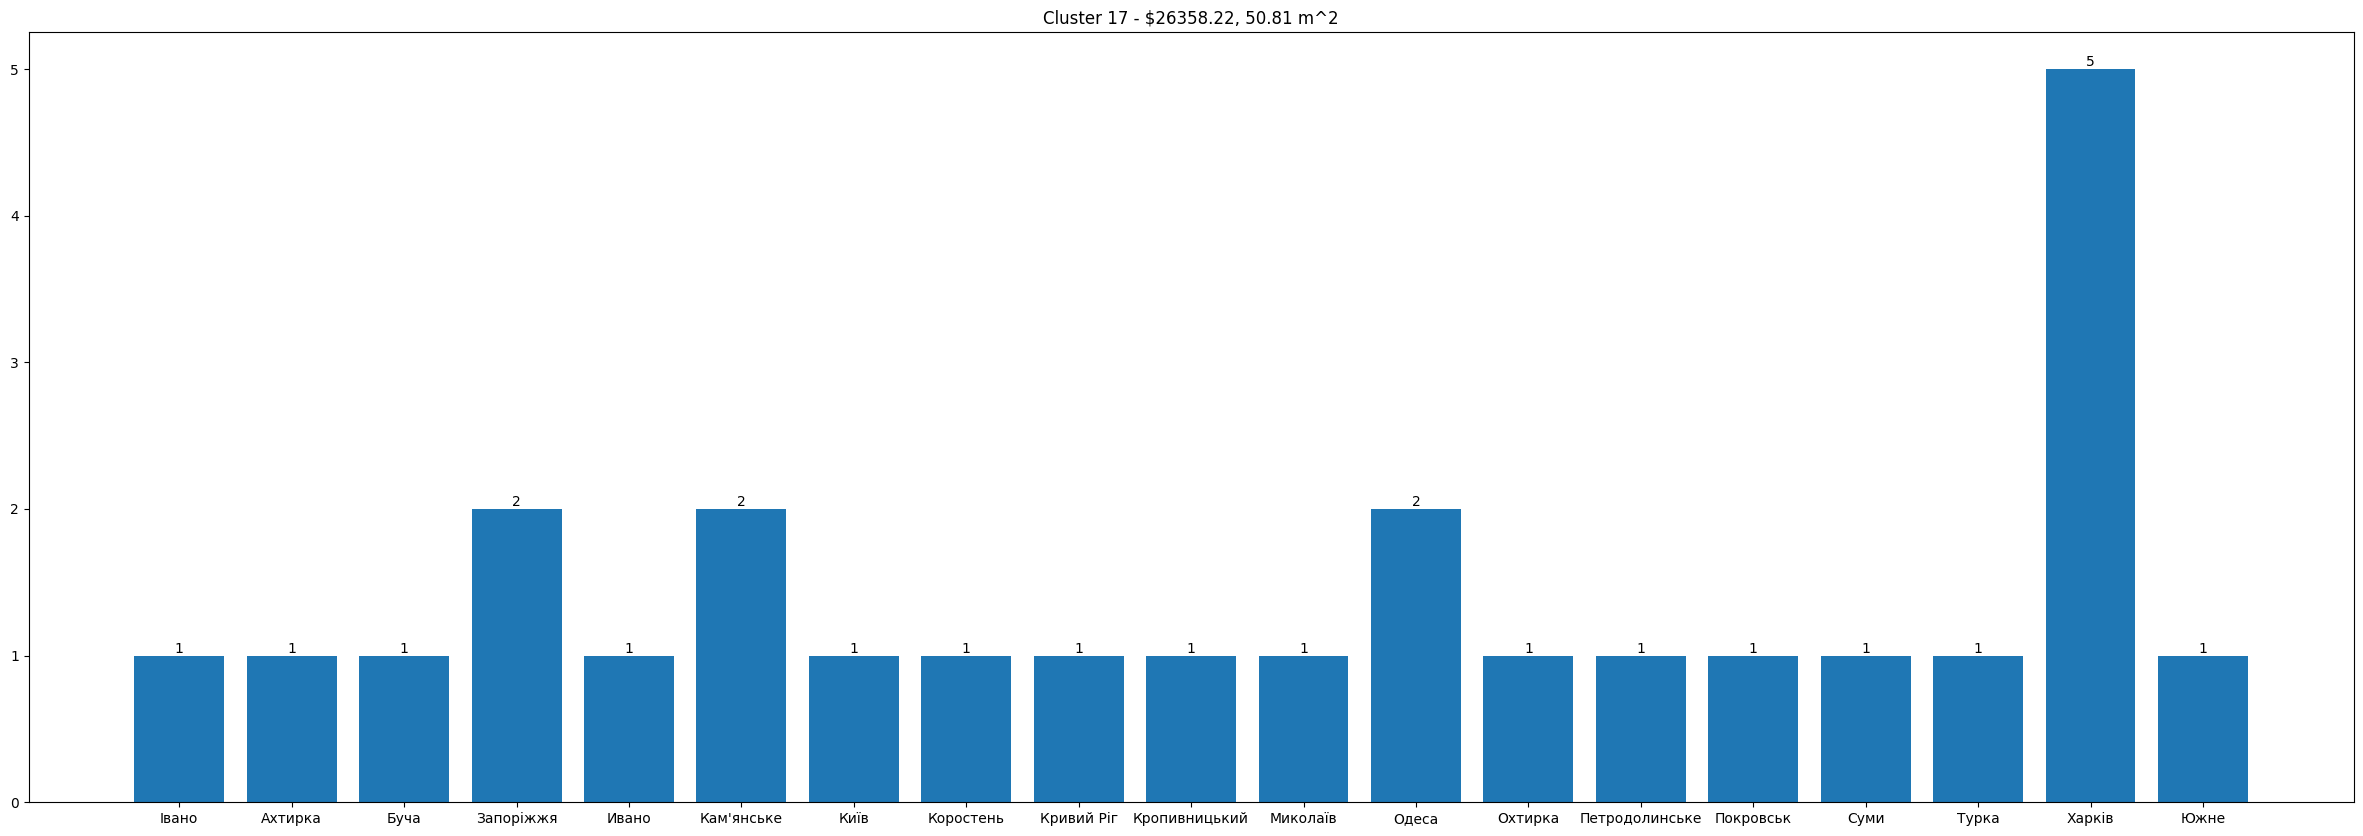

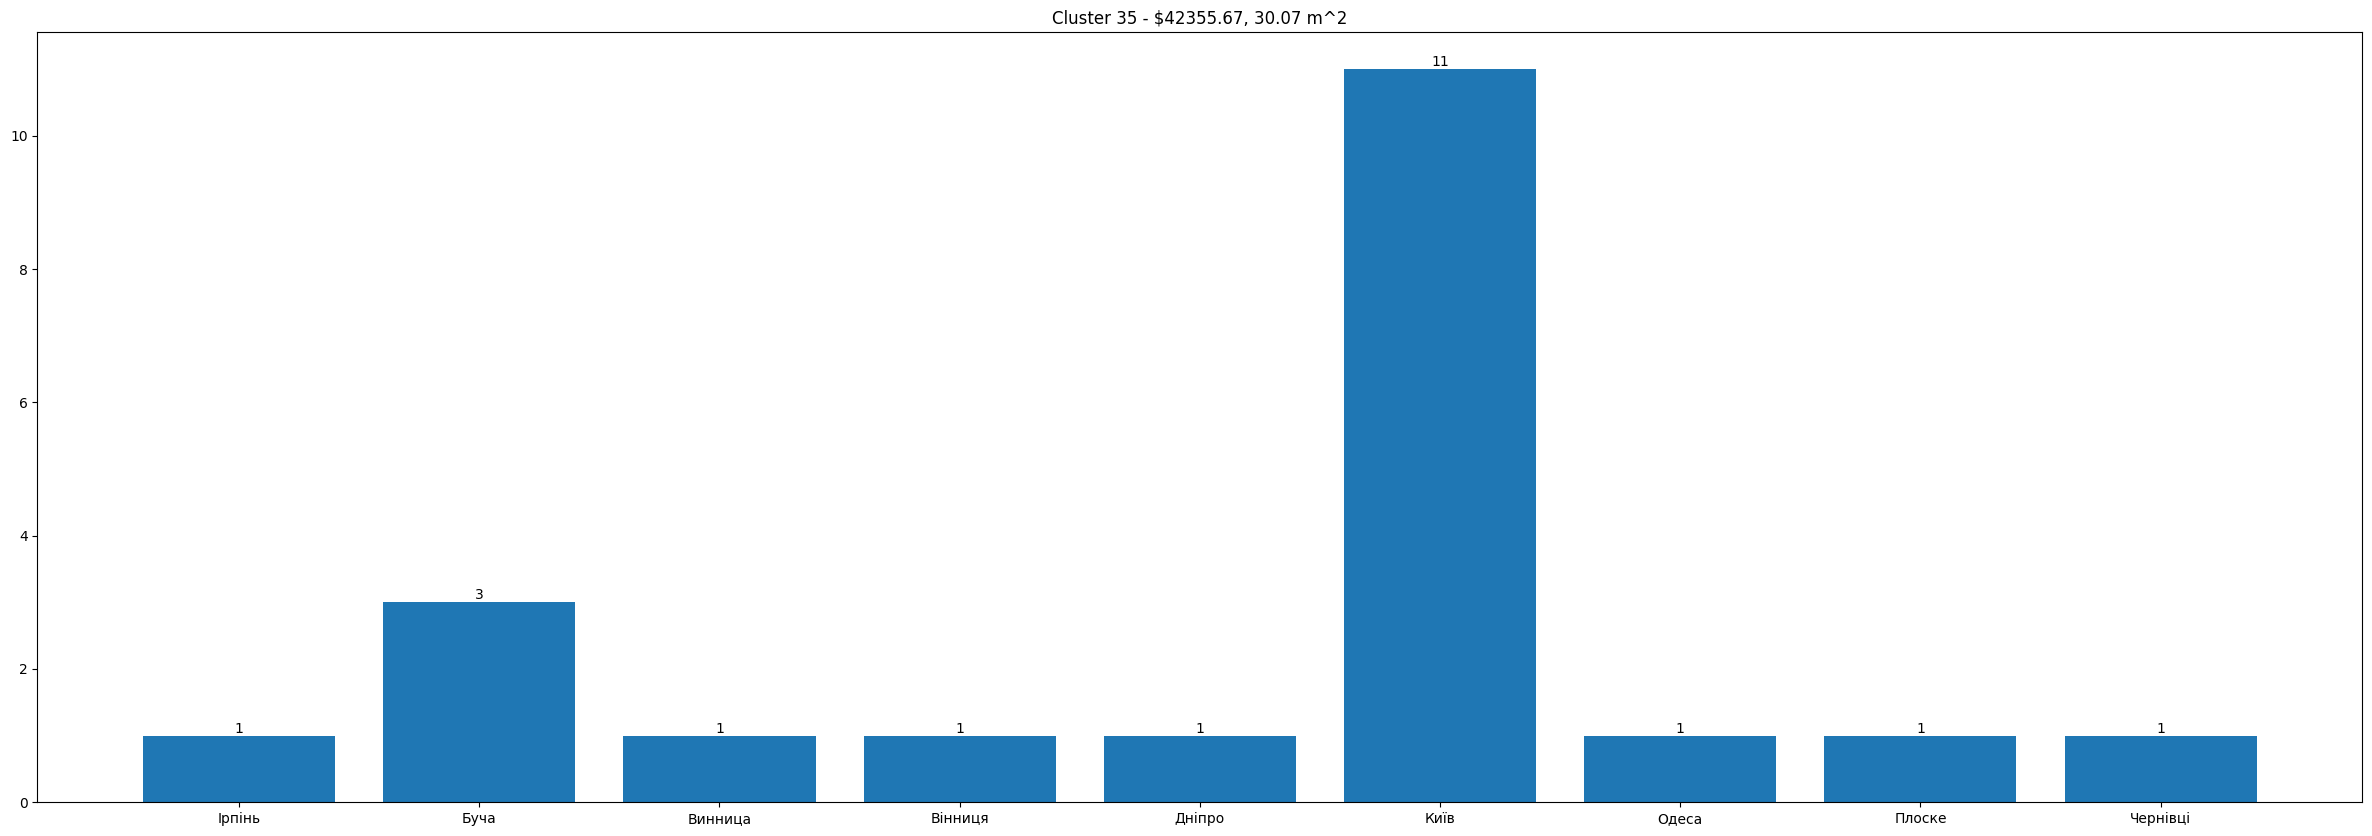

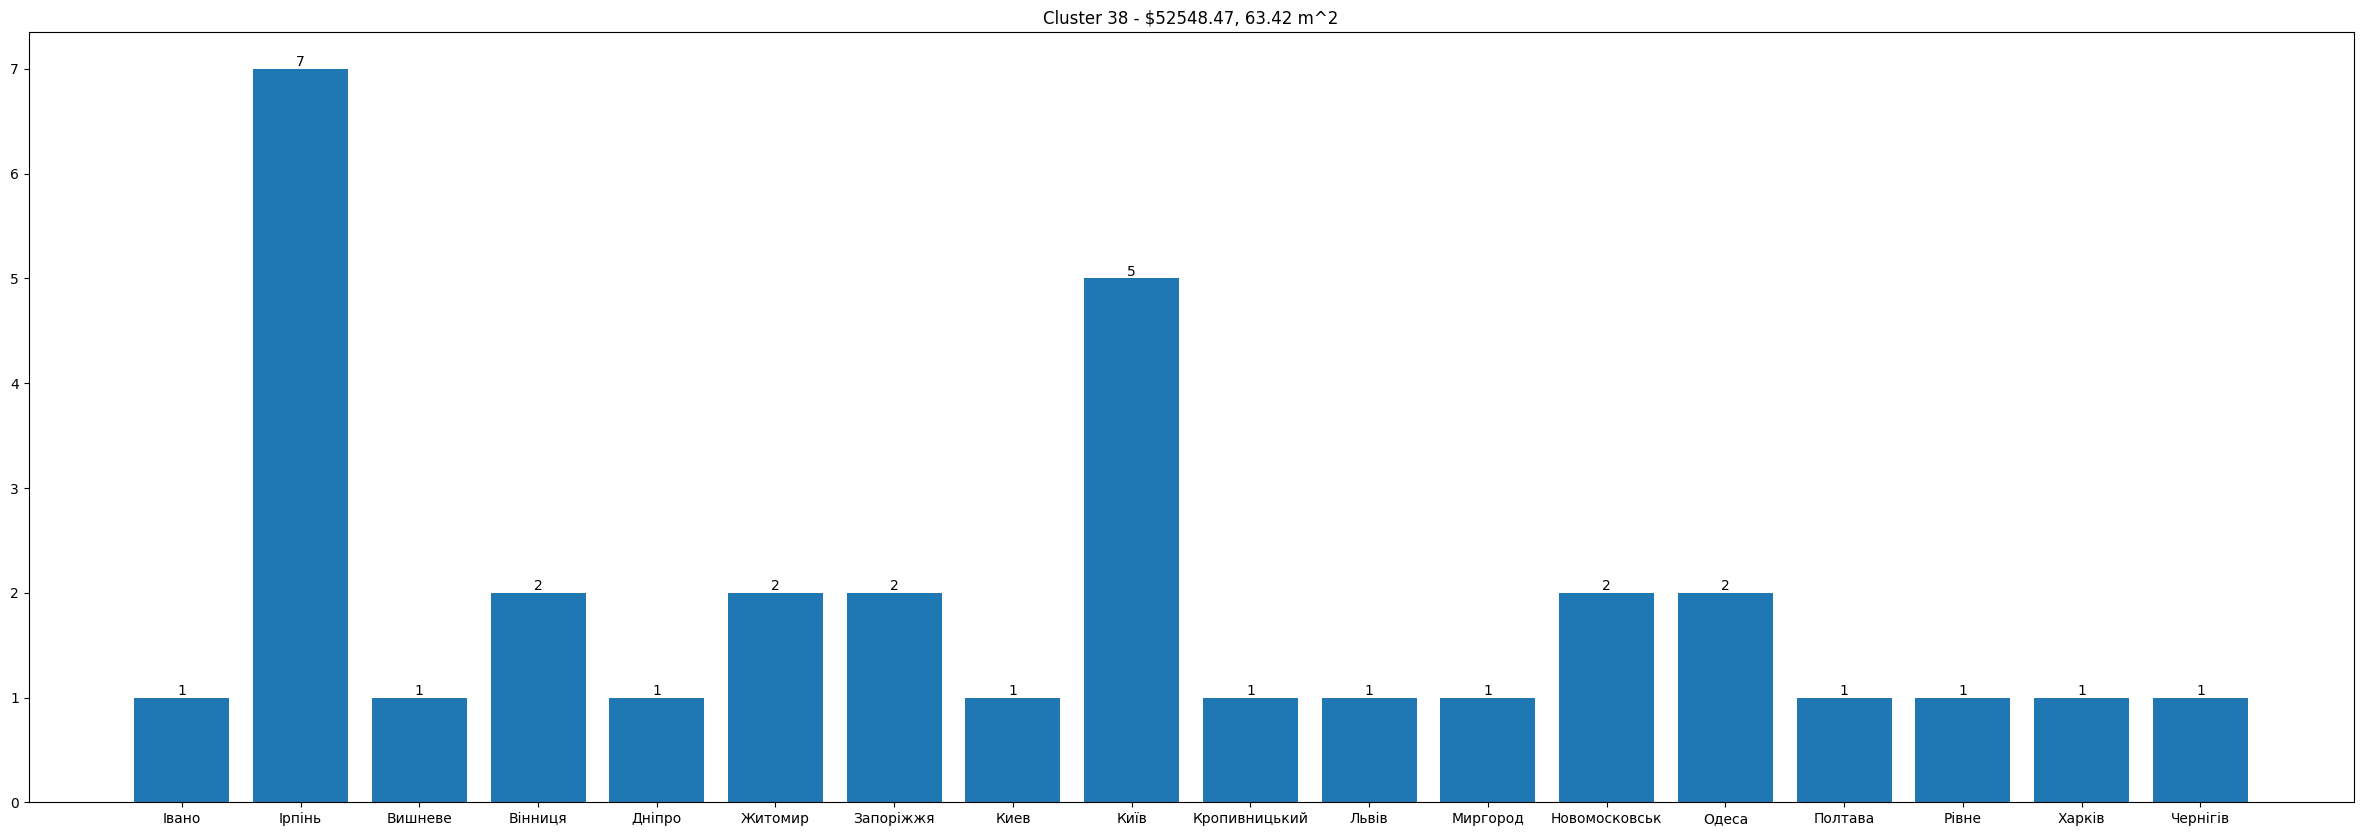

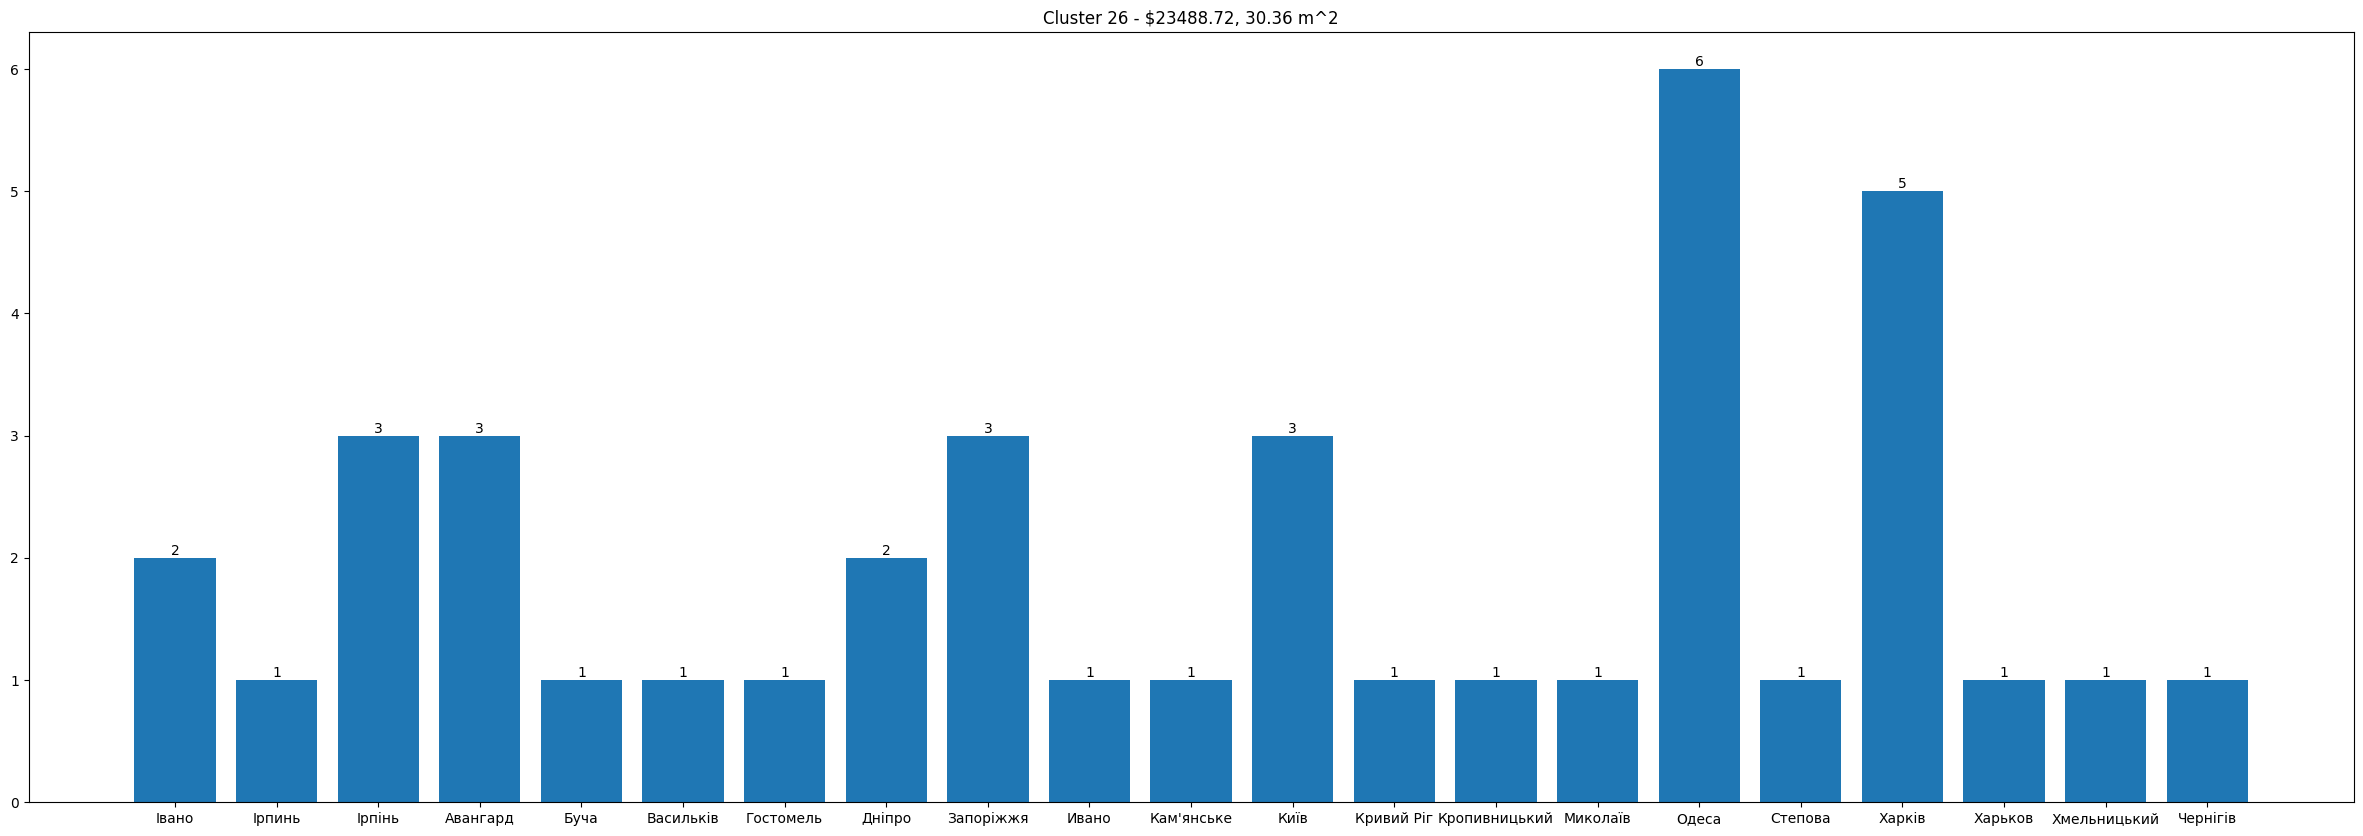

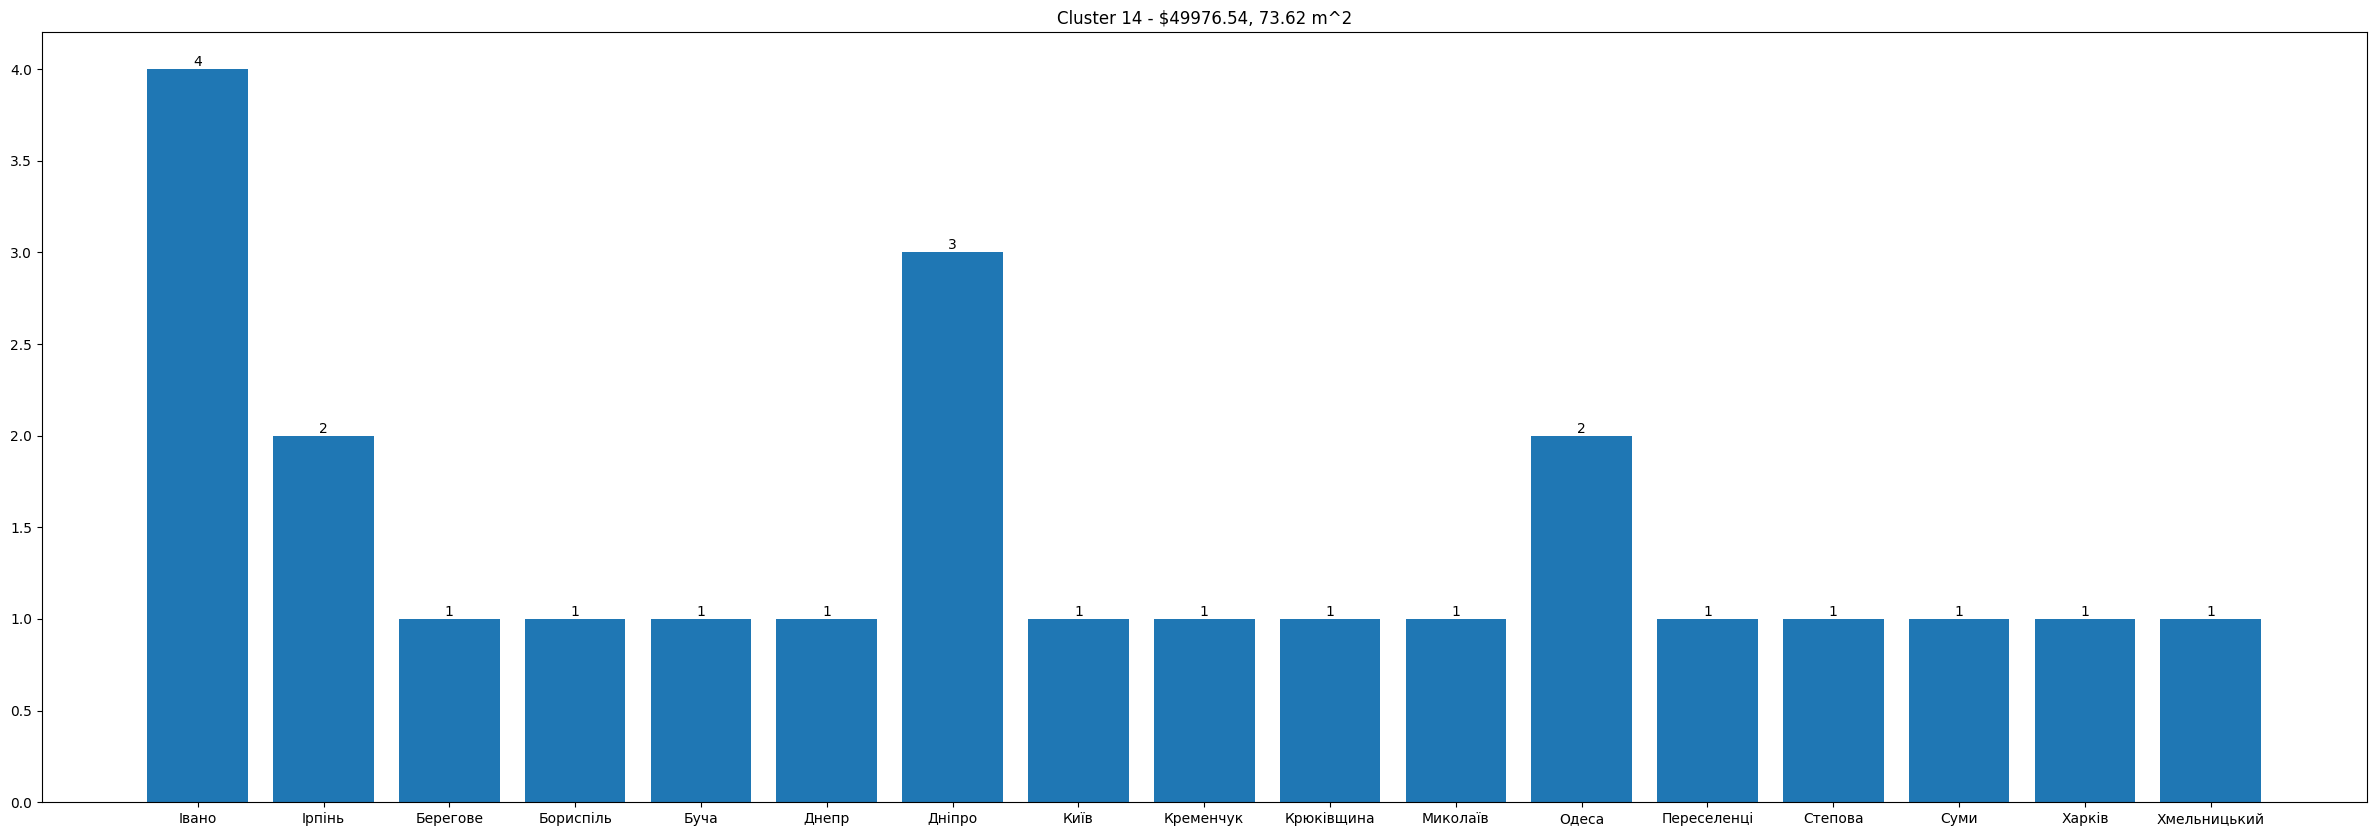

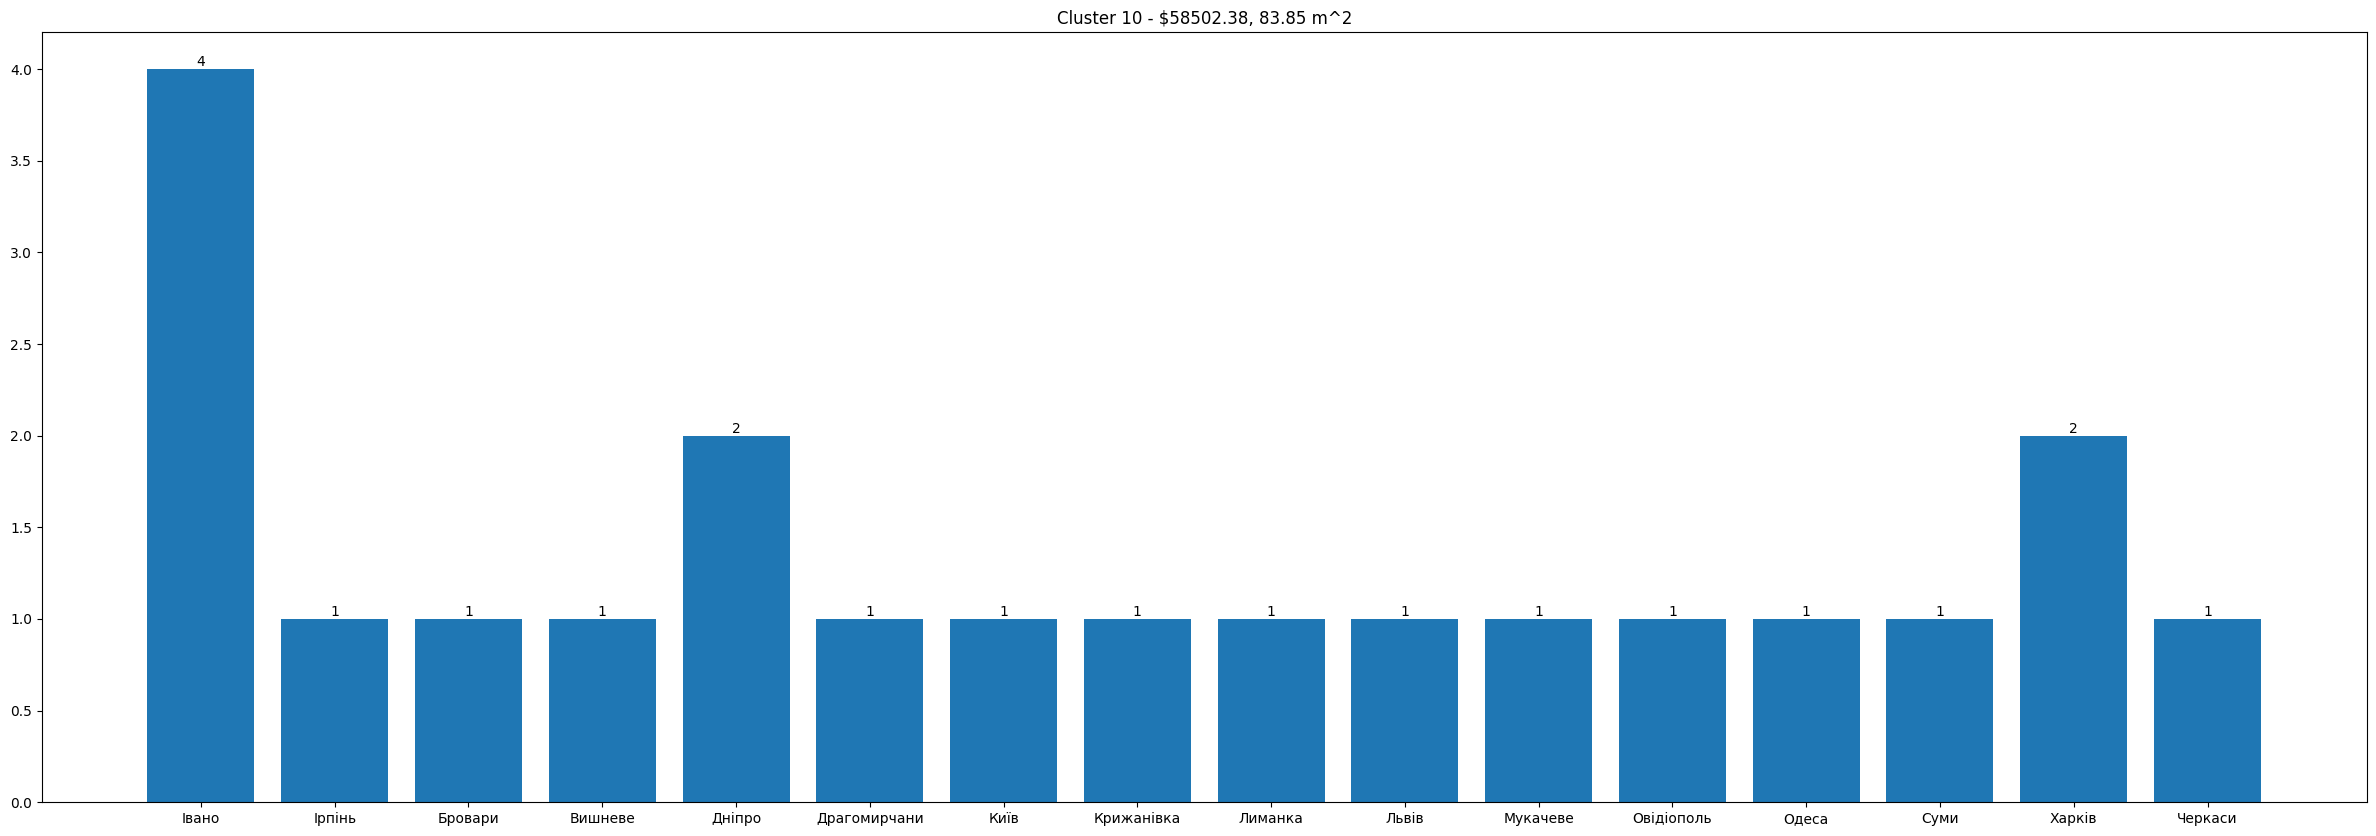

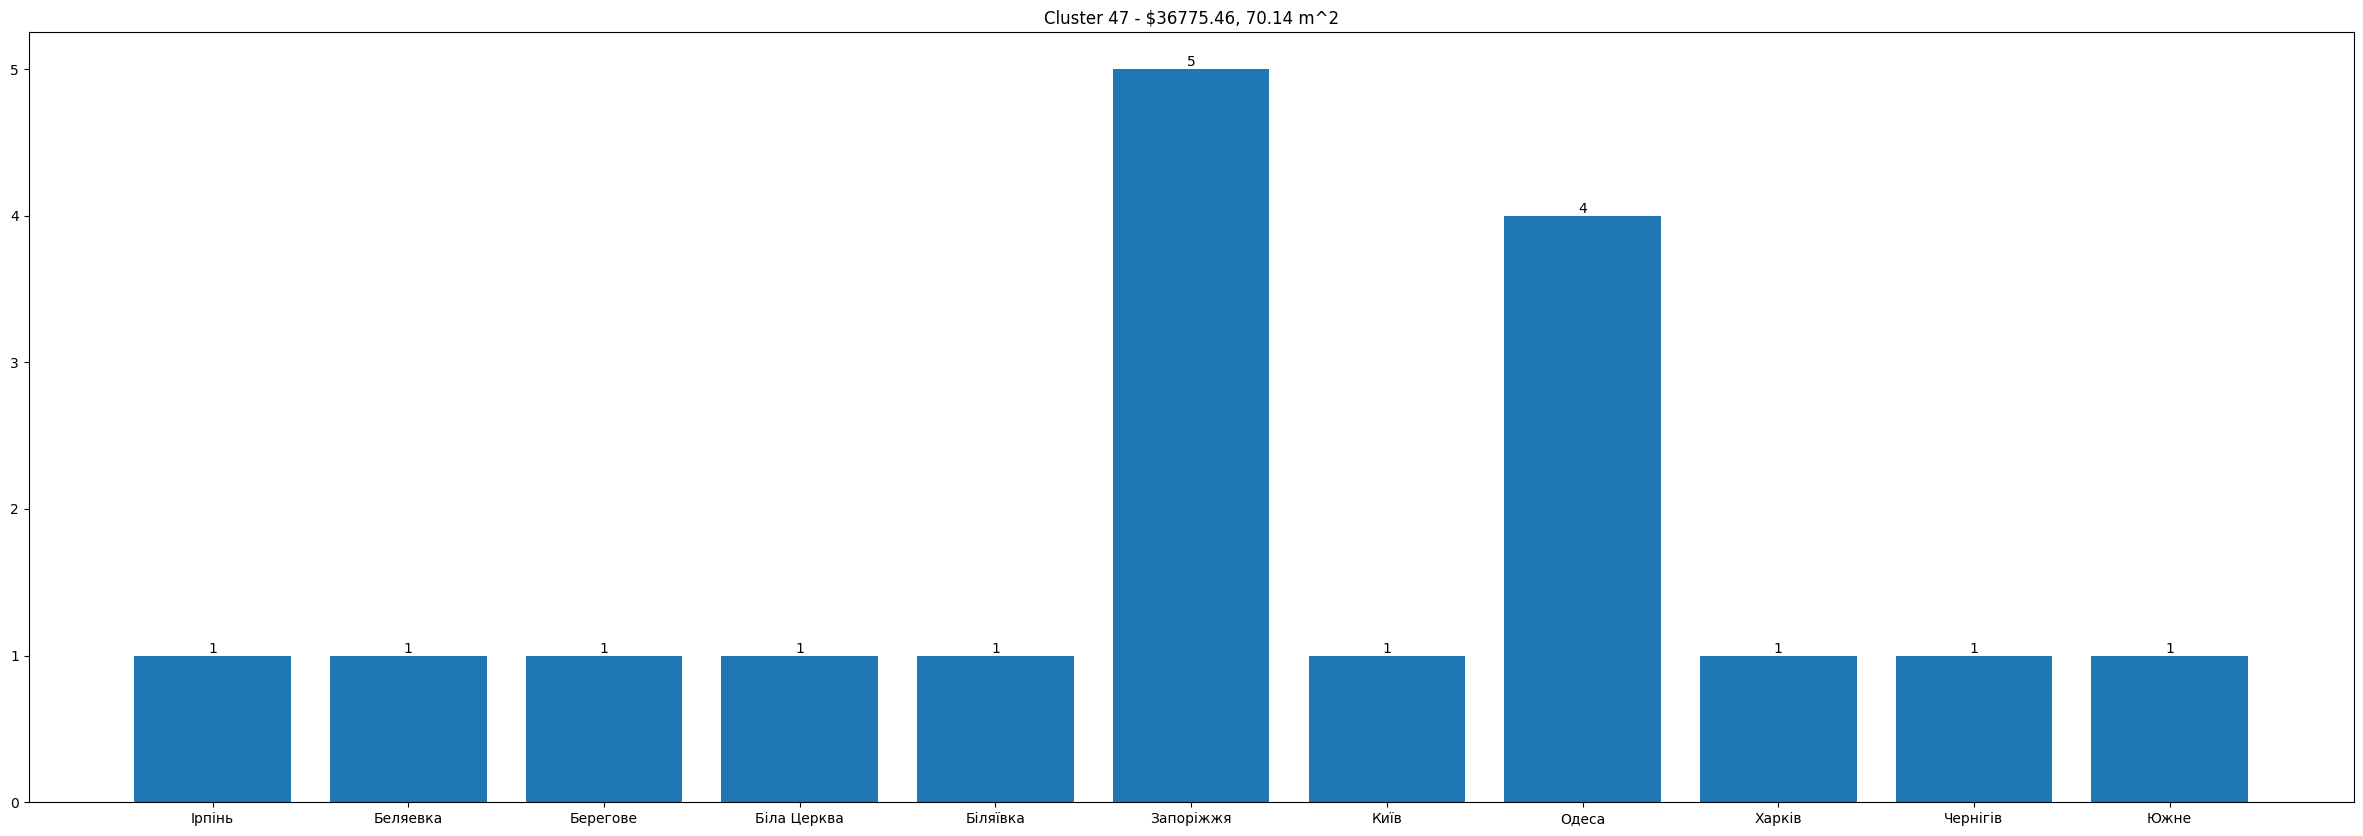

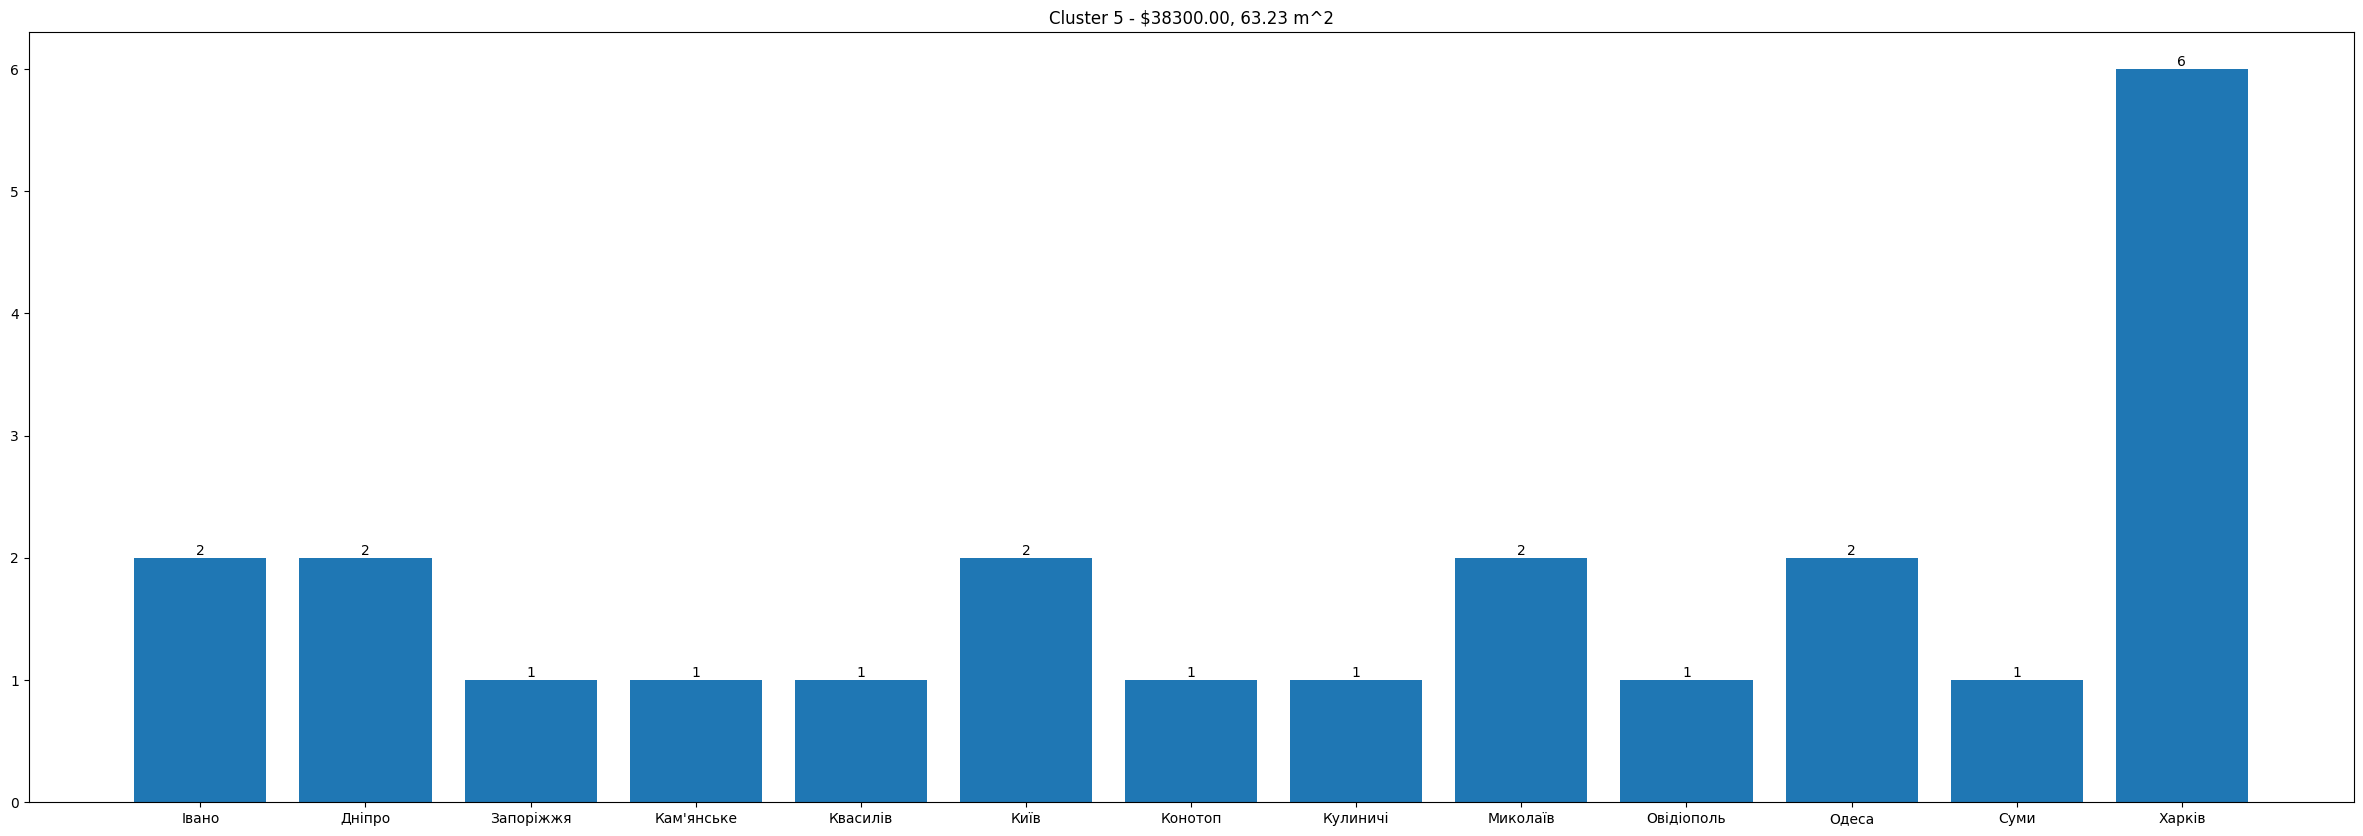

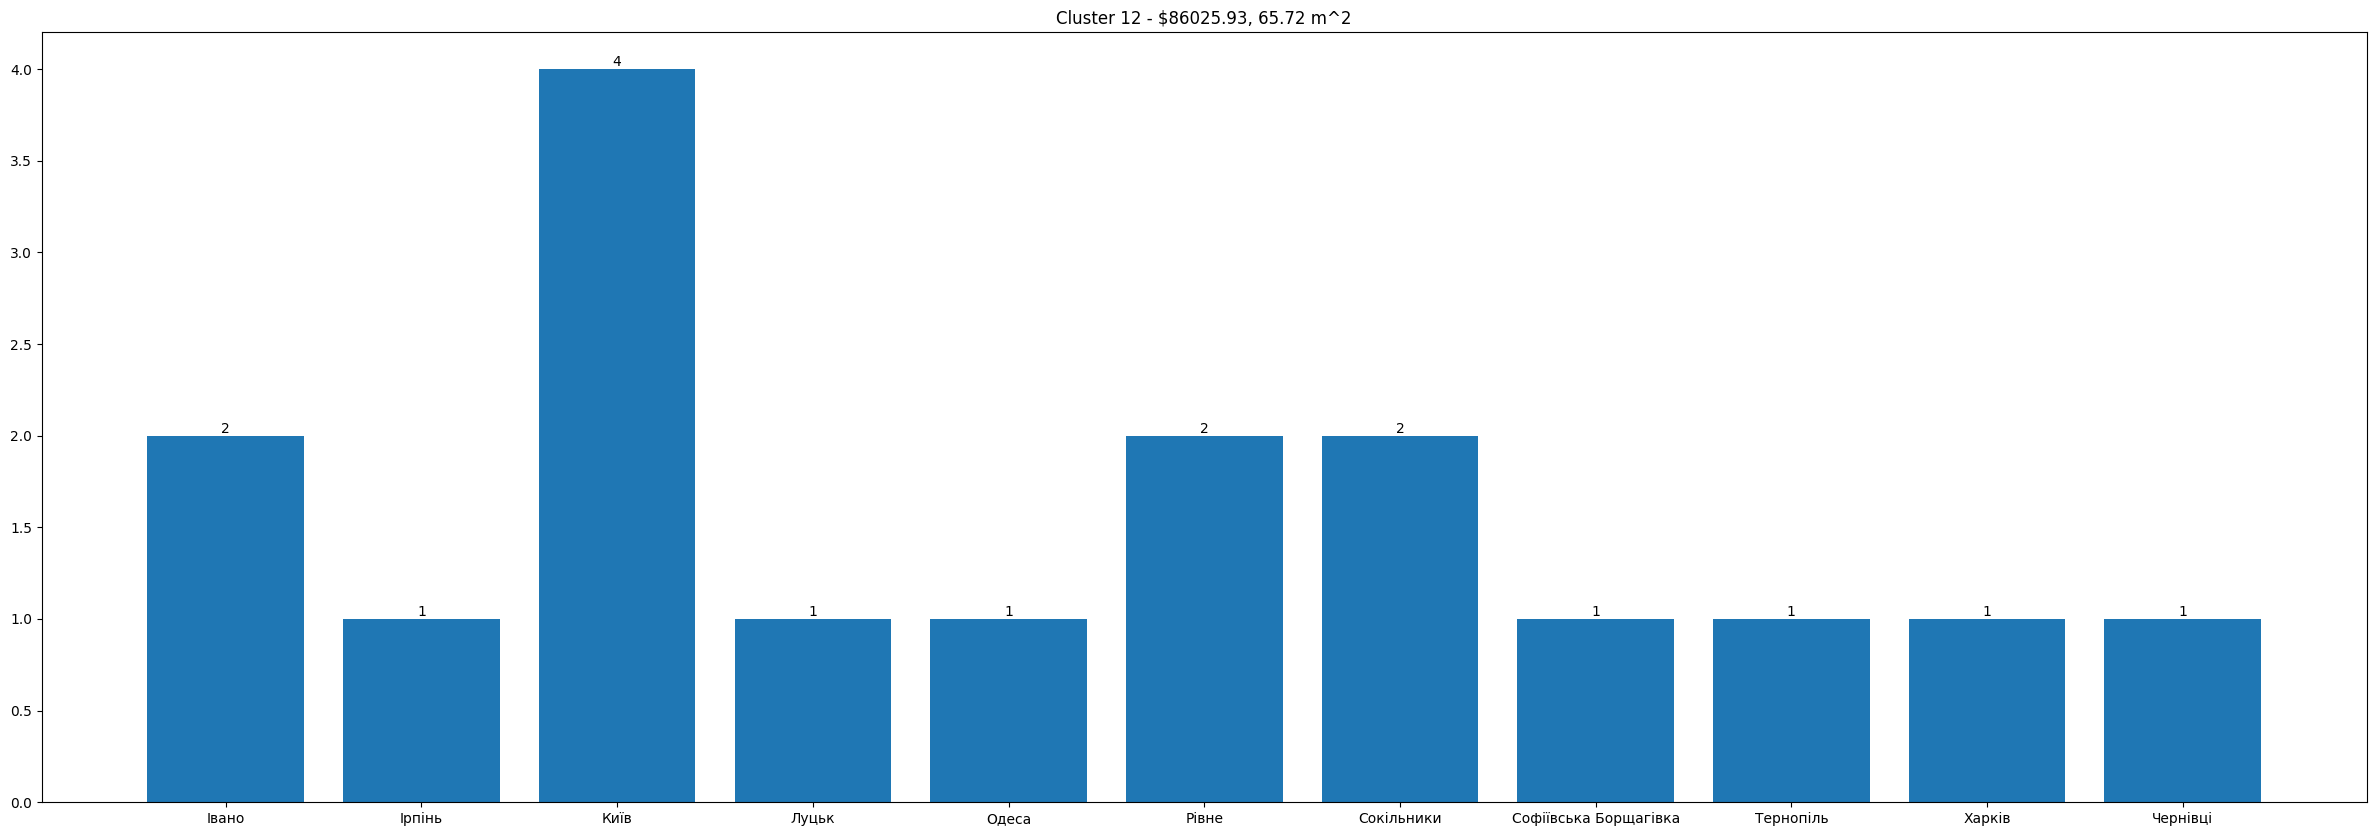

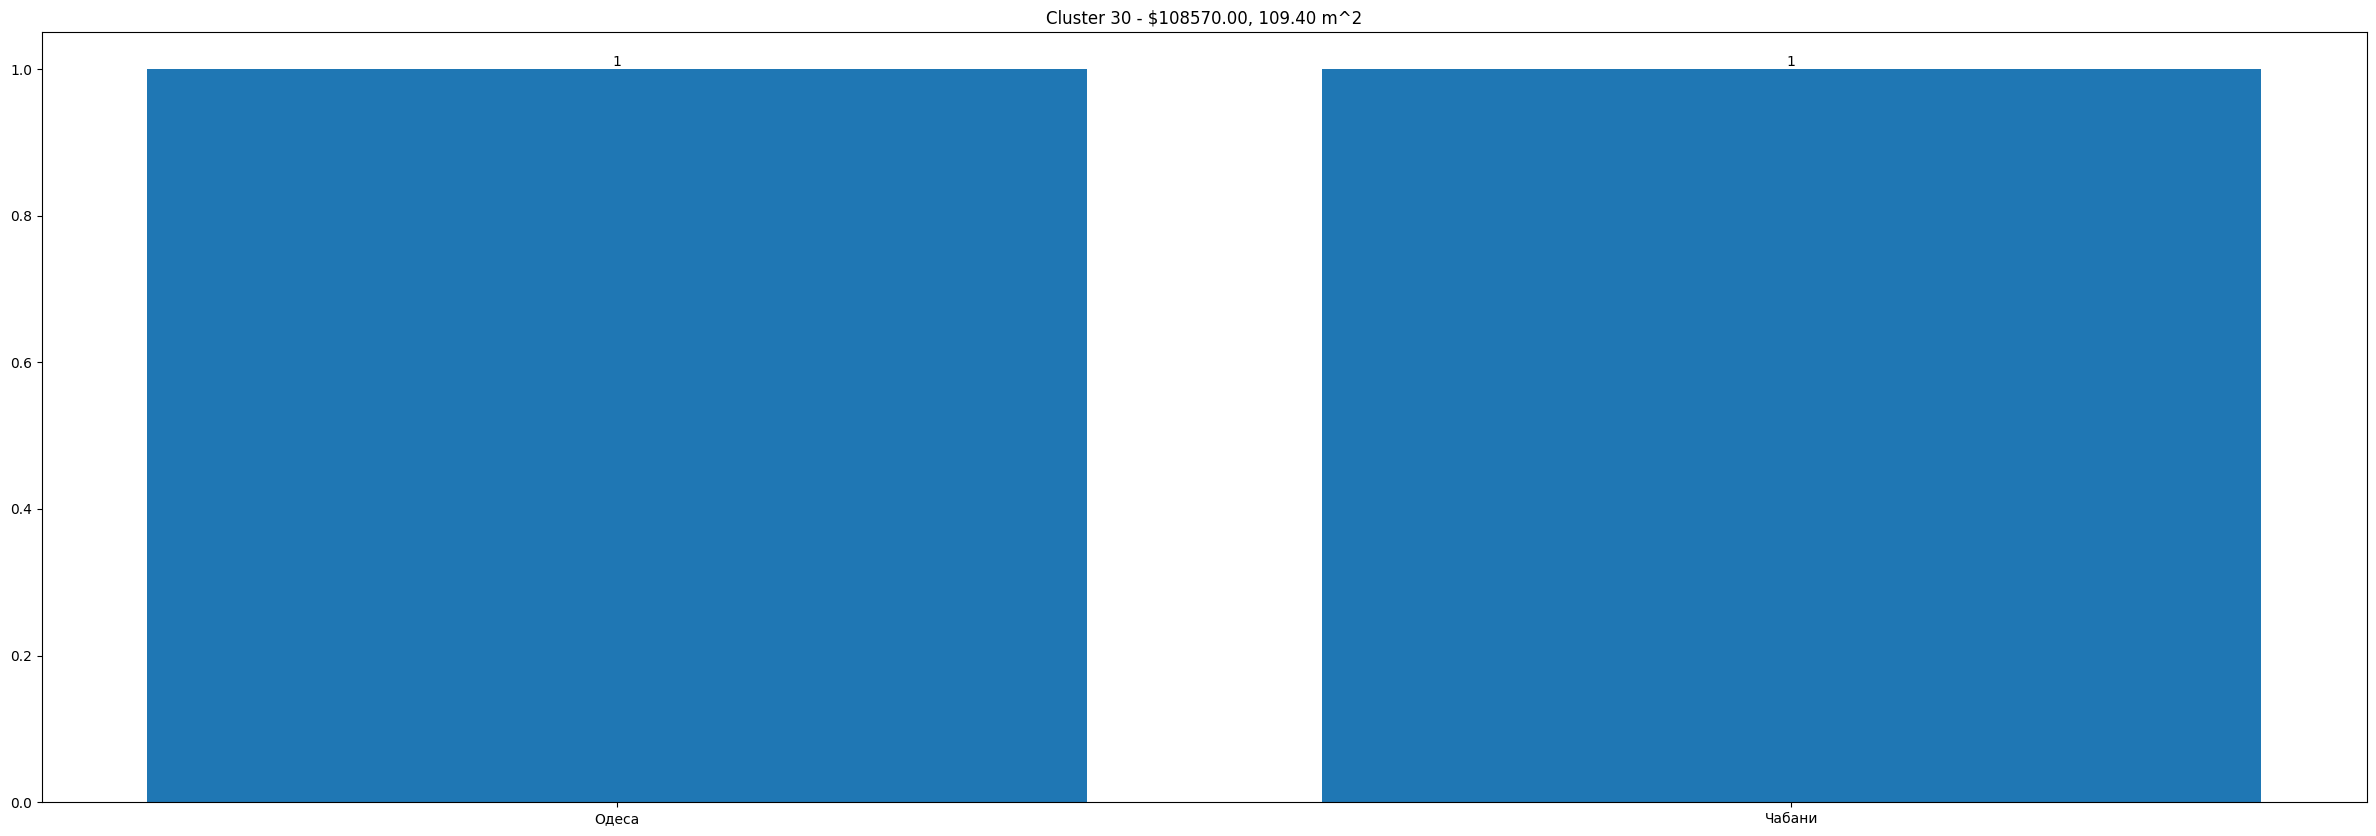

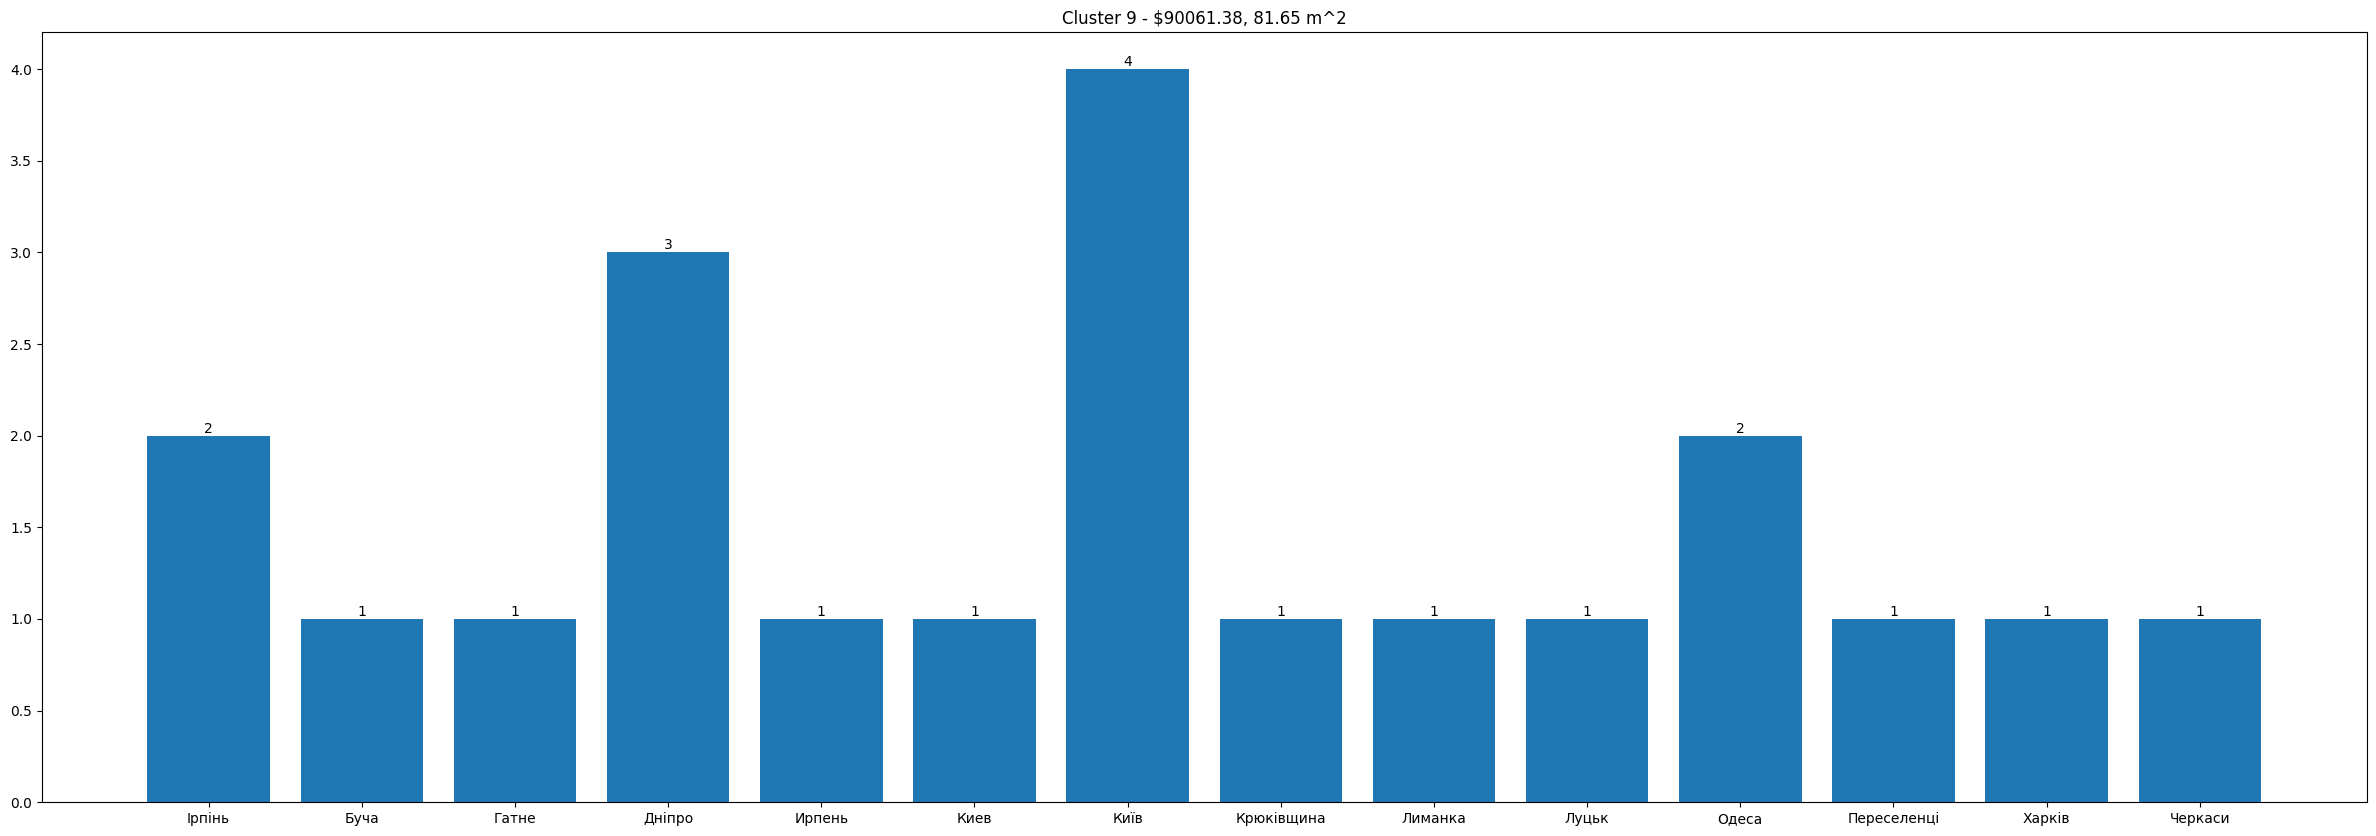

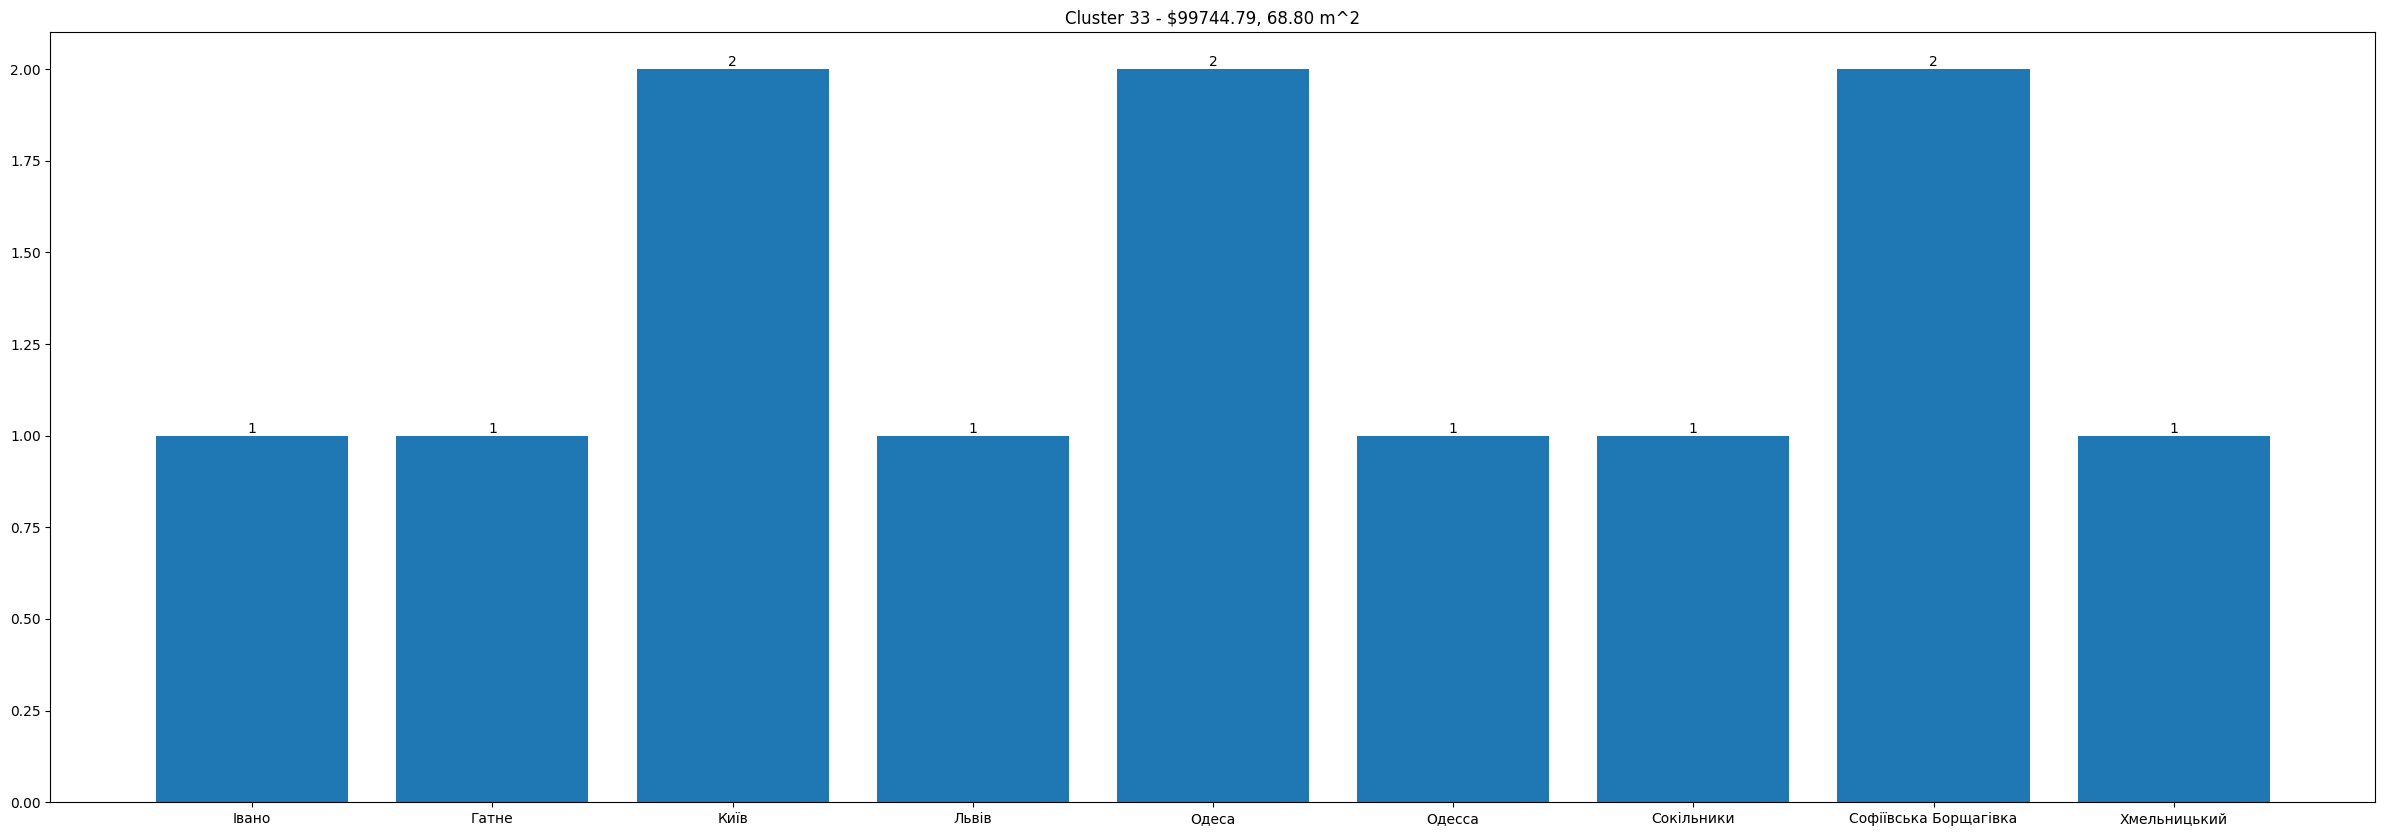

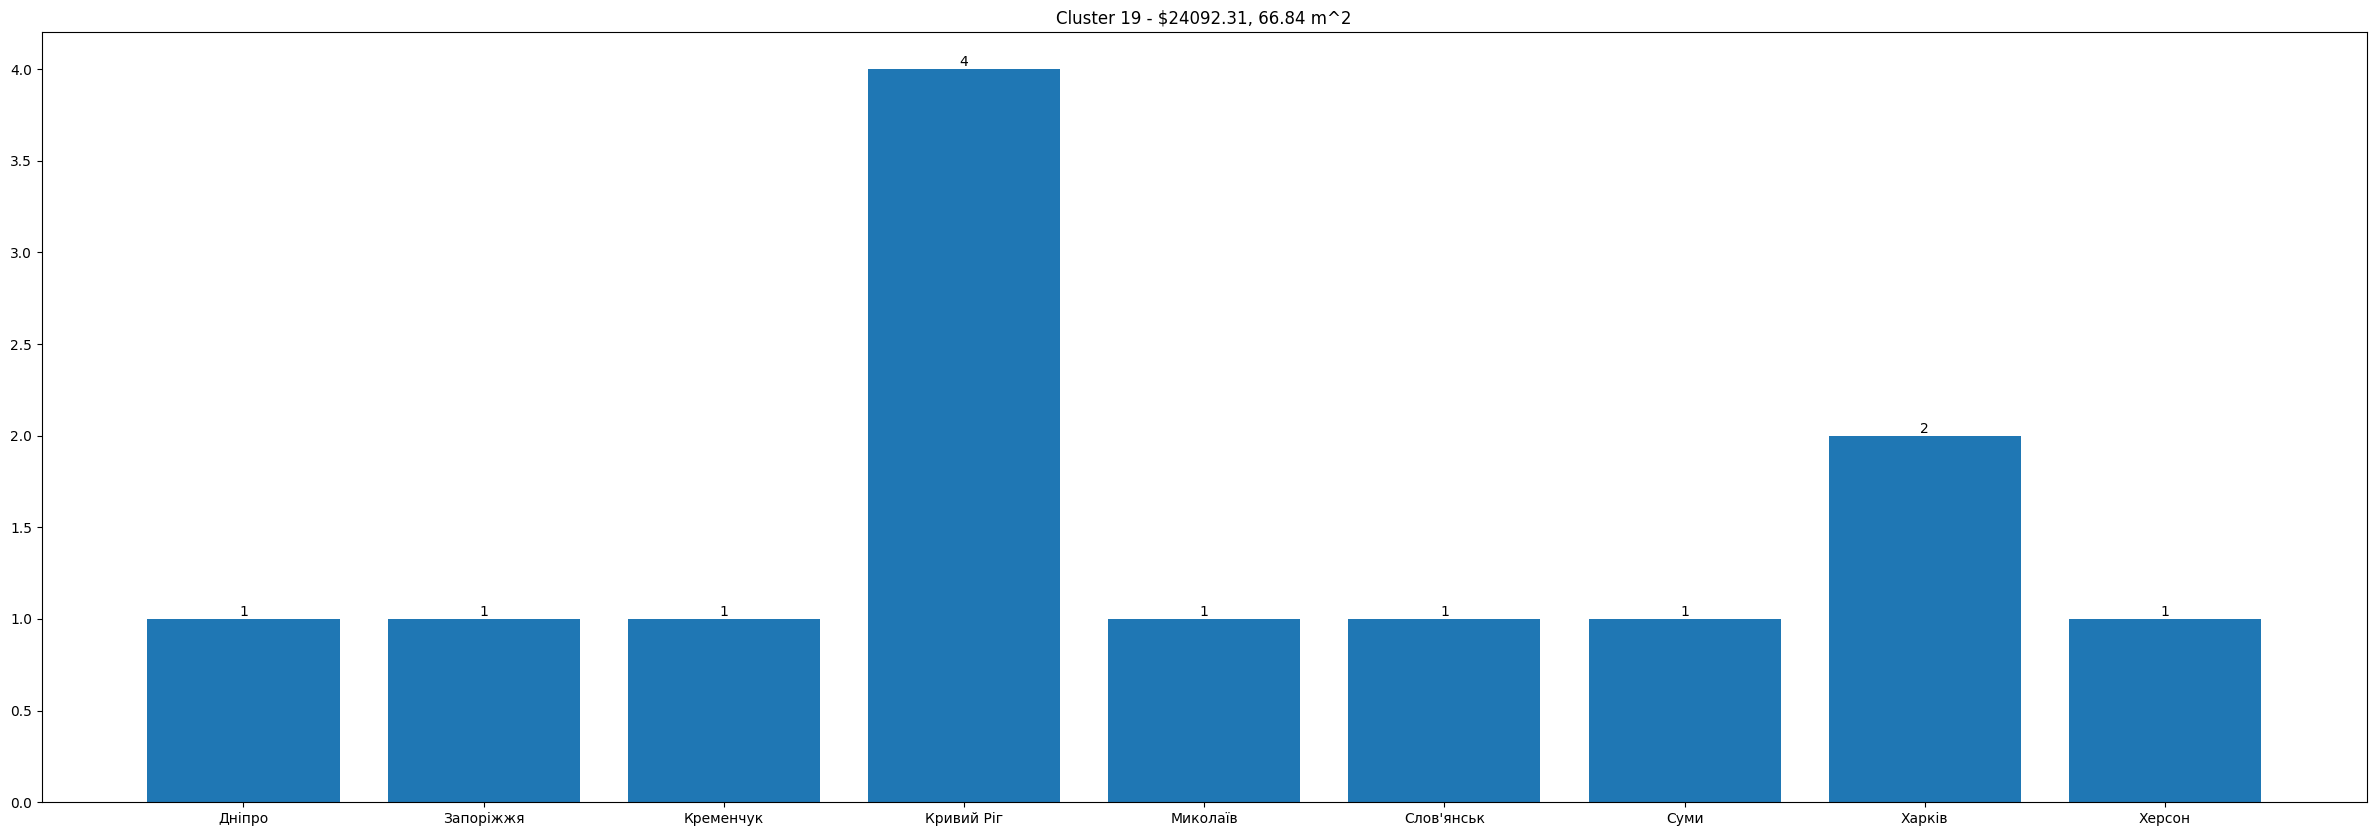

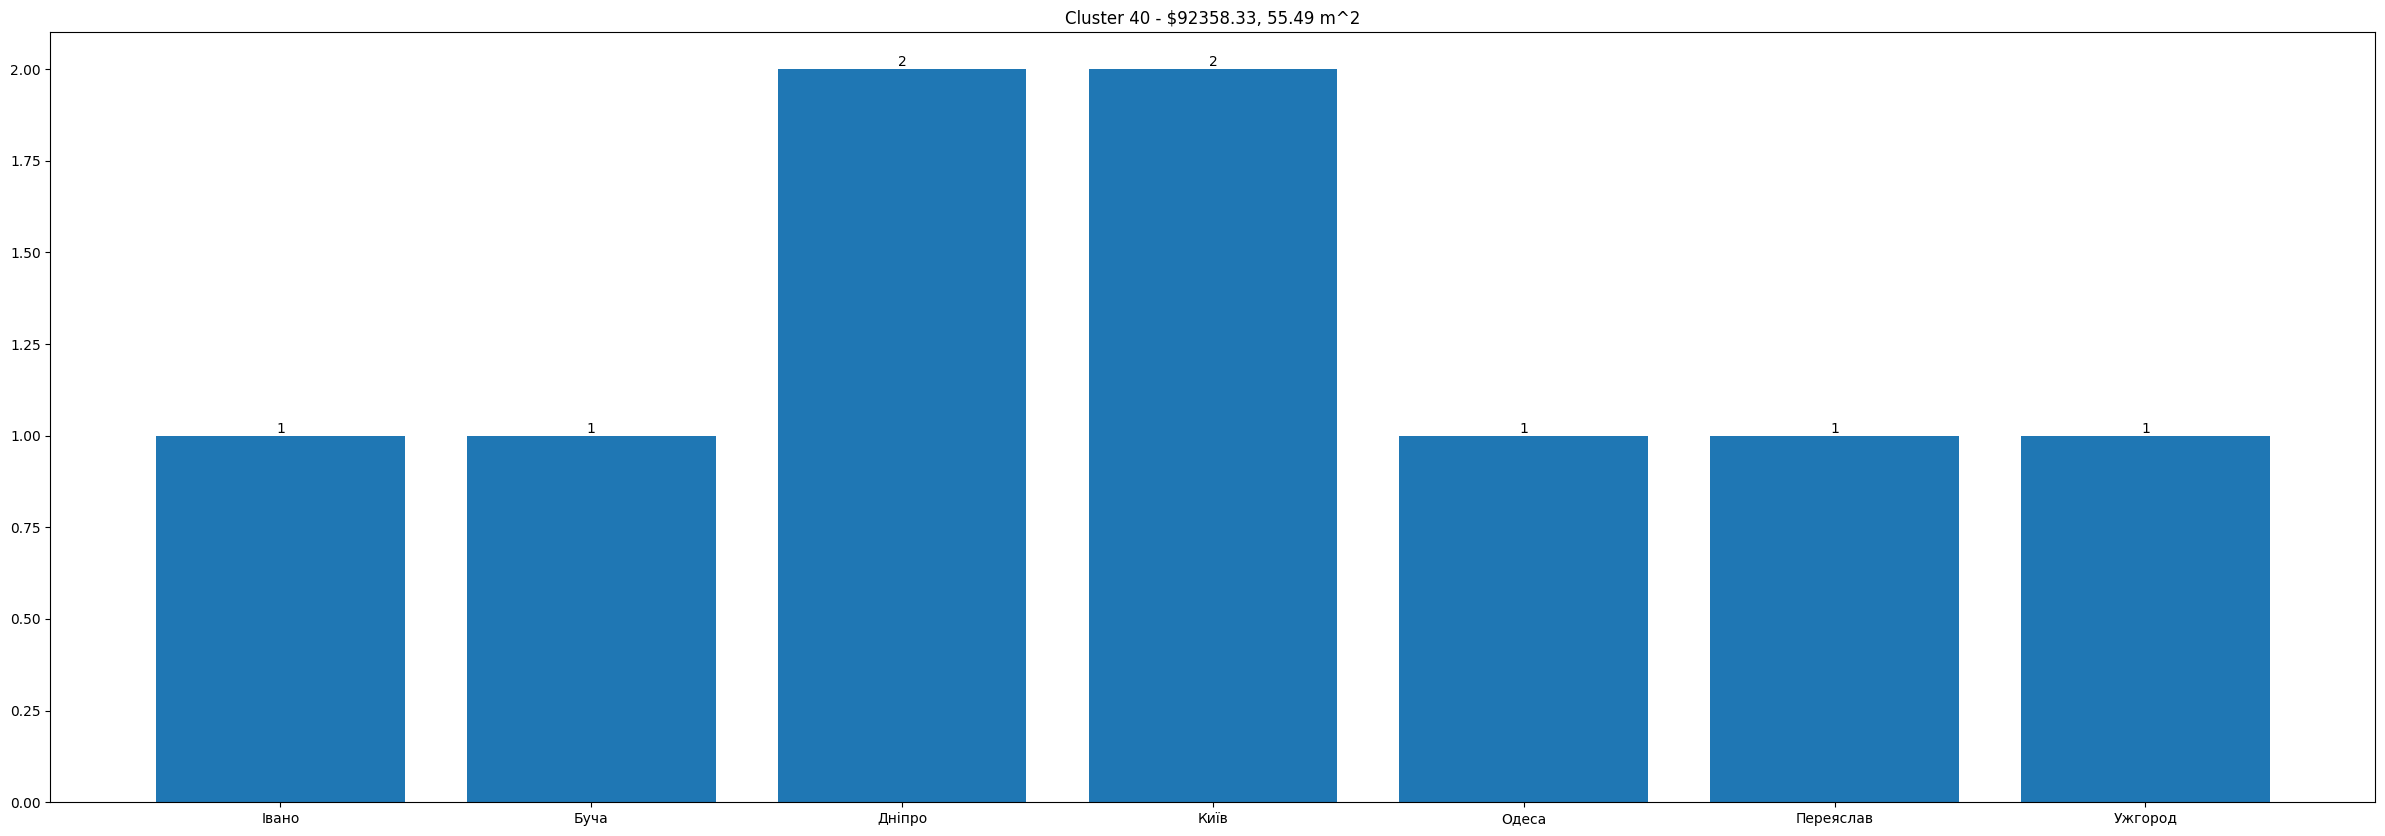

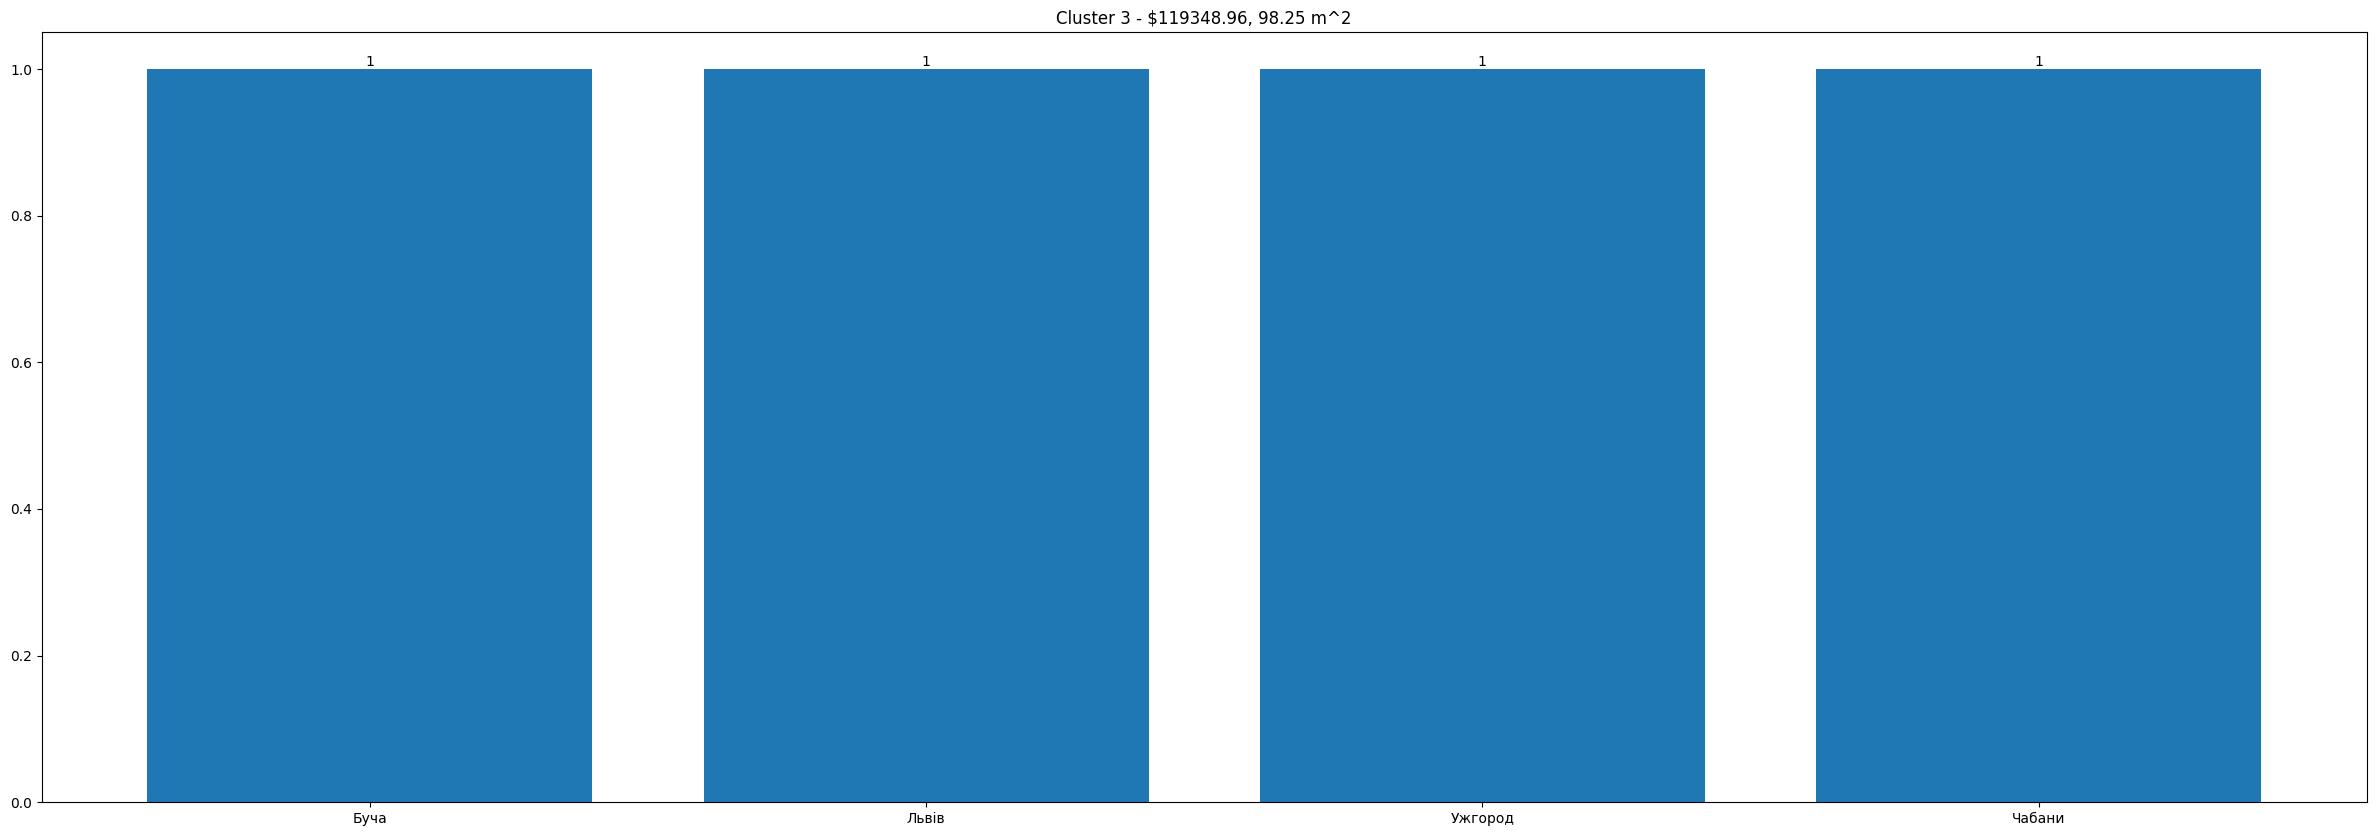

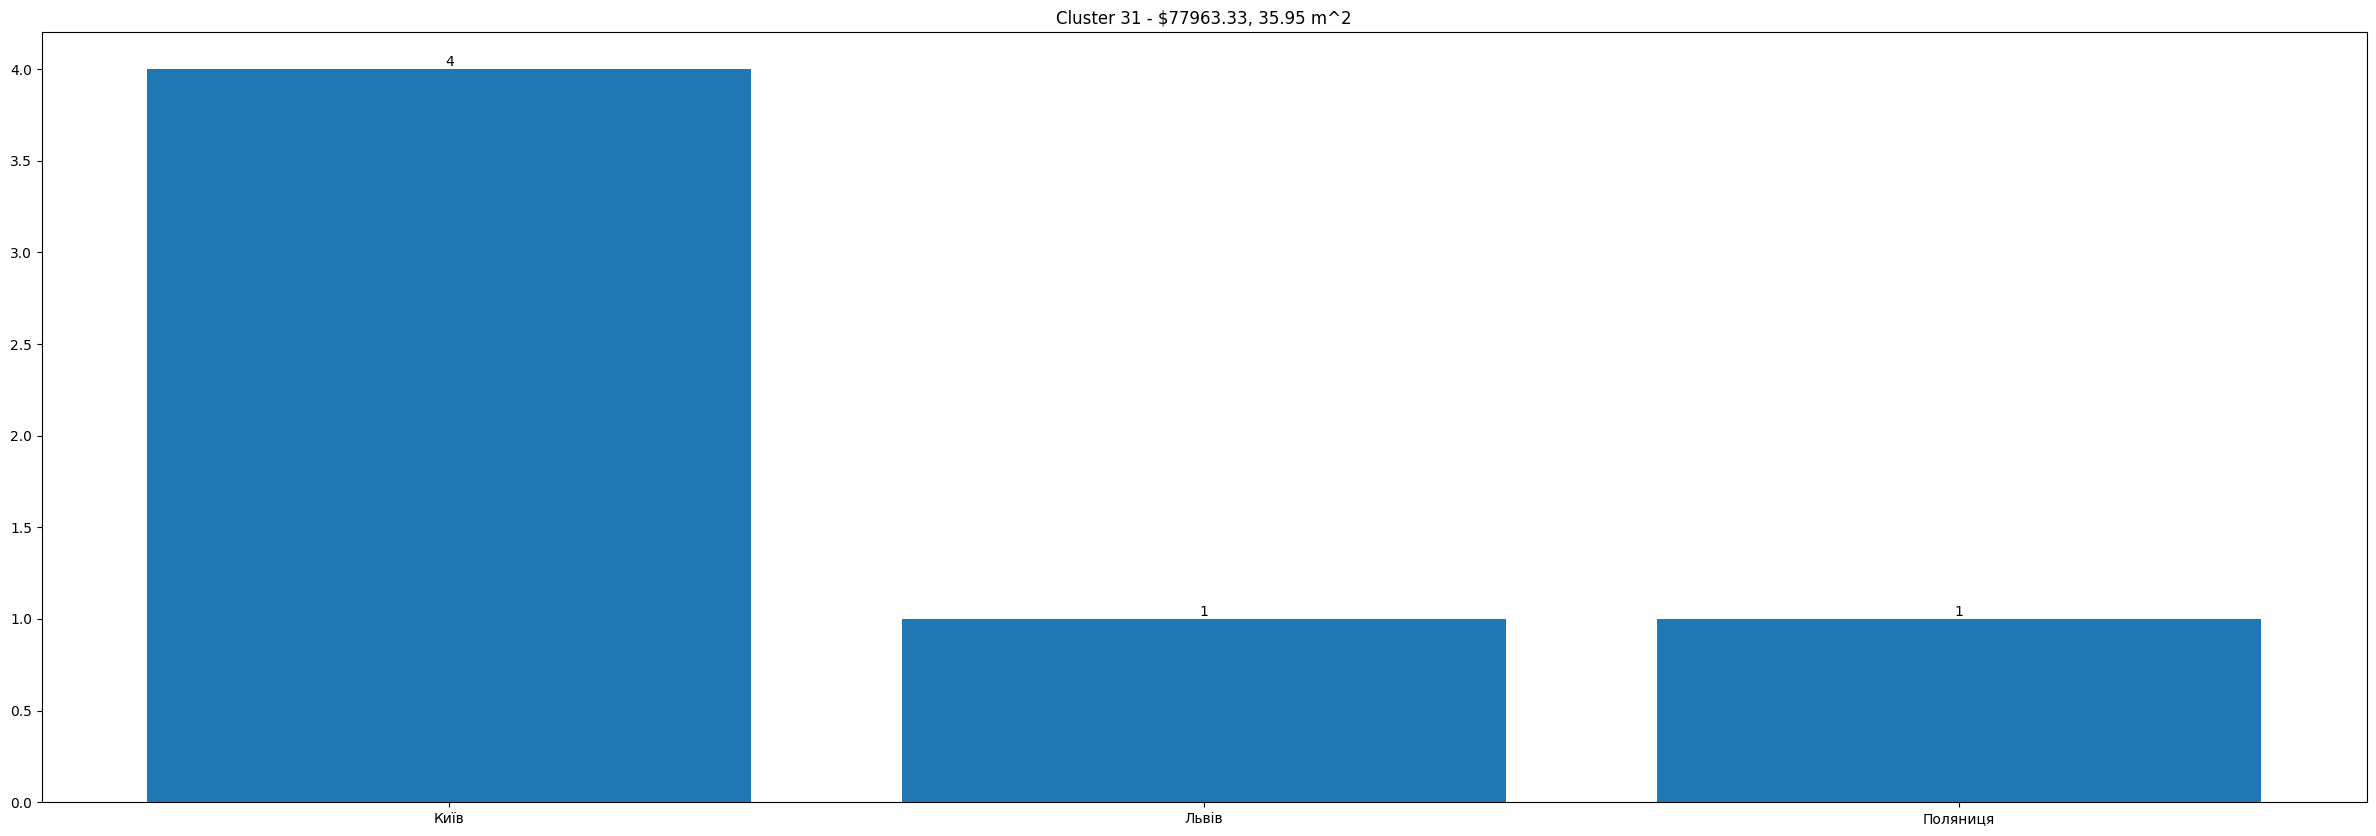

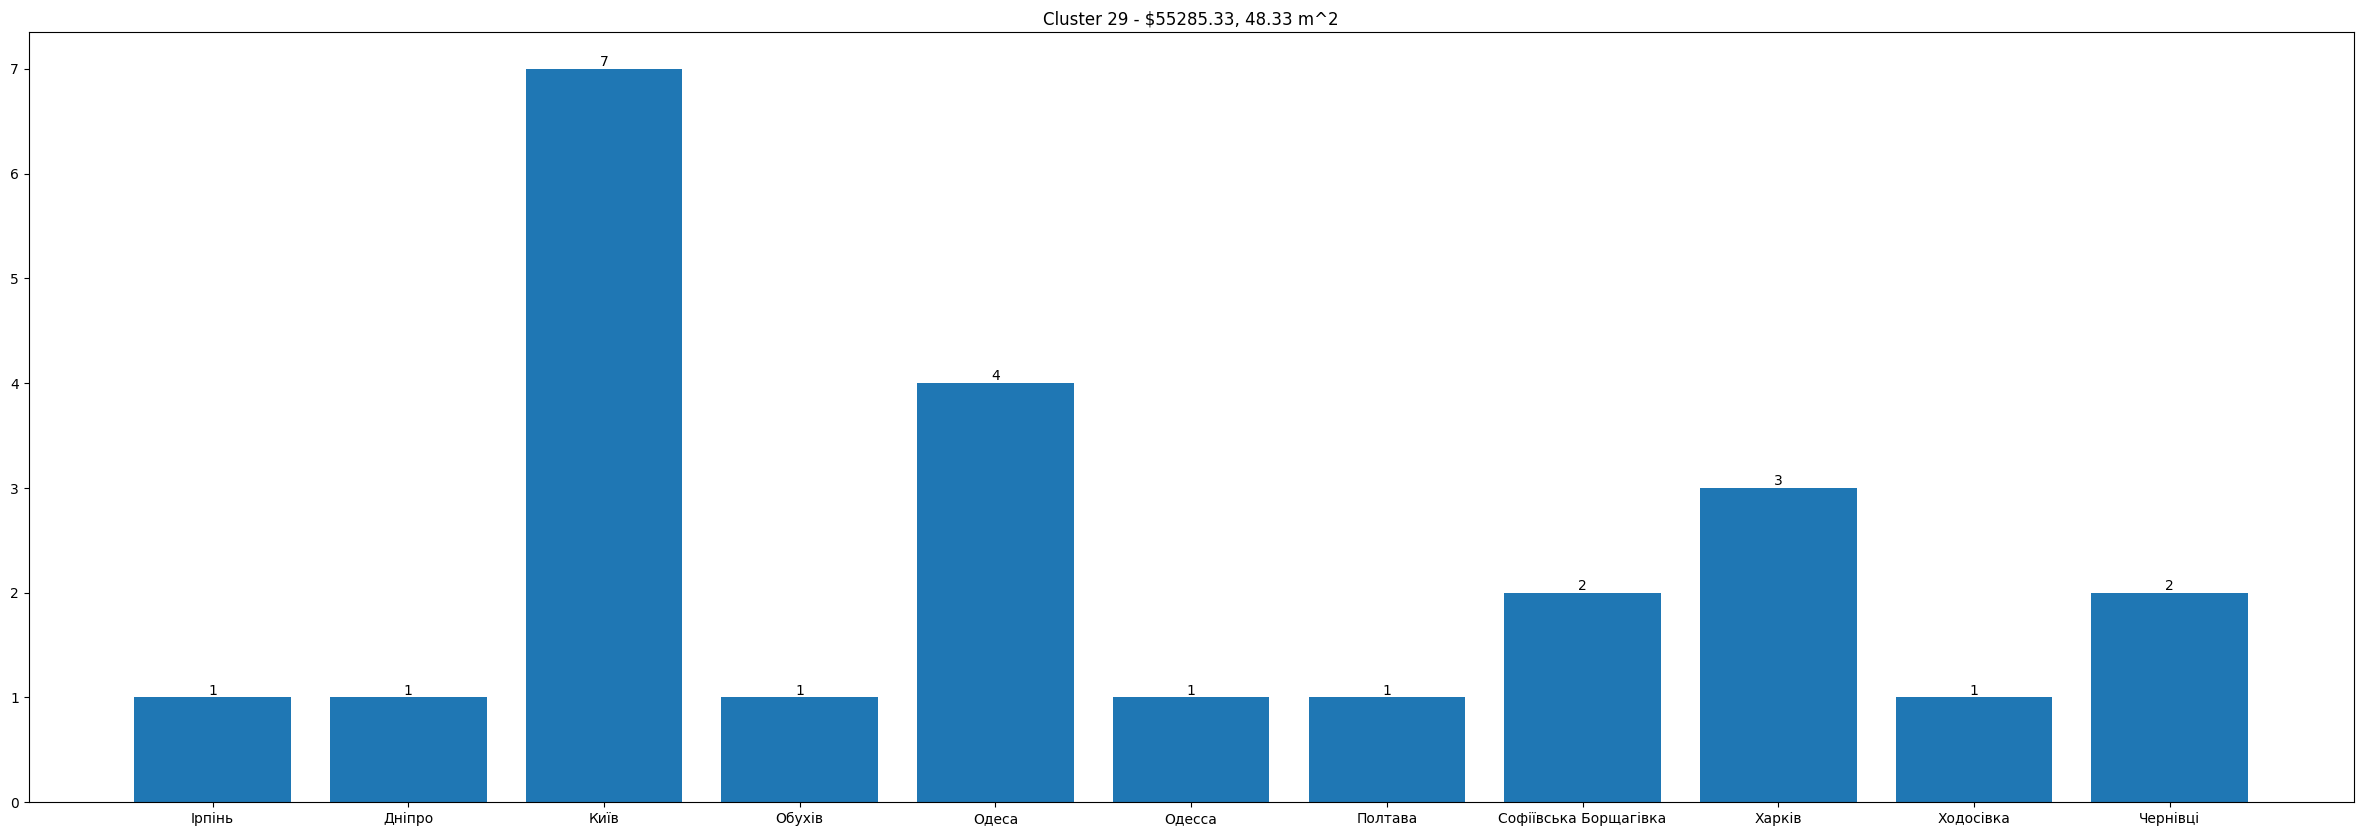

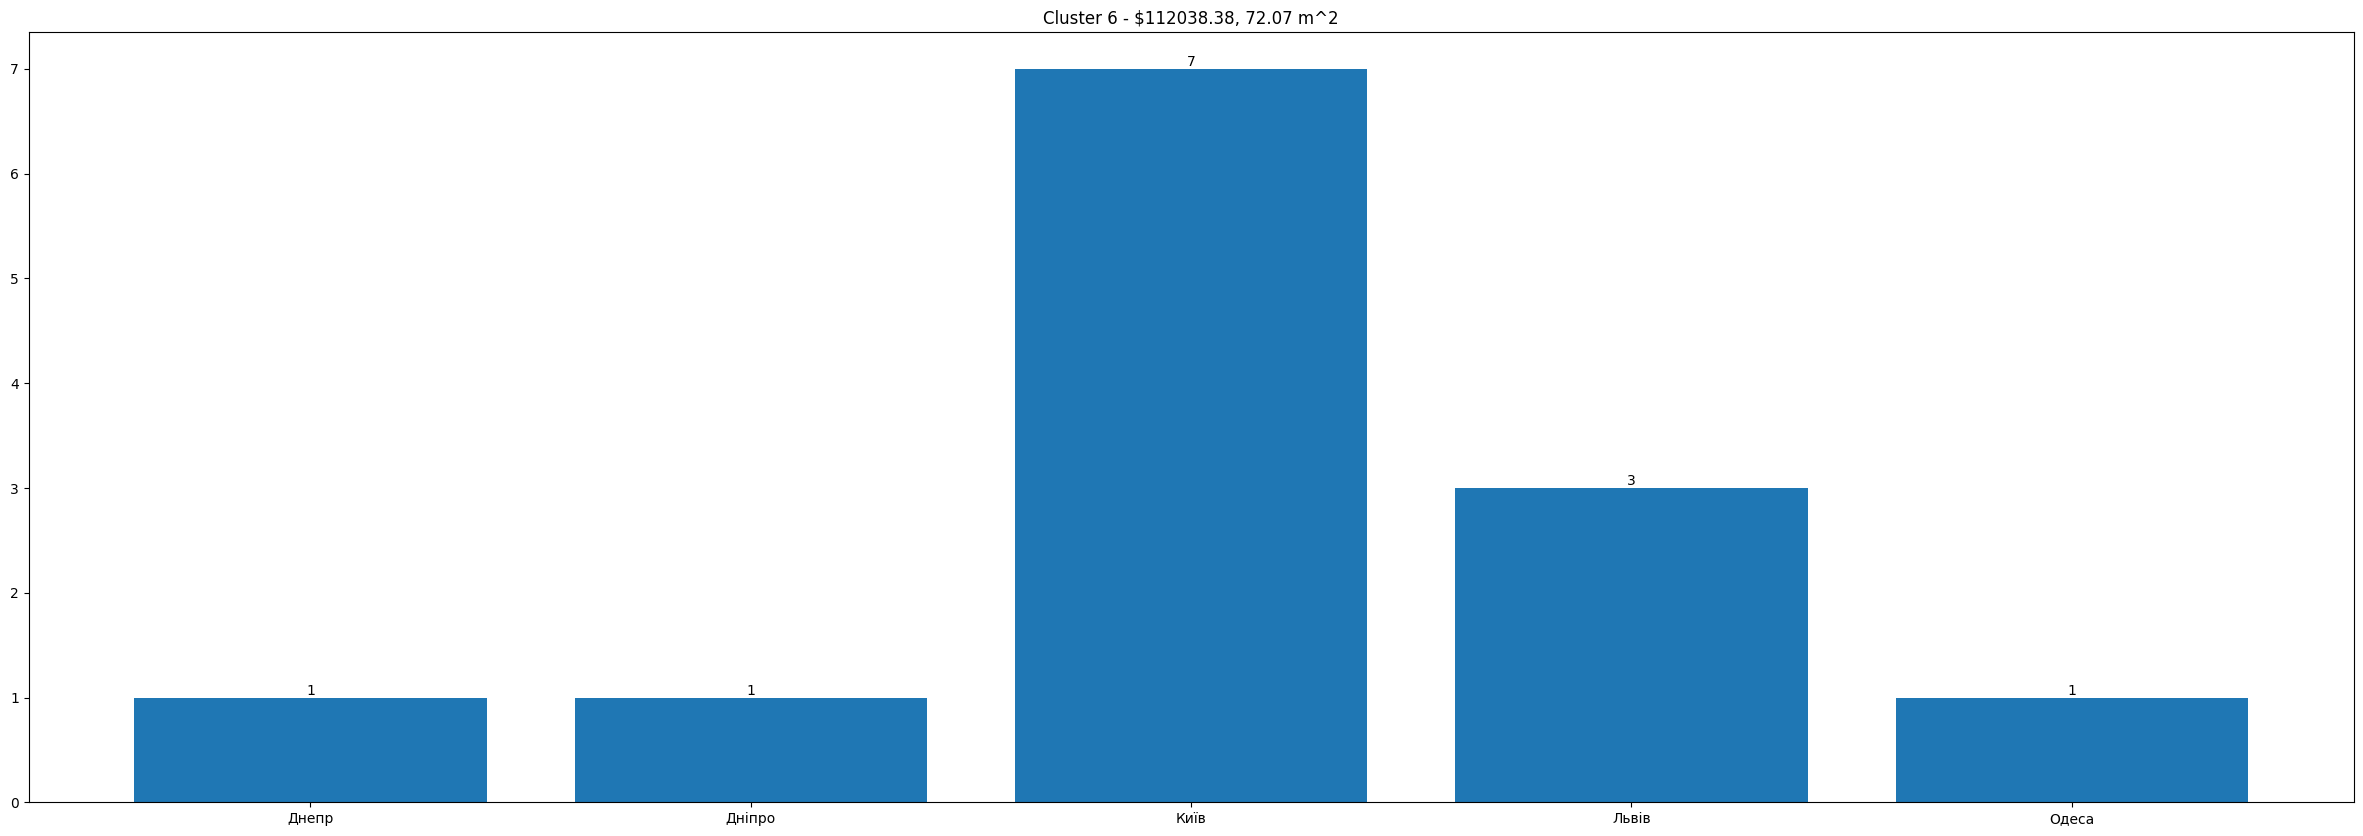

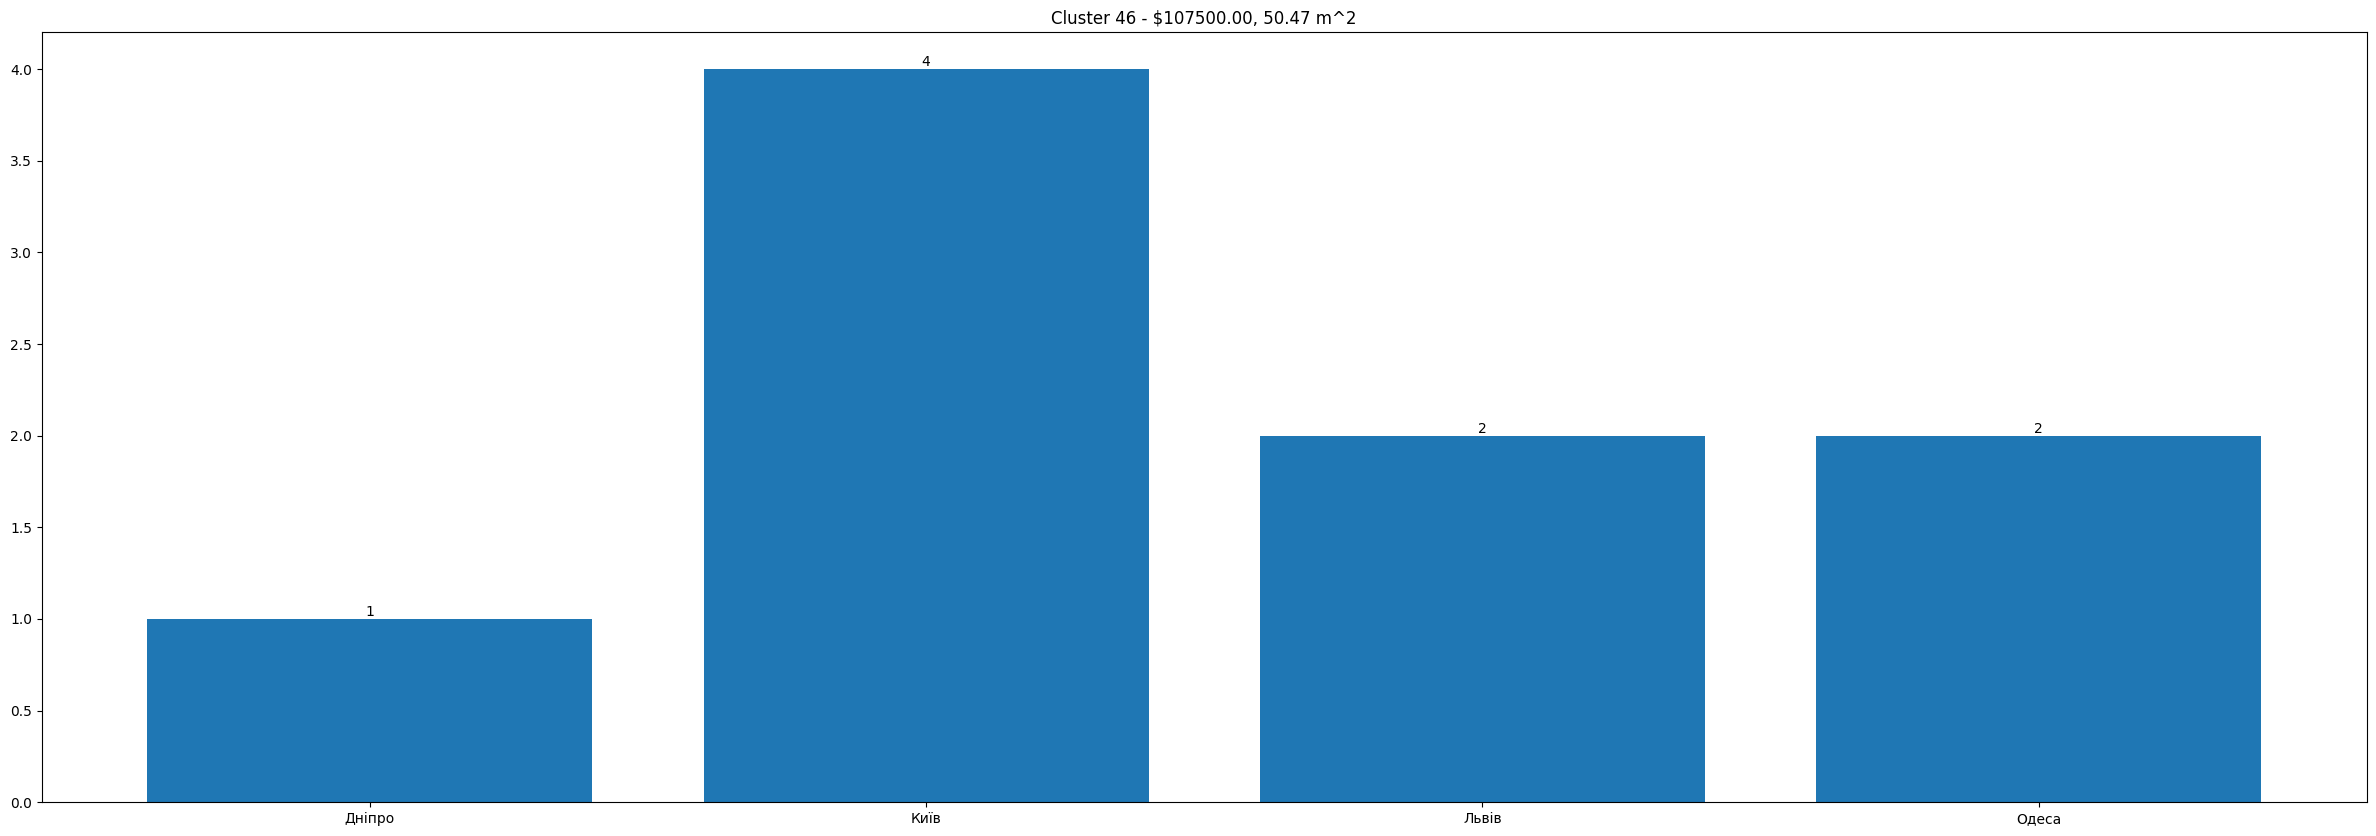

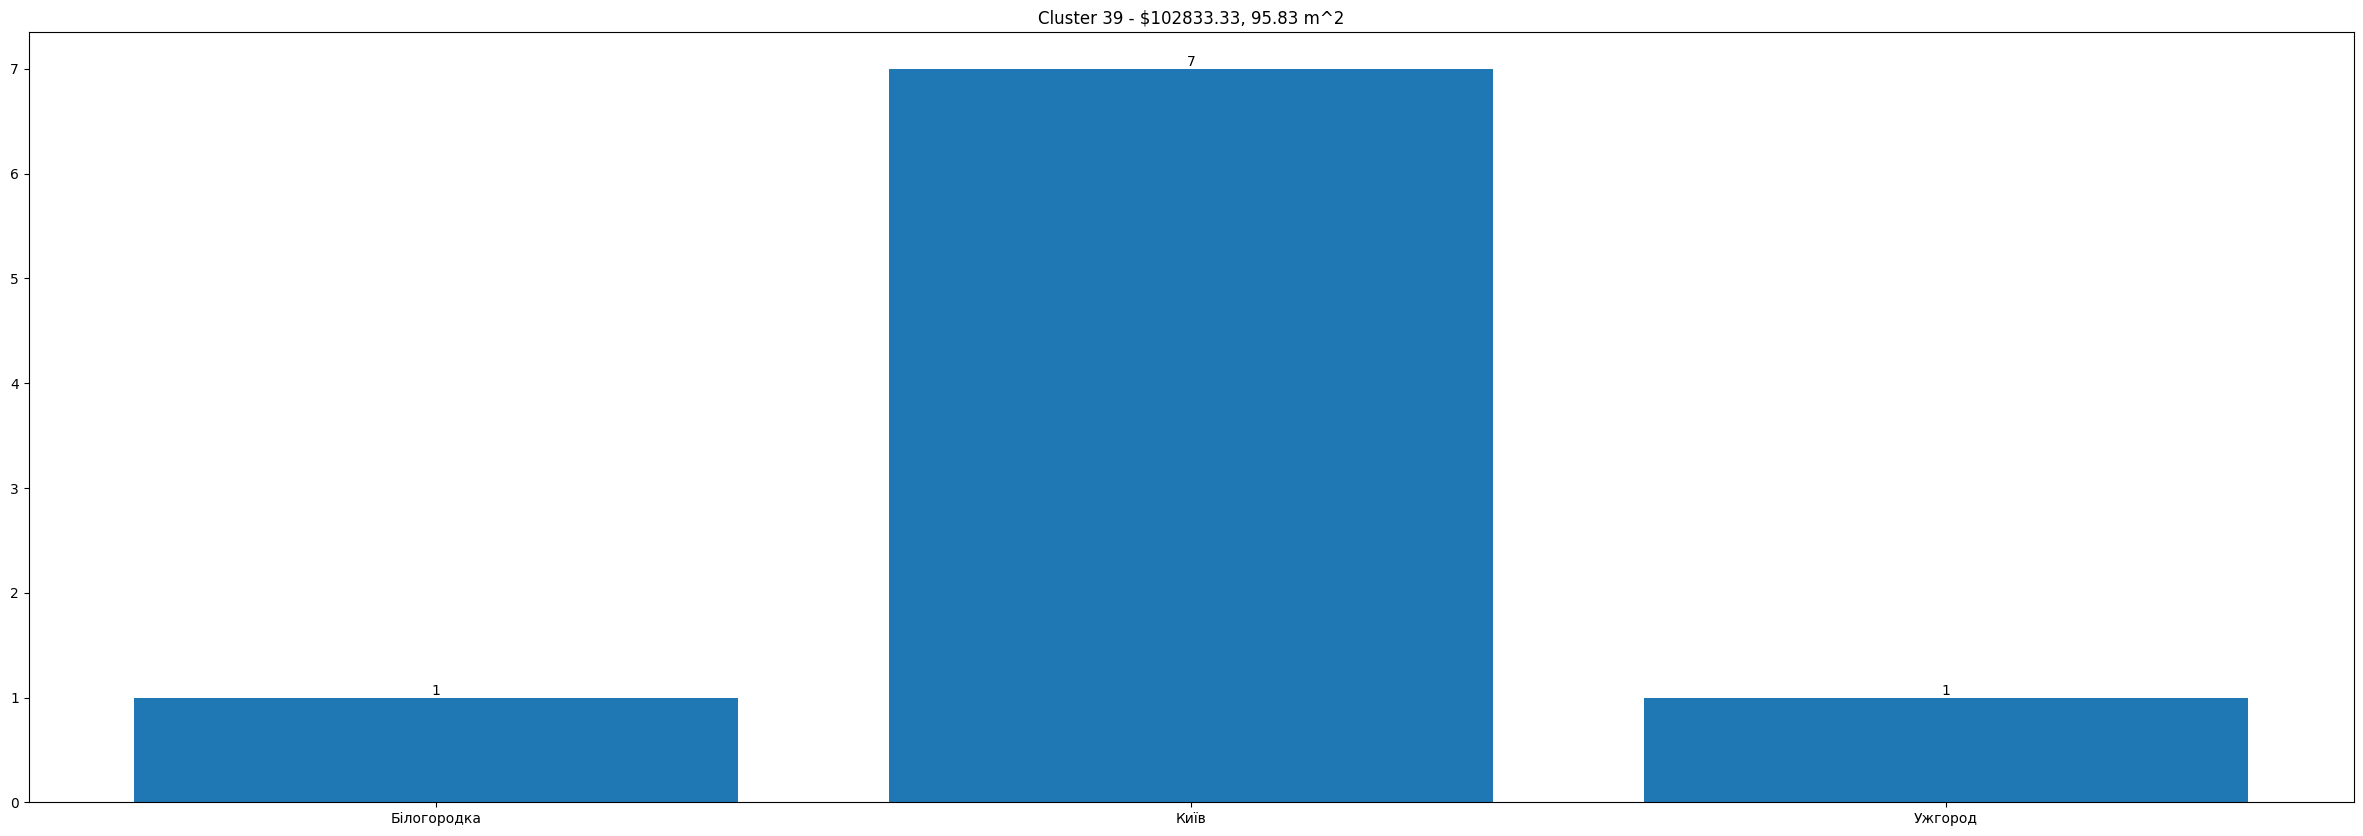

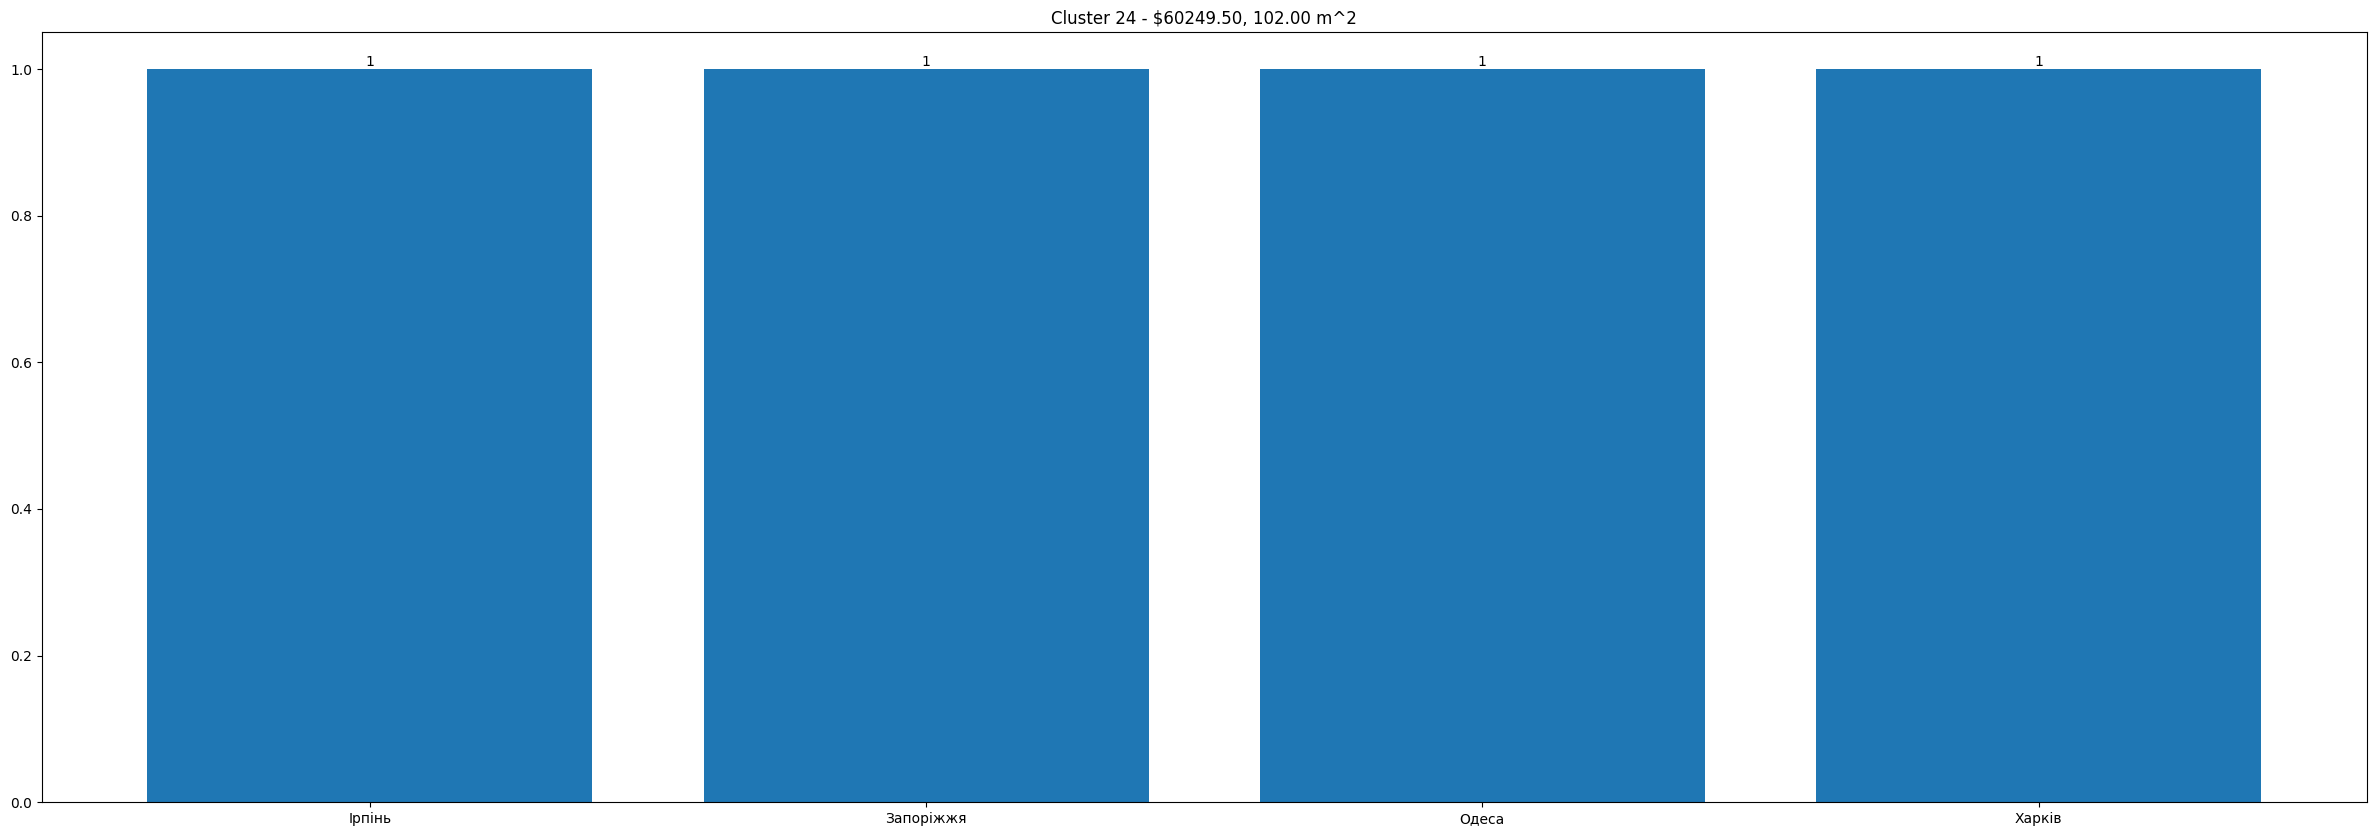

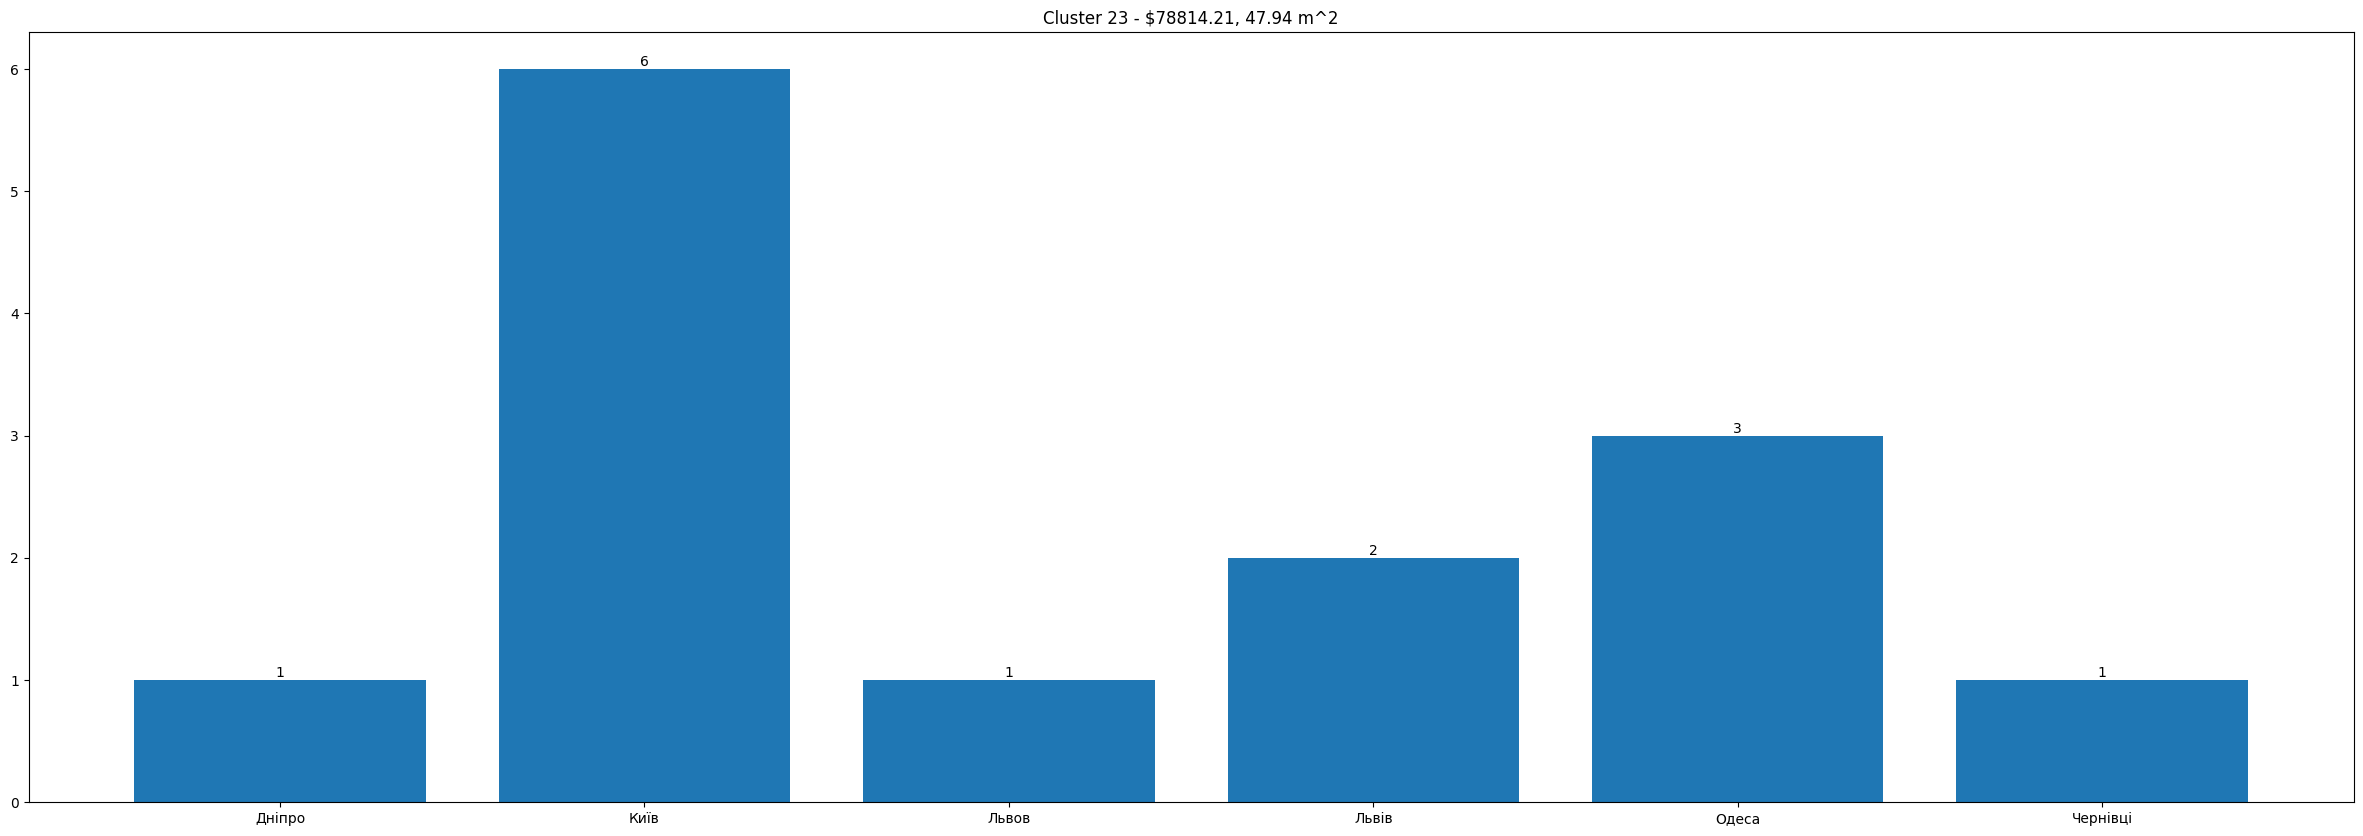

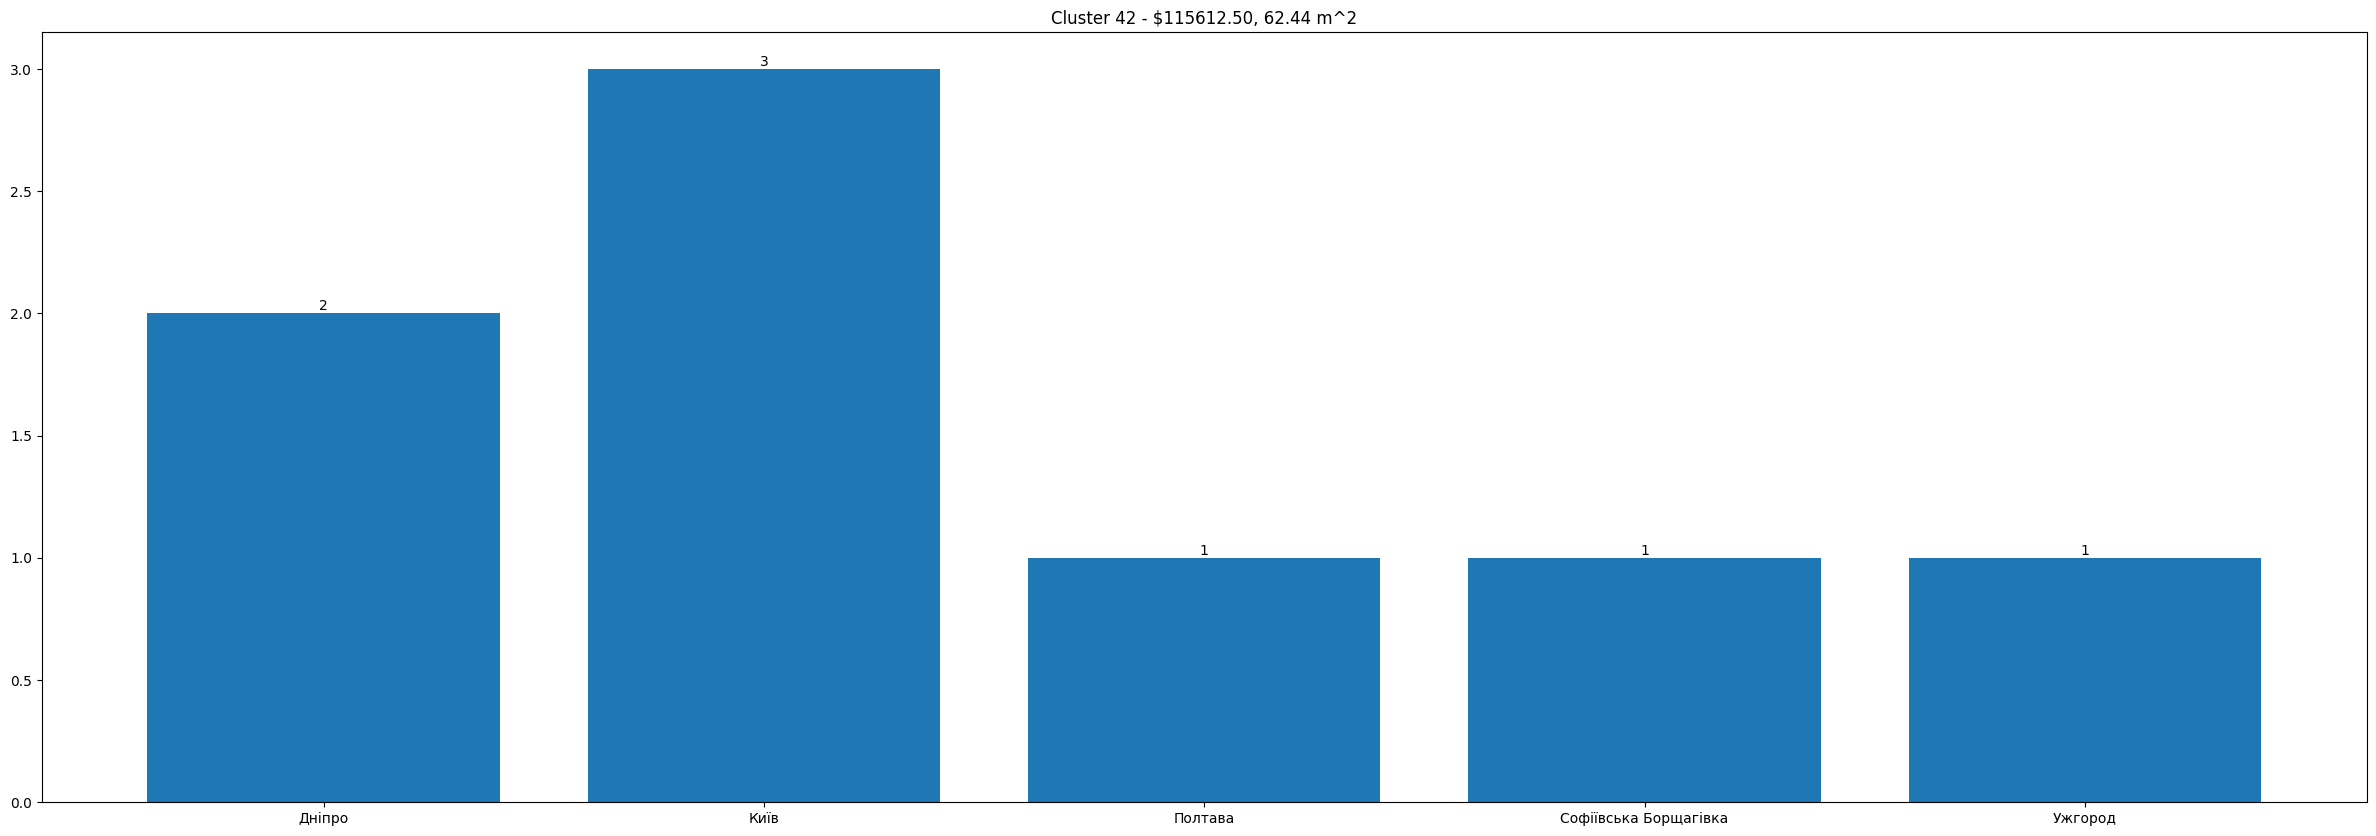

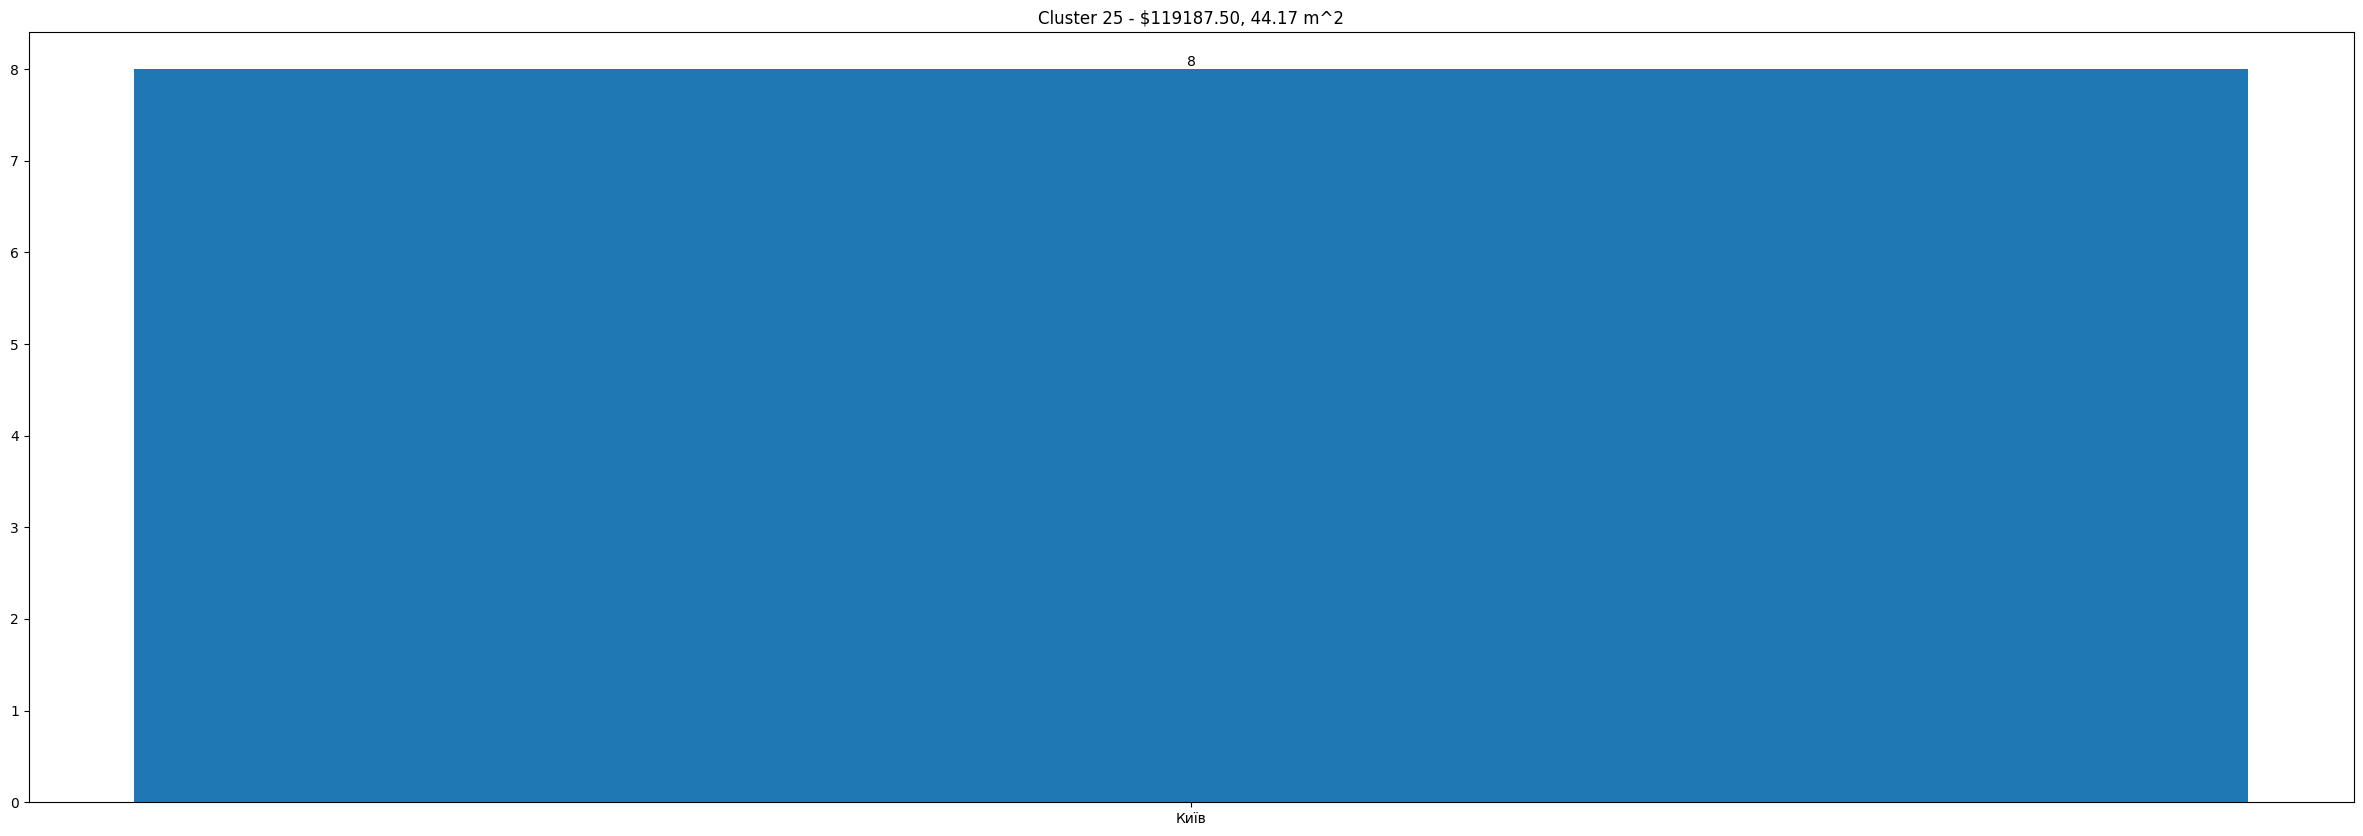

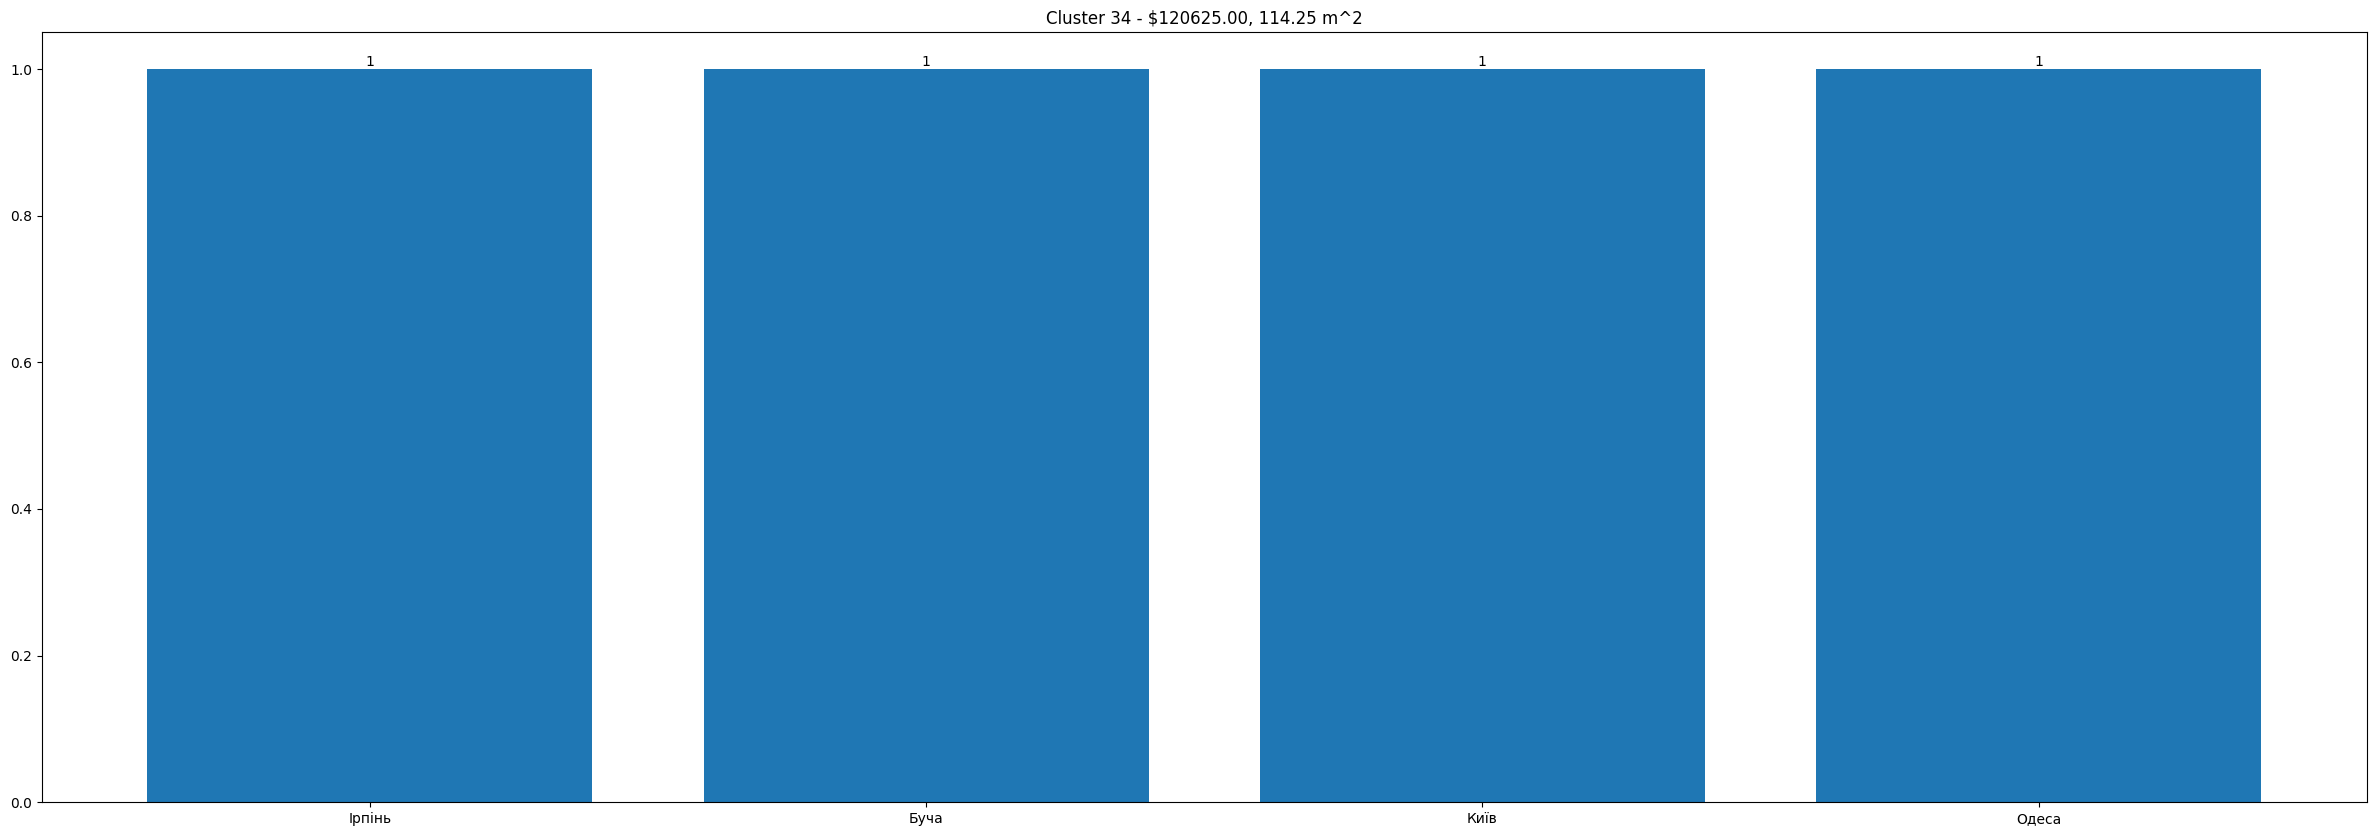

cluster_id
0     1
22    1
38    2
Name: _id, dtype: int64




cluster_id
0     8
4     4
7     3
8     7
9     2
10    1
11    3
12    1
13    2
14    2
20    3
22    2
24    1
26    3
27    1
28    1
29    1
32    1
34    1
35    1
36    2
37    4
38    7
41    6
43    1
47    1
Name: _id, dtype: int64




cluster_id
0     2
4     1
10    1
11    1
15    1
16    1
38    1
45    2
Name: _id, dtype: int64




cluster_id
0     1
1     1
7     1
9     1
10    1
16    1
36    2
43    1
45    1
Name: _id, dtype: int64




cluster_id
0     2
1     1
2     1
4     1
5     2
10    4
12    2
13    1
14    4
15    1
16    1
17    1
20    4
22    1
26    2
27    1
32    1
33    1
36    5
37    4
38    1
40    1
41    1
43    2
Name: _id, dtype: int64




cluster_id
0     4
4     1
5     2
6     1
7     3
8     1
9     3
10    2
11    1
13    5
14    3
15    1
16    1
18    1
19    1
20    3
21    1
22    3
23    1
26    2
27    3
28    1
29    1
35    1
36    1
37    4
38    1
40    2
42    2
43

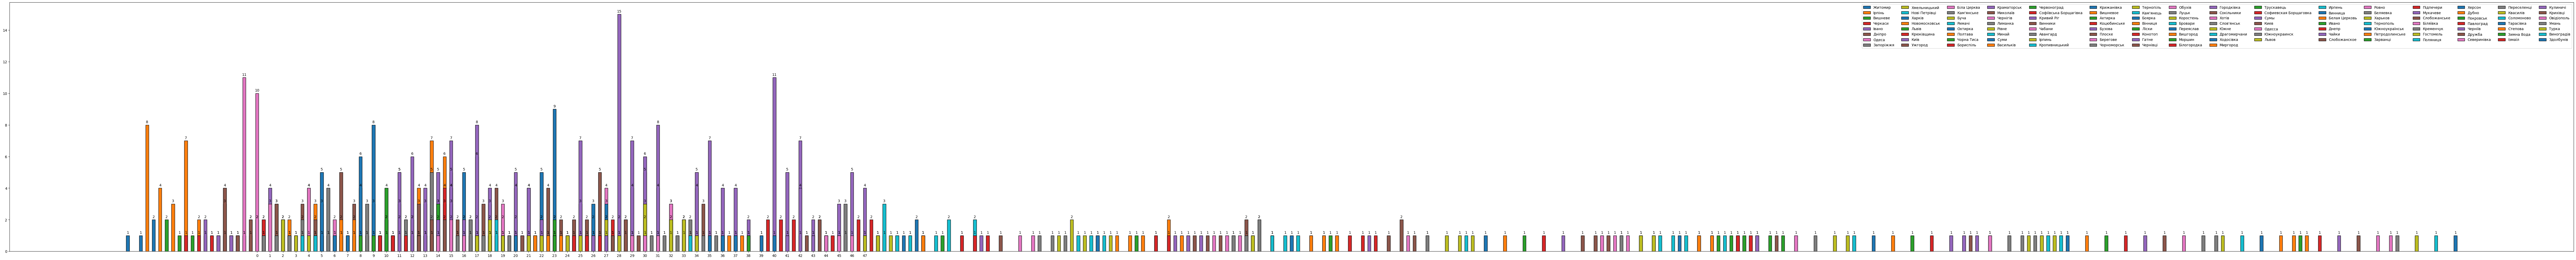

In [24]:
# виведемо кількість пропозицій в кожному місті за кластерами
width = 0.25
offset_width = 1.5
multiplier = 0

for idx in df_res["cluster_id"].unique():
    data = df_res[df_res["cluster_id"] == idx].groupby("city")["_id"].count()
    cluster_df = results[results['cluster_id'] == idx]
    price = cluster_df['price'].values[0]
    size = cluster_df['size'].values[0]

    plt.subplots(figsize=(30, 10))
    rects = plt.bar(data.axes[0].values, data.values)
    plt.bar_label(rects, data.values)
    plt.title(f"Cluster {idx} - ${price:.2f}, {size:.2f} m^2")
    plt.show()

fig, ax = plt.subplots(layout="constrained", figsize=(100, 10))
ids = results["cluster_id"].unique()
cities = df_res["city"].unique()
x = np.arange(len(ids))

for city in cities:
    cluster_df = df_res[df_res["city"] == city]
    data = cluster_df.groupby("cluster_id")["_id"].count()
    print(data)
    print("\n\n\n")
    offset = offset_width * multiplier
    rects = ax.bar(
        np.arange(len(data.values)) + offset, 
        data.values, width, label=city, edgecolor="black"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + 10, ids)
ax.legend(ncols = 16)

plt.show()

0.9735507775518714


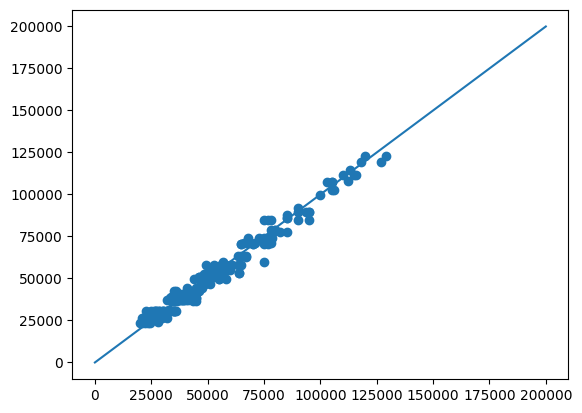

In [25]:
# почнемо тренування лінійної регресії за avg_price і розмірами
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

avg_price_df = results[["price", "size", "cluster_id"]]
avg_price_df = avg_price_df.rename(columns={"price": "avg_price", "size": "avg_size"})
temp_df = pd.merge(avg_price_df, df_res, on="cluster_id")

X = temp_df[["avg_price", "size"]]
y = temp_df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm = LinearRegression()
lm = lm.fit(X_train, y_train)

predictions = lm.predict(X_test)
plt.scatter(y_test, predictions)
plt.plot([0, 200000], [0, 200000])
print(r2_score(y_test, predictions))

In [26]:
# збережемо дані
import pickle

with open("prediction_model.pkl", "wb") as fp:
    pickle.dump(lm, fp)

with open("clustering.pkl", "wb") as fp:
    pickle.dump(kmeans, fp)

with open("scaler.pkl", "wb") as fp:
    pickle.dump(scaler, fp)

           avg_price    avg_size  cluster_id   Unnamed: 0          price  \
count     974.000000  974.000000  974.000000   974.000000     974.000000   
mean    55830.831013   54.809538   22.104723   608.027721   55830.831013   
std     25397.541588   17.536831   13.884834   352.467713   25661.028917   
min     23488.725000   30.071429    0.000000     0.000000   20100.000000   
25%     37094.750000   42.785106   10.000000   301.250000   36100.000000   
50%     50903.978723   50.891786   21.000000   603.500000   50250.000000   
75%     71045.000000   65.719412   35.750000   911.750000   70000.000000   
max    123223.000000  114.250000   47.000000  1225.000000  129999.000000   

             size       rooms  size_cluster  price_cluster  
count  974.000000  974.000000  9.740000e+02   9.740000e+02  
mean    54.809538    1.876797 -2.407383e-16   7.295100e-17  
std     17.729258    0.840408  1.000514e+00   1.000514e+00  
min     20.000000    1.000000 -1.964404e+00  -1.393131e+00  
25%     41

<Axes: >

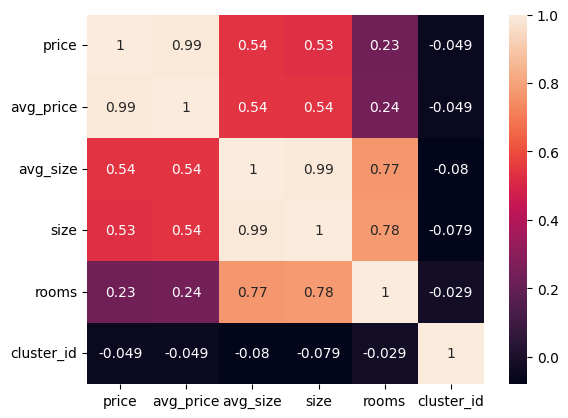

In [27]:
# виведемо дані й кореляційну матрицю
print(temp_df.describe())

sns.heatmap(temp_df[["price", "avg_price", "avg_size", "size", "rooms", "cluster_id"]].corr(), annot=True)

In [28]:
# спробуємо подивитись, як працює на введених користувачем даних
test_data = pd.DataFrame({
    "size": [60, 83],
    "price": [30000, 100000]
})
norm = scaler.fit_transform(test_data)
results = kmeans.predict(norm)
test_data["cluster_id"] = results

print(f"Clusters: {results}")

test_data = test_data.merge(avg_price_df[["cluster_id", "avg_price"]], on="cluster_id")
results = lm.predict(test_data[["avg_price", "size"]])

print(f"Predicted: {results}")

Clusters: [37 12]
Predicted: [[30395.78341725]
 [85799.0306213 ]]
